In [ ]:
import pydot
import graphviz
from keras.utils import plot_model

In [ ]:
import keras.applications.xception
from keras.applications.xception import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from keras.models import  load_model
#from tensorflow.keras.utils import plot_model
from keras.utils import plot_model

In [ ]:
from itertools import chain
from keras.preprocessing.text import Tokenizer

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
import cv2
import pickle
from tqdm import tqdm
from pickle import dump


from pycocotools.coco import COCO

from collections import Counter
import string


In [ ]:
from keras.layers import Input, Dropout, Dense, Embedding, LSTM, add, GRU, concatenate

In [ ]:
#import nltk
#nltk.download("stopwords")
#from nltk.corpus import stopwords

#import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, GRU, Dense, Bidirectional, Input, Dropout, Attention
#from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.optimizers import Adam
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.utils import to_categorical
#from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import add

In [ ]:
# mount google drive - data stored in folder w266_proj
from google.colab import drive
drive.mount ('/content/gdrive')
data_path = '/content/gdrive/MyDrive/w266_proj'

Mounted at /content/gdrive


In [ ]:
# for printing long text over multiple lines
import textwrap
import json

def print_text(text):
  wrapper = textwrap.TextWrapper(width= 150,
                                 break_long_words=False,
                                 break_on_hyphens=False)
  return print(wrapper.fill(json.dumps(text)))

In [ ]:


# coco API git: https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoDemo.ipynb
# initialize coco api for instance annotations

coco=COCO(data_path + "/annotations/instances_train2017.json")

loading annotations into memory...
Done (t=20.45s)
creating index...
index created!


In [ ]:
# exploring coco
# getCadIds return a list of category IDs as a list
print('Total coco categories'.format(len(coco.getCatIds())))            # total categories
print('First ten categories: {} '.format((coco.getCatIds()[:10])))      # total categories
print('FLast ten categories: {} '.format((coco.getCatIds()[-10:])))     # total categories

Total coco categories
First ten categories: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] 
FLast ten categories: [80, 81, 82, 84, 85, 86, 87, 88, 89, 90] 


In [ ]:
coco.loadCats([1,5,7])

[{'supercategory': 'person', 'id': 1, 'name': 'person'},
 {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'},
 {'supercategory': 'vehicle', 'id': 7, 'name': 'train'}]

In [ ]:
# exploring categories
# loadCat functon takes catIDs as input and returns a list of dictionaries containing the categories info

print('Load category data of IDs 1, 5, and 7:  {}'.format(coco.loadCats([1,5,7])))

cat_list = coco.loadCats(coco.getCatIds())                  # load cat for all cat IDs
print('First three categogies: {}'.format(cat_list[:3]))
print('Last three categogies: {}'.format(cat_list[-3:]))

Load category data of IDs 1, 5, and 7:  [{'supercategory': 'person', 'id': 1, 'name': 'person'}, {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'}, {'supercategory': 'vehicle', 'id': 7, 'name': 'train'}]
First three categogies: [{'supercategory': 'person', 'id': 1, 'name': 'person'}, {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'}, {'supercategory': 'vehicle', 'id': 3, 'name': 'car'}]
Last three categogies: [{'supercategory': 'indoor', 'id': 88, 'name': 'teddy bear'}, {'supercategory': 'indoor', 'id': 89, 'name': 'hair drier'}, {'supercategory': 'indoor', 'id': 90, 'name': 'toothbrush'}]


In [ ]:
# From the above cell -- Each dictionary has the format {'supercategory': 'XXX', 'id': XXX, 'name': 'XXX'} -- where name is catgegory, ID is category ID and supercategory is supercategory

# what are all the super categories?

def get_supercat(coco):
  cat_list = coco.loadCats(coco.getCatIds())
  return [cat['supercategory'] for cat in cat_list]

supercat = get_supercat(coco)
print('Total coco supercategories: {} '.format(len(set(supercat))))   # set to get unique values
unique_supercat = set(supercat)
print('coco super categories: {} '.format(', '.join(set(unique_supercat))))

Total coco supercategories: 12 
coco super categories: vehicle, furniture, electronic, indoor, accessory, animal, kitchen, person, sports, food, appliance, outdoor 


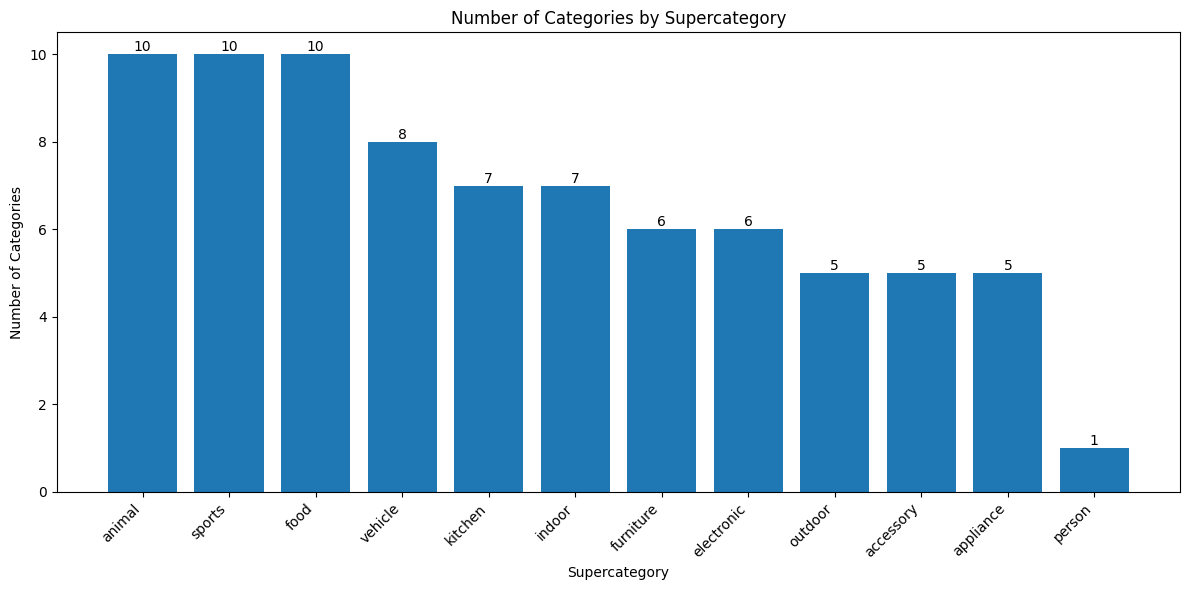

In [ ]:
# plot of number of categories by supercategory in descending order and add values in the plot

# count the number of categories per supercategory
cat_count = Counter(supercat)
# sort the supercategories in descending order of frequency
sorted_supercat = sorted(cat_count, key=cat_count.get, reverse=True)
# create a bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(sorted_supercat, [cat_count[cat] for cat in sorted_supercat])
plt.xlabel('Supercategory')
plt.ylabel('Number of Categories')
plt.title('Number of Categories by Supercategory')
plt.xticks(rotation=45, ha='right')
# add values to the bars
for bar in bars:
  yval = bar.get_height()
  plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')
plt.tight_layout()
plt.show()

In [ ]:
# Whar are all the categories?
def get_cat(coco):
  cat_list = coco.loadCats(coco.getCatIds())
  return [cat['name'] for cat in cat_list]

cat = get_cat(coco)
print('Total coco categories: {} '.format(len(cat)))
print('First ten coco categories: {} '.format(', '.join(cat[:10])))          # no set required - all values are unique
print('Last  ten coco categories: {} '.format(', '.join(cat[-10:])))

Total coco categories: 80 
First ten coco categories: person, bicycle, car, motorcycle, airplane, bus, train, truck, boat, traffic light 
Last  ten coco categories: toaster, sink, refrigerator, book, clock, vase, scissors, teddy bear, hair drier, toothbrush 


In [ ]:
# What are the IDs of each category

def get_catCatId(coco, cat):

  catIds = coco.getCatIds(catNms=cat)
  cat_catId = {}
  for i in range(0,len(cat)):
    cat_catId[cat[i]] = catIds[i]
  return cat_catId


cat_catId = get_catCatId(coco, cat)                    # *** This is an important dictionary and I will be using it

print('Categories and their IDs:')
print_text(cat_catId)

Categories and their IDs:
{"person": 1, "bicycle": 2, "car": 3, "motorcycle": 4, "airplane": 5, "bus": 6, "train": 7, "truck": 8, "boat": 9, "traffic light": 10, "fire
hydrant": 11, "stop sign": 13, "parking meter": 14, "bench": 15, "bird": 16, "cat": 17, "dog": 18, "horse": 19, "sheep": 20, "cow": 21, "elephant":
22, "bear": 23, "zebra": 24, "giraffe": 25, "backpack": 27, "umbrella": 28, "handbag": 31, "tie": 32, "suitcase": 33, "frisbee": 34, "skis": 35,
"snowboard": 36, "sports ball": 37, "kite": 38, "baseball bat": 39, "baseball glove": 40, "skateboard": 41, "surfboard": 42, "tennis racket": 43,
"bottle": 44, "wine glass": 46, "cup": 47, "fork": 48, "knife": 49, "spoon": 50, "bowl": 51, "banana": 52, "apple": 53, "sandwich": 54, "orange": 55,
"broccoli": 56, "carrot": 57, "hot dog": 58, "pizza": 59, "donut": 60, "cake": 61, "chair": 62, "couch": 63, "potted plant": 64, "bed": 65, "dining
table": 67, "toilet": 70, "tv": 72, "laptop": 73, "mouse": 74, "remote": 75, "keyboard": 76, "c

In [ ]:
# Number of images per subcategories

def get_cat_imgId(coco, cat_catId):
  cat_imgId = {}
  for cat in cat_catId:
    imgIds = coco.getImgIds(catIds=cat_catId[cat])        # get all the image IDs for a specific category - need to pass ID to catIds
    cat_imgId[cat] = imgIds
  return cat_imgId

cat_imgId = get_cat_imgId(coco, cat_catId)

print('First 10 image IDs of Person: {}\n'.format(str(cat_imgId['person'][:10])))

cat_numImg = {key: len(value) for key, value in cat_imgId.items()}
cat_numImg = {k: v for k, v in sorted(cat_numImg.items(), key=lambda item: item[1], reverse=True)}
print("Total images in each sub categories:")
print_text(cat_numImg)

First 10 image IDs of Person: [262145, 262146, 524291, 262148, 393223, 393224, 524297, 393227, 131084, 393230]

Total images in each sub categories:
{"person": 64115, "chair": 12774, "car": 12251, "dining table": 11837, "cup": 9189, "bottle": 8501, "bowl": 7111, "handbag": 6841, "truck": 6127,
"bench": 5570, "backpack": 5528, "book": 5332, "cell phone": 4803, "sink": 4678, "clock": 4659, "tv": 4561, "potted plant": 4452, "couch": 4423,
"dog": 4385, "knife": 4326, "sports ball": 4262, "traffic light": 4139, "cat": 4114, "umbrella": 3968, "bus": 3952, "tie": 3810, "bed": 3682, "vase":
3593, "train": 3588, "fork": 3555, "spoon": 3529, "laptop": 3524, "motorcycle": 3502, "surfboard": 3486, "skateboard": 3476, "tennis racket": 3394,
"toilet": 3353, "bicycle": 3252, "bird": 3237, "pizza": 3166, "skis": 3082, "remote": 3076, "boat": 3025, "airplane": 2986, "horse": 2941, "cake":
2925, "oven": 2877, "baseball glove": 2629, "giraffe": 2546, "wine glass": 2533, "baseball bat": 2506, "suitcase": 

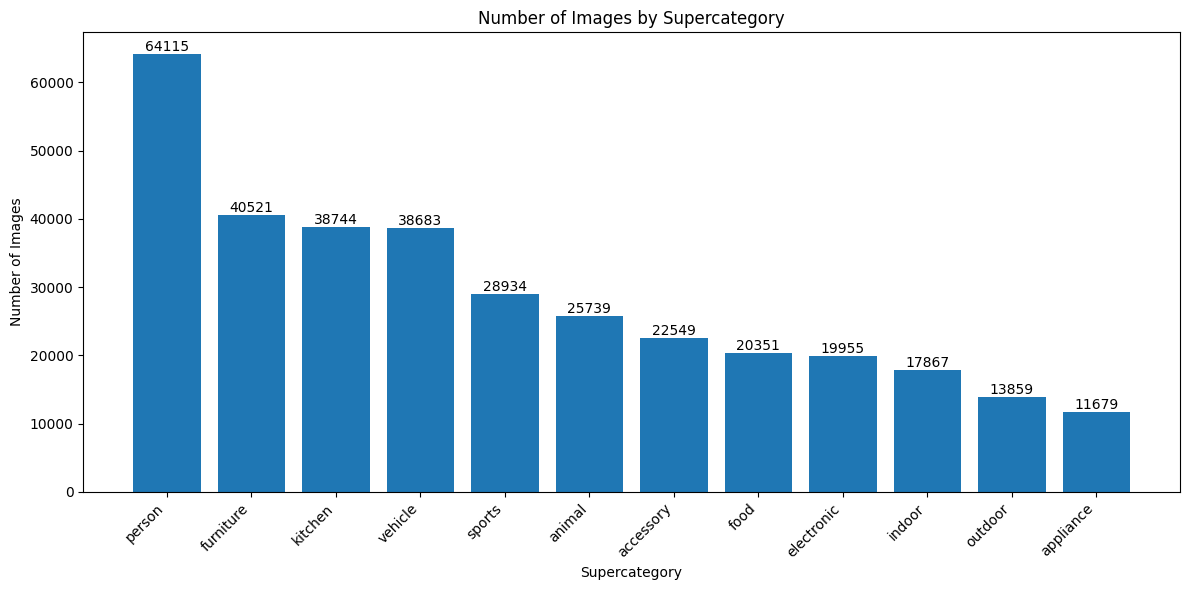

In [ ]:
# count the number of images per supercategory
supercat_img_count = {}
for cat in cat_list:
  supercategory = cat['supercategory']
  if supercategory not in supercat_img_count:
    supercat_img_count[supercategory] = 0
  supercat_img_count[supercategory] += len(coco.getImgIds(catIds=[cat['id']]))

# sort the supercategories in descending order of image count
sorted_supercat_img = sorted(supercat_img_count, key=supercat_img_count.get, reverse=True)

# create a bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(sorted_supercat_img, [supercat_img_count[cat] for cat in sorted_supercat_img])
plt.xlabel('Supercategory')
plt.ylabel('Number of Images')
plt.title('Number of Images by Supercategory')
plt.xticks(rotation=45, ha='right')

# add values to the bars
for bar in bars:
  yval = bar.get_height()
  plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

plt.tight_layout()
plt.show()


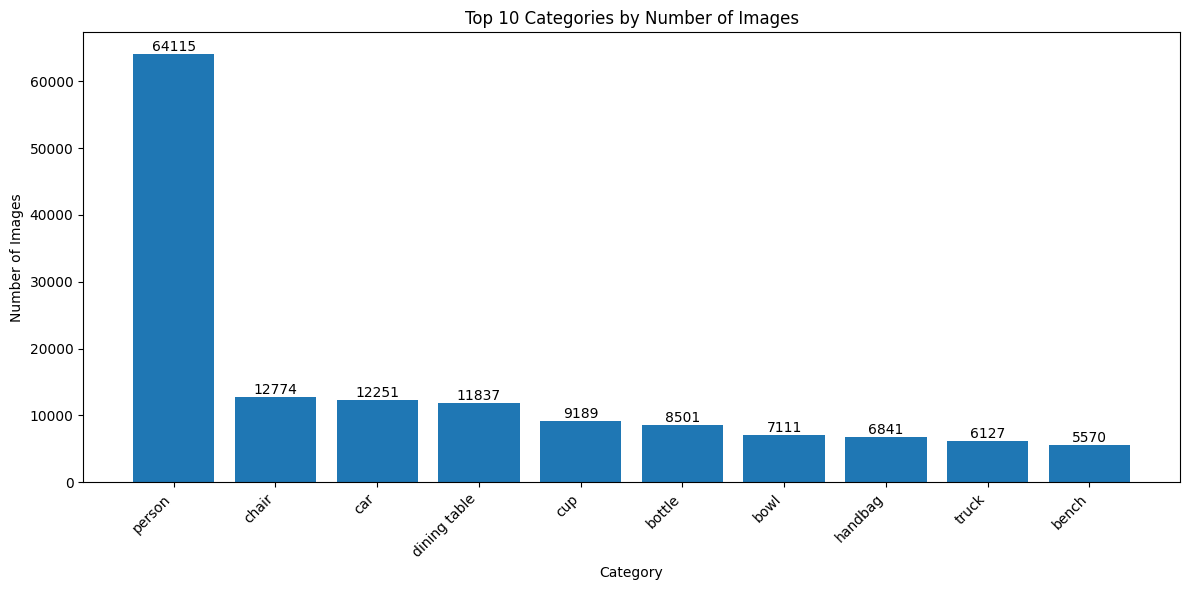

In [ ]:
# plot top 10 categories with bar values

# count the number of images per category
cat_img_count = {}
for cat in cat_list:
  cat_img_count[cat['name']] = len(coco.getImgIds(catIds=[cat['id']]))

# sort the categories in descending order of image count
sorted_cat_img = sorted(cat_img_count, key=cat_img_count.get, reverse=True)

# select the top 10 categories
top_10_cats = sorted_cat_img[:10]

# create a bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(top_10_cats, [cat_img_count[cat] for cat in top_10_cats])
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.title('Top 10 Categories by Number of Images')
plt.xticks(rotation=45, ha='right')

# add values to the bars
for bar in bars:
  yval = bar.get_height()
  plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

plt.tight_layout()
plt.show()

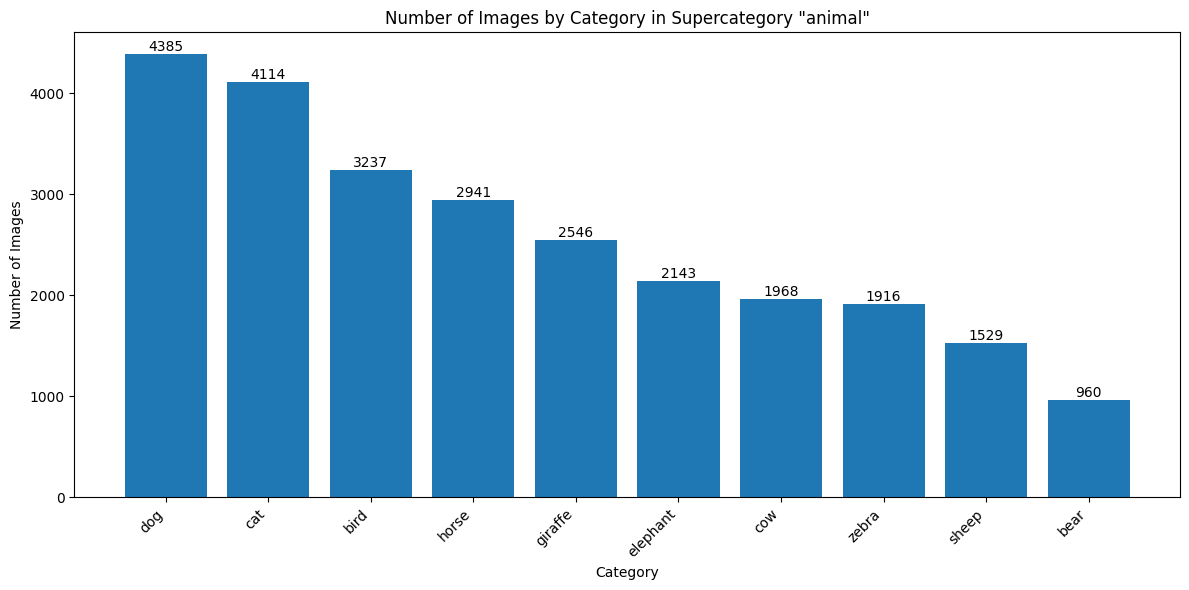

In [ ]:
# plot number of images for all categories in super categories animal

# count the number of images per category for animal supercategory
animal_cat_img_count = {}
for cat in cat_list:
  if cat['supercategory'] == 'animal':
    animal_cat_img_count[cat['name']] = len(coco.getImgIds(catIds=[cat['id']]))

# sort the categories in descending order of image count
sorted_animal_cat_img = sorted(animal_cat_img_count, key=animal_cat_img_count.get, reverse=True)

# create a bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(sorted_animal_cat_img, [animal_cat_img_count[cat] for cat in sorted_animal_cat_img])
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.title('Number of Images by Category in Supercategory "animal"')
plt.xticks(rotation=45, ha='right')

# add values to the bars
for bar in bars:
  yval = bar.get_height()
  plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

plt.tight_layout()
plt.show()


In [ ]:
# list all categories in super categories animal
animal_categories = [cat['name'] for cat in cat_list if cat['supercategory'] == 'animal']
print("Categories in supercategory 'animal':")
for category in animal_categories:
    print(category)


Categories in supercategory 'animal':
bird
cat
dog
horse
sheep
cow
elephant
bear
zebra
giraffe


Total Images:  21330


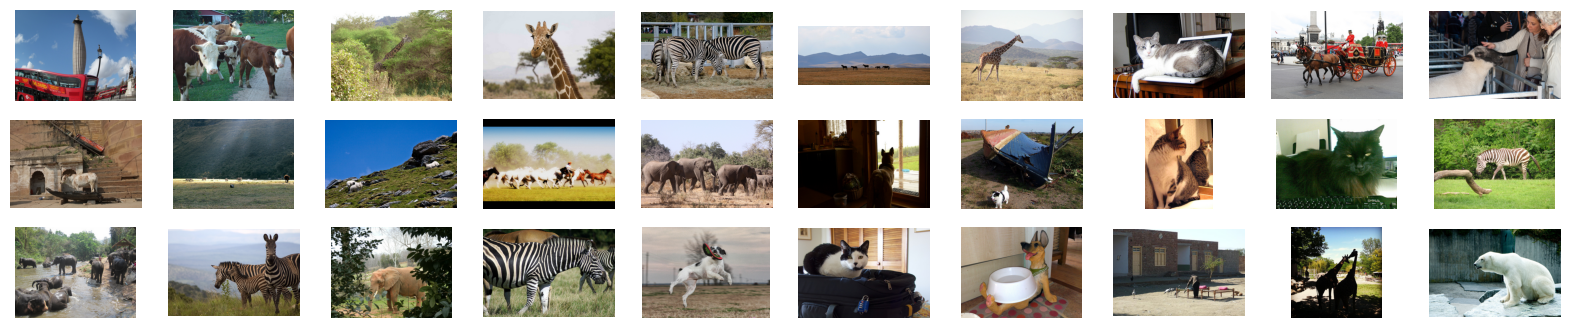

In [ ]:
# Load some random images

train_cats = cat_imgId['giraffe'] + cat_imgId['elephant'] + cat_imgId['cat'] + cat_imgId['dog'] + cat_imgId['horse'] + cat_imgId['sheep'] + cat_imgId['cow']  + cat_imgId['bear'] + cat_imgId['zebra']  #+ cat_imgId['bird']
#train_cats = train_cats [:30]
imgIds = coco.getImgIds(imgIds = train_cats)
print("Total Images: ", len(imgIds))

fig = plt.gcf()
fig.set_size_inches(20, 4)

random.shuffle(imgIds)

for i, imgId in enumerate(imgIds[0:30]):
  sp = plt.subplot(3, 10, i + 1)
  sp.axis('Off')
  img = coco.loadImgs(imgId)[0]         # list has only zero element -- [0]--> will give dict --> coco_url has the image link
  I = io.imread(img['coco_url'])
  plt.imshow(I)

In [ ]:
# what info does the load image dict has
coco.loadImgs(imgIds[3])
# a list with a single element is returned below -- need index [0] to get the dict

[{'license': 3,
  'file_name': '000000310344.jpg',
  'coco_url': 'http://images.cocodataset.org/train2017/000000310344.jpg',
  'height': 427,
  'width': 640,
  'date_captured': '2013-11-16 17:31:26',
  'flickr_url': 'http://farm8.staticflickr.com/7178/6859626097_3b561d69bf_z.jpg',
  'id': 310344}]

In [ ]:
# Load images with respective captions
coco_caps = COCO(data_path + "/annotations/captions_train2017.json")

loading annotations into memory...
Done (t=2.66s)
creating index...
index created!


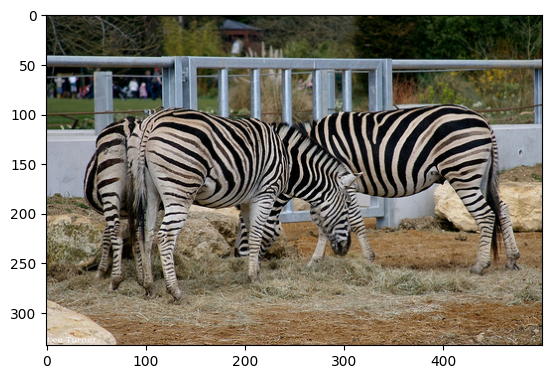

Three zebra are eating hay in an enclosed area. 
Several zebra standing together with their heads down, inside an enclosed and gated area.
These three zebras graze quietly at the zoo 
Three zebras eating from a bale in an outdoor pen
A couple of zebras that are eating some hay. 


In [ ]:
# Image captions
img = coco.loadImgs(imgIds[4])[0]    # index [0] of list is the dict
I = io.imread(img['coco_url'])       # coco_url is the key - value is url
plt.imshow(I)
plt.show()
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)

In [ ]:
def generate_url_caps(imgIds, coco, coco_caps):
  url_caps = {}
  imgcaptions = []
  for imgId in imgIds:
      img = coco.loadImgs(imgId)[0]
      annIds = coco_caps.getAnnIds(imgIds=img['id']);   # this ImgIds is a parameter of the function and it should be a single num -- the imgIds in the for loop is a list of all img IDs...
      anns = coco_caps.loadAnns(annIds)
      imgcaptions = []
      for cap in anns:
          cap = cap['caption'].translate(str.maketrans('', '', string.punctuation))
          cap = cap.replace("-"," ")
          cap = cap.split()
          cap = [word.lower() for word in cap]
          cap = '<start> ' + " ".join(cap) + ' <end>'
          imgcaptions.append(cap)
      url_caps[img['coco_url']] = imgcaptions
  return url_caps

url_caps = generate_url_caps(imgIds, coco, coco_caps)

In [ ]:
print("Length of Dataset: ",len(url_caps))
print_text(url_caps['http://images.cocodataset.org/train2017/000000091262.jpg'])

Length of Dataset:  21330
["<start> giraffes in their natural habitat of grasses and trees <end>", "<start> a giraffe holds his neck at an angle to watch for danger <end>",
"<start> two giraffes are walking in some bushes and trees <end>", "<start> two giraffes stand in a field of grass and brush <end>", "<start> two
giraffes take position in a thicket with one to the left and one to the right <end>"]


In [ ]:
# print url_caps
import pandas as pd
df_url_caps = pd.DataFrame.from_dict(url_caps, orient='index').stack().reset_index(level=0).set_index('level_0').rename(columns={0:'captions'})
df_url_caps.head(10)

,captions
level_0,
http://images.cocodataset.org/train2017/000000434262.jpg,<start> a red double decker bus traveling past...
http://images.cocodataset.org/train2017/000000434262.jpg,<start> a warped photograph of a double decker...
http://images.cocodataset.org/train2017/000000434262.jpg,<start> we have a distorted view of a bus and ...
http://images.cocodataset.org/train2017/000000434262.jpg,<start> a tour bus is passing by a monument <end>
http://images.cocodataset.org/train2017/000000434262.jpg,<start> an distorted image of a bus and some a...
http://images.cocodataset.org/train2017/000000203551.jpg,<start> a herd of cattle grazing on a lush gra...
http://images.cocodataset.org/train2017/000000203551.jpg,<start> a group of cows crossing a dirt road <...
http://images.cocodataset.org/train2017/000000203551.jpg,<start> three young cows walk amongst four adu...
http://images.cocodataset.org/train2017/000000203551.jpg,<start> a lot of cows in a pasture watching th...


### **Image Feature Extraction**

In [ ]:
def preprocess_xception_image(img_url):
  image = io.imread(img_url)
  if image.ndim != 3:
        image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
  image = cv2.resize(image,(299,299))
  image = img_to_array(image)
  image = np.expand_dims(image, axis=0)
  image = keras.applications.xception.preprocess_input(image)
  return image

def extract_xception_features(model, url_caps):
  xception_features = {}
  for img_url in tqdm(url_caps.keys()):
    image = preprocess_xception_image(img_url)
    feature = model.predict(image)
    xception_features[img_url] = feature
  return xception_features

model_xception = keras.applications.xception.Xception()
model_xception = Model(inputs=model_xception.inputs, outputs=model_xception.layers[-2].output)
print(model_xception.summary())

91884032/91884032 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  

In [ ]:
xception_features = extract_xception_features(model_xception, url_caps)

  0%|          | 0/4665 [00:00<?, ?it/s]

1/1 [==============================] - 5s 5s/step


  0%|          | 1/4665 [00:06<8:08:06,  6.28s/it]

1/1 [==============================] - 0s 22ms/step


  0%|          | 2/4665 [00:06<3:44:12,  2.88s/it]

1/1 [==============================] - 0s 23ms/step


  0%|          | 3/4665 [00:07<2:24:49,  1.86s/it]

1/1 [==============================] - 0s 21ms/step


  0%|          | 4/4665 [00:08<1:49:23,  1.41s/it]

1/1 [==============================] - 0s 23ms/step


  0%|          | 5/4665 [00:08<1:27:28,  1.13s/it]

1/1 [==============================] - 0s 24ms/step


  0%|          | 6/4665 [00:09<1:15:29,  1.03it/s]

1/1 [==============================] - 0s 35ms/step


  0%|          | 7/4665 [00:10<1:06:16,  1.17it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 8/4665 [00:10<1:01:22,  1.26it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 9/4665 [00:11<56:43,  1.37it/s]  

1/1 [==============================] - 0s 22ms/step


  0%|          | 10/4665 [00:11<54:16,  1.43it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 11/4665 [00:12<51:04,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 12/4665 [00:13<51:16,  1.51it/s]

1/1 [==============================] - 0s 107ms/step


  0%|          | 13/4665 [00:13<54:04,  1.43it/s]

1/1 [==============================] - 0s 115ms/step


  0%|          | 14/4665 [00:14<58:26,  1.33it/s]

1/1 [==============================] - 0s 35ms/step


  0%|          | 15/4665 [00:15<57:18,  1.35it/s]

1/1 [==============================] - 0s 65ms/step


  0%|          | 16/4665 [00:16<56:58,  1.36it/s]

1/1 [==============================] - 0s 75ms/step


  0%|          | 17/4665 [00:17<57:16,  1.35it/s]

1/1 [==============================] - 0s 114ms/step


  0%|          | 18/4665 [00:17<57:52,  1.34it/s]

1/1 [==============================] - 0s 98ms/step


  0%|          | 19/4665 [00:18<1:02:35,  1.24it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 20/4665 [00:19<59:26,  1.30it/s]  

1/1 [==============================] - 0s 21ms/step


  0%|          | 21/4665 [00:19<54:34,  1.42it/s]

1/1 [==============================] - 0s 51ms/step


  0%|          | 22/4665 [00:20<54:30,  1.42it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 23/4665 [00:21<53:02,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 24/4665 [00:21<50:31,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 25/4665 [00:22<50:52,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 26/4665 [00:23<50:58,  1.52it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 27/4665 [00:23<50:52,  1.52it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 28/4665 [00:24<51:51,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 29/4665 [00:25<49:20,  1.57it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 30/4665 [00:25<47:21,  1.63it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 31/4665 [00:26<46:59,  1.64it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 32/4665 [00:26<48:14,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 33/4665 [00:27<49:45,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 34/4665 [00:28<51:07,  1.51it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 35/4665 [00:28<50:10,  1.54it/s]

1/1 [==============================] - 0s 46ms/step


  1%|          | 36/4665 [00:29<52:45,  1.46it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 37/4665 [00:30<53:58,  1.43it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 38/4665 [00:31<53:03,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 39/4665 [00:31<52:44,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 40/4665 [00:32<51:40,  1.49it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 41/4665 [00:33<51:53,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 42/4665 [00:33<52:08,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 43/4665 [00:34<52:37,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 44/4665 [00:35<52:49,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 45/4665 [00:36<58:42,  1.31it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 46/4665 [00:36<59:04,  1.30it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 47/4665 [00:37<57:37,  1.34it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 48/4665 [00:38<55:32,  1.39it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 49/4665 [00:39<55:44,  1.38it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 50/4665 [00:39<49:50,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 51/4665 [00:40<56:51,  1.35it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 52/4665 [00:41<53:43,  1.43it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 53/4665 [00:41<51:57,  1.48it/s]

1/1 [==============================] - 0s 40ms/step


  1%|          | 54/4665 [00:42<50:25,  1.52it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 55/4665 [00:43<53:07,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 56/4665 [00:43<51:23,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 57/4665 [00:44<51:48,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 58/4665 [00:44<50:24,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 59/4665 [00:45<50:30,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 60/4665 [00:46<51:25,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 61/4665 [00:46<50:57,  1.51it/s]

1/1 [==============================] - 0s 33ms/step


  1%|▏         | 62/4665 [00:47<51:35,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 63/4665 [00:48<51:38,  1.49it/s]

1/1 [==============================] - 0s 24ms/step


  1%|▏         | 64/4665 [00:48<49:57,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 65/4665 [00:49<48:49,  1.57it/s]

1/1 [==============================] - 0s 24ms/step


  1%|▏         | 66/4665 [00:50<50:02,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 67/4665 [00:50<49:06,  1.56it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 68/4665 [00:51<48:25,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▏         | 69/4665 [00:52<50:11,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 70/4665 [00:52<50:21,  1.52it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 71/4665 [00:53<51:59,  1.47it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 72/4665 [00:54<51:12,  1.50it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 73/4665 [00:54<49:57,  1.53it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 74/4665 [00:55<49:53,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 75/4665 [00:56<50:24,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 76/4665 [00:56<49:26,  1.55it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 77/4665 [00:57<53:52,  1.42it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 78/4665 [00:58<52:53,  1.45it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 79/4665 [00:58<51:01,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 80/4665 [00:59<51:02,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 81/4665 [01:00<51:24,  1.49it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 82/4665 [01:00<52:23,  1.46it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 83/4665 [01:01<51:51,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 84/4665 [01:02<49:54,  1.53it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 85/4665 [01:02<50:44,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 86/4665 [01:03<49:00,  1.56it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 87/4665 [01:04<48:13,  1.58it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 88/4665 [01:04<51:29,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 89/4665 [01:05<51:43,  1.47it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 90/4665 [01:06<52:28,  1.45it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 91/4665 [01:07<53:48,  1.42it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 92/4665 [01:07<52:24,  1.45it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 93/4665 [01:08<51:03,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 94/4665 [01:08<51:27,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 95/4665 [01:09<53:15,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 96/4665 [01:10<53:19,  1.43it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 97/4665 [01:11<51:36,  1.48it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 98/4665 [01:11<49:59,  1.52it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 99/4665 [01:12<48:52,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 100/4665 [01:12<45:27,  1.67it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 101/4665 [01:13<46:01,  1.65it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 102/4665 [01:14<47:56,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 103/4665 [01:14<45:19,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 104/4665 [01:15<45:04,  1.69it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 105/4665 [01:15<45:11,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 106/4665 [01:16<44:04,  1.72it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 107/4665 [01:17<47:05,  1.61it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 108/4665 [01:17<46:31,  1.63it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 109/4665 [01:18<49:32,  1.53it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 110/4665 [01:19<50:43,  1.50it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 111/4665 [01:19<49:51,  1.52it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 112/4665 [01:20<50:51,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 113/4665 [01:21<51:16,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 114/4665 [01:21<50:38,  1.50it/s]

1/1 [==============================] - 0s 54ms/step


  2%|▏         | 115/4665 [01:22<50:03,  1.51it/s]

1/1 [==============================] - 0s 92ms/step


  2%|▏         | 116/4665 [01:23<53:55,  1.41it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 117/4665 [01:24<56:19,  1.35it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 118/4665 [01:24<55:13,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 119/4665 [01:25<54:16,  1.40it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 120/4665 [01:26<51:29,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 121/4665 [01:26<47:57,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 122/4665 [01:27<48:52,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 123/4665 [01:27<49:13,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 124/4665 [01:28<48:31,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 125/4665 [01:29<49:48,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 126/4665 [01:29<50:27,  1.50it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 127/4665 [01:30<50:24,  1.50it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 128/4665 [01:31<51:56,  1.46it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 129/4665 [01:31<50:46,  1.49it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 130/4665 [01:32<51:58,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 131/4665 [01:33<50:50,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 132/4665 [01:33<49:18,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 133/4665 [01:34<45:44,  1.65it/s]

1/1 [==============================] - 0s 42ms/step


  3%|▎         | 134/4665 [01:35<46:56,  1.61it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 135/4665 [01:35<46:12,  1.63it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 136/4665 [01:36<45:20,  1.66it/s]

1/1 [==============================] - 0s 92ms/step


  3%|▎         | 137/4665 [01:37<52:09,  1.45it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 138/4665 [01:37<52:52,  1.43it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 139/4665 [01:38<52:30,  1.44it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 140/4665 [01:39<52:19,  1.44it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 141/4665 [01:39<51:29,  1.46it/s]

1/1 [==============================] - 0s 49ms/step


  3%|▎         | 142/4665 [01:40<52:52,  1.43it/s]

1/1 [==============================] - 0s 41ms/step


  3%|▎         | 143/4665 [01:41<55:35,  1.36it/s]

1/1 [==============================] - 0s 64ms/step


  3%|▎         | 144/4665 [01:42<1:03:12,  1.19it/s]

1/1 [==============================] - 0s 223ms/step


  3%|▎         | 145/4665 [01:44<1:19:12,  1.05s/it]

1/1 [==============================] - 0s 97ms/step


  3%|▎         | 146/4665 [01:44<1:13:28,  1.03it/s]

1/1 [==============================] - 0s 86ms/step


  3%|▎         | 147/4665 [01:45<1:10:27,  1.07it/s]

1/1 [==============================] - 0s 58ms/step


  3%|▎         | 148/4665 [01:46<1:06:29,  1.13it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 149/4665 [01:47<1:04:09,  1.17it/s]

1/1 [==============================] - 0s 43ms/step


  3%|▎         | 150/4665 [01:47<1:00:09,  1.25it/s]

1/1 [==============================] - 0s 45ms/step


  3%|▎         | 151/4665 [01:48<1:00:33,  1.24it/s]

1/1 [==============================] - 0s 51ms/step


  3%|▎         | 152/4665 [01:49<59:53,  1.26it/s]  

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 153/4665 [01:50<57:28,  1.31it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 154/4665 [01:50<56:05,  1.34it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 155/4665 [01:51<51:29,  1.46it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 156/4665 [01:52<50:56,  1.48it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 157/4665 [01:52<49:27,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 158/4665 [01:53<49:45,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 159/4665 [01:54<50:16,  1.49it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 160/4665 [01:54<50:27,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 161/4665 [01:55<49:35,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 162/4665 [01:56<48:35,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 163/4665 [01:56<47:49,  1.57it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▎         | 164/4665 [01:57<49:43,  1.51it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▎         | 165/4665 [01:58<49:41,  1.51it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▎         | 166/4665 [01:58<49:46,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 167/4665 [01:59<52:21,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 168/4665 [02:00<54:07,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 169/4665 [02:00<54:05,  1.39it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 170/4665 [02:01<55:32,  1.35it/s]

1/1 [==============================] - 0s 89ms/step


  4%|▎         | 171/4665 [02:02<58:29,  1.28it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 172/4665 [02:03<56:03,  1.34it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▎         | 173/4665 [02:03<54:55,  1.36it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▎         | 174/4665 [02:04<52:10,  1.43it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 175/4665 [02:05<51:45,  1.45it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▍         | 176/4665 [02:05<51:33,  1.45it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▍         | 177/4665 [02:06<49:18,  1.52it/s]

1/1 [==============================] - 0s 41ms/step


  4%|▍         | 178/4665 [02:07<50:51,  1.47it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 179/4665 [02:07<50:39,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 180/4665 [02:08<49:22,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 181/4665 [02:09<48:11,  1.55it/s]

1/1 [==============================] - 0s 52ms/step


  4%|▍         | 182/4665 [02:09<50:11,  1.49it/s]

1/1 [==============================] - 0s 113ms/step


  4%|▍         | 183/4665 [02:10<55:02,  1.36it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▍         | 184/4665 [02:11<52:52,  1.41it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 185/4665 [02:12<54:15,  1.38it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 186/4665 [02:13<1:00:14,  1.24it/s]

1/1 [==============================] - 0s 40ms/step


  4%|▍         | 187/4665 [02:13<57:49,  1.29it/s]  

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 188/4665 [02:14<56:18,  1.33it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 189/4665 [02:15<54:23,  1.37it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 190/4665 [02:15<53:29,  1.39it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 191/4665 [02:16<50:46,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 192/4665 [02:17<51:32,  1.45it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 193/4665 [02:17<49:53,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 194/4665 [02:18<48:44,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 195/4665 [02:19<49:44,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 196/4665 [02:19<50:15,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 197/4665 [02:20<49:18,  1.51it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 198/4665 [02:21<47:57,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 199/4665 [02:21<51:58,  1.43it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 200/4665 [02:22<54:17,  1.37it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 201/4665 [02:23<52:32,  1.42it/s]

1/1 [==============================] - 0s 54ms/step


  4%|▍         | 202/4665 [02:24<50:59,  1.46it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 203/4665 [02:24<53:23,  1.39it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 204/4665 [02:25<52:57,  1.40it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 205/4665 [02:26<50:30,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 206/4665 [02:26<51:30,  1.44it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 207/4665 [02:27<52:16,  1.42it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 208/4665 [02:28<50:19,  1.48it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 209/4665 [02:28<50:40,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 210/4665 [02:29<49:30,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 211/4665 [02:30<51:18,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 212/4665 [02:30<51:34,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 213/4665 [02:31<51:34,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 214/4665 [02:32<50:52,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 215/4665 [02:32<49:24,  1.50it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 216/4665 [02:33<48:30,  1.53it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 217/4665 [02:34<49:51,  1.49it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▍         | 218/4665 [02:34<49:46,  1.49it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▍         | 219/4665 [02:35<49:14,  1.50it/s]

1/1 [==============================] - 0s 42ms/step


  5%|▍         | 220/4665 [02:36<51:33,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 221/4665 [02:37<50:54,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 222/4665 [02:37<48:46,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 223/4665 [02:38<49:26,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 224/4665 [02:39<57:15,  1.29it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 225/4665 [02:39<53:05,  1.39it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▍         | 226/4665 [02:40<52:26,  1.41it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 227/4665 [02:41<51:11,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 228/4665 [02:42<51:37,  1.43it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 229/4665 [02:42<49:29,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 230/4665 [02:43<47:51,  1.54it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 231/4665 [02:43<47:47,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 232/4665 [02:44<46:37,  1.58it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 233/4665 [02:45<46:26,  1.59it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 234/4665 [02:45<45:46,  1.61it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 235/4665 [02:46<47:44,  1.55it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▌         | 236/4665 [02:47<49:27,  1.49it/s]

1/1 [==============================] - 0s 47ms/step


  5%|▌         | 237/4665 [02:47<50:37,  1.46it/s]

1/1 [==============================] - 0s 44ms/step


  5%|▌         | 238/4665 [02:48<50:23,  1.46it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▌         | 239/4665 [02:49<48:50,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 240/4665 [02:49<49:53,  1.48it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 241/4665 [02:50<50:38,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 242/4665 [02:51<51:34,  1.43it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 243/4665 [02:51<51:42,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 244/4665 [02:52<51:00,  1.44it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 245/4665 [02:53<1:02:17,  1.18it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 246/4665 [02:54<59:02,  1.25it/s]  

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 247/4665 [02:55<1:02:13,  1.18it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 248/4665 [02:56<57:14,  1.29it/s]  

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 249/4665 [02:56<55:00,  1.34it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 250/4665 [02:57<51:13,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 251/4665 [02:58<51:35,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 252/4665 [02:58<49:39,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 253/4665 [02:59<49:50,  1.48it/s]

1/1 [==============================] - 0s 35ms/step


  5%|▌         | 254/4665 [03:00<51:02,  1.44it/s]

1/1 [==============================] - 0s 37ms/step


  5%|▌         | 255/4665 [03:00<50:25,  1.46it/s]

1/1 [==============================] - 0s 39ms/step


  5%|▌         | 256/4665 [03:01<52:14,  1.41it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 257/4665 [03:02<51:10,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 258/4665 [03:02<50:51,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 259/4665 [03:03<51:38,  1.42it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 260/4665 [03:04<51:05,  1.44it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 261/4665 [03:04<49:19,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 262/4665 [03:05<47:29,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 263/4665 [03:06<48:29,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 264/4665 [03:06<49:21,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 265/4665 [03:07<52:01,  1.41it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 266/4665 [03:08<51:25,  1.43it/s]

1/1 [==============================] - 0s 126ms/step


  6%|▌         | 267/4665 [03:09<59:28,  1.23it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 268/4665 [03:10<56:53,  1.29it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 269/4665 [03:10<57:11,  1.28it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 270/4665 [03:11<54:40,  1.34it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 271/4665 [03:12<54:03,  1.35it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 272/4665 [03:12<51:23,  1.42it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 273/4665 [03:13<51:40,  1.42it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 274/4665 [03:14<49:16,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 275/4665 [03:14<49:41,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 276/4665 [03:15<49:44,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 277/4665 [03:16<49:40,  1.47it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 278/4665 [03:16<49:51,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 279/4665 [03:17<49:51,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 280/4665 [03:18<46:22,  1.58it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 281/4665 [03:18<44:59,  1.62it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 282/4665 [03:19<46:54,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 283/4665 [03:20<47:46,  1.53it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 284/4665 [03:20<46:28,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 285/4665 [03:21<45:35,  1.60it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 286/4665 [03:21<44:48,  1.63it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 287/4665 [03:22<46:34,  1.57it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 288/4665 [03:23<47:41,  1.53it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 289/4665 [03:23<46:21,  1.57it/s]

1/1 [==============================] - 0s 56ms/step


  6%|▌         | 290/4665 [03:24<48:04,  1.52it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 291/4665 [03:25<47:36,  1.53it/s]

1/1 [==============================] - 0s 41ms/step


  6%|▋         | 292/4665 [03:26<50:11,  1.45it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▋         | 293/4665 [03:26<50:03,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 294/4665 [03:27<49:53,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▋         | 295/4665 [03:28<49:32,  1.47it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▋         | 296/4665 [03:28<48:28,  1.50it/s]

1/1 [==============================] - 0s 89ms/step


  6%|▋         | 297/4665 [03:29<52:21,  1.39it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▋         | 298/4665 [03:30<51:22,  1.42it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▋         | 299/4665 [03:30<50:45,  1.43it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▋         | 300/4665 [03:31<50:34,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 301/4665 [03:32<50:05,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 302/4665 [03:32<48:45,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 303/4665 [03:33<47:24,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 304/4665 [03:34<48:02,  1.51it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 305/4665 [03:34<49:34,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 306/4665 [03:35<48:10,  1.51it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 307/4665 [03:36<1:00:36,  1.20it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 308/4665 [03:37<57:48,  1.26it/s]  

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 309/4665 [03:38<54:24,  1.33it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 310/4665 [03:38<52:11,  1.39it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 311/4665 [03:39<50:16,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 312/4665 [03:40<50:18,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 313/4665 [03:40<48:43,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 314/4665 [03:41<48:28,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 315/4665 [03:42<48:51,  1.48it/s]

1/1 [==============================] - 0s 75ms/step


  7%|▋         | 316/4665 [03:42<54:37,  1.33it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 317/4665 [03:43<51:13,  1.41it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 318/4665 [03:44<50:57,  1.42it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 319/4665 [03:44<48:28,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 320/4665 [03:45<47:59,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 321/4665 [03:46<48:49,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 322/4665 [03:46<49:24,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 323/4665 [03:47<44:44,  1.62it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 324/4665 [03:48<46:39,  1.55it/s]

1/1 [==============================] - 0s 37ms/step


  7%|▋         | 325/4665 [03:48<48:46,  1.48it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 326/4665 [03:49<48:28,  1.49it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 327/4665 [03:50<47:21,  1.53it/s]

1/1 [==============================] - 0s 41ms/step


  7%|▋         | 328/4665 [03:50<48:31,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 329/4665 [03:51<48:46,  1.48it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 330/4665 [03:52<47:23,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 331/4665 [03:52<47:14,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 332/4665 [03:53<47:49,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 333/4665 [03:54<48:19,  1.49it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 334/4665 [03:54<50:13,  1.44it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 335/4665 [03:55<50:24,  1.43it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 336/4665 [03:56<51:00,  1.41it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 337/4665 [03:57<50:36,  1.43it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 338/4665 [03:57<43:54,  1.64it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 339/4665 [03:58<45:11,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 340/4665 [03:58<44:10,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 341/4665 [03:59<45:53,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 342/4665 [03:59<45:31,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 343/4665 [04:00<46:53,  1.54it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 344/4665 [04:01<48:38,  1.48it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 345/4665 [04:02<52:03,  1.38it/s]

1/1 [==============================] - 0s 43ms/step


  7%|▋         | 346/4665 [04:03<54:29,  1.32it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 347/4665 [04:03<54:55,  1.31it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 348/4665 [04:04<53:18,  1.35it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 349/4665 [04:05<53:51,  1.34it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 350/4665 [04:06<54:04,  1.33it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 351/4665 [04:06<52:42,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 352/4665 [04:07<51:51,  1.39it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 353/4665 [04:08<50:48,  1.41it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 354/4665 [04:09<55:46,  1.29it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 355/4665 [04:09<59:01,  1.22it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 356/4665 [04:10<55:52,  1.29it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 357/4665 [04:11<52:00,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 358/4665 [04:11<49:02,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 359/4665 [04:12<52:51,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 360/4665 [04:13<51:54,  1.38it/s]

1/1 [==============================] - 0s 37ms/step


  8%|▊         | 361/4665 [04:14<51:59,  1.38it/s]

1/1 [==============================] - 0s 41ms/step


  8%|▊         | 362/4665 [04:14<49:54,  1.44it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 363/4665 [04:15<50:25,  1.42it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 364/4665 [04:16<48:59,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 365/4665 [04:16<47:01,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 366/4665 [04:17<47:00,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 367/4665 [04:18<48:09,  1.49it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 368/4665 [04:18<46:56,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 369/4665 [04:19<45:51,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 370/4665 [04:20<47:15,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 371/4665 [04:20<47:41,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 372/4665 [04:21<46:18,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 373/4665 [04:21<43:35,  1.64it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 374/4665 [04:22<44:44,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 375/4665 [04:23<44:58,  1.59it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 376/4665 [04:23<46:08,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 377/4665 [04:24<45:30,  1.57it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 378/4665 [04:25<45:44,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 379/4665 [04:25<44:44,  1.60it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 380/4665 [04:26<44:29,  1.61it/s]

1/1 [==============================] - 0s 45ms/step


  8%|▊         | 381/4665 [04:27<47:48,  1.49it/s]

1/1 [==============================] - 0s 130ms/step


  8%|▊         | 382/4665 [04:28<54:37,  1.31it/s]

1/1 [==============================] - 0s 175ms/step


  8%|▊         | 383/4665 [04:29<1:02:27,  1.14it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 384/4665 [04:29<55:45,  1.28it/s]  

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 385/4665 [04:30<52:01,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 386/4665 [04:31<50:25,  1.41it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 387/4665 [04:31<48:27,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 388/4665 [04:32<47:28,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 389/4665 [04:32<47:53,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 390/4665 [04:33<48:19,  1.47it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 391/4665 [04:34<48:36,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 392/4665 [04:35<48:33,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 393/4665 [04:35<47:14,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 394/4665 [04:36<48:25,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 395/4665 [04:37<48:37,  1.46it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 396/4665 [04:37<47:56,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▊         | 397/4665 [04:38<49:13,  1.45it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▊         | 398/4665 [04:39<49:36,  1.43it/s]

1/1 [==============================] - 0s 36ms/step


  9%|▊         | 399/4665 [04:39<48:31,  1.47it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▊         | 400/4665 [04:40<49:10,  1.45it/s]

1/1 [==============================] - 0s 41ms/step


  9%|▊         | 401/4665 [04:41<49:58,  1.42it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 402/4665 [04:41<49:48,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 403/4665 [04:42<47:32,  1.49it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▊         | 404/4665 [04:43<46:25,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 405/4665 [04:43<47:15,  1.50it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▊         | 406/4665 [04:44<46:18,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▊         | 407/4665 [04:45<44:48,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 408/4665 [04:45<46:37,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 409/4665 [04:46<47:14,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 410/4665 [04:47<45:26,  1.56it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 411/4665 [04:47<46:22,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 412/4665 [04:48<47:38,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 413/4665 [04:49<47:57,  1.48it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 414/4665 [04:49<46:03,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 415/4665 [04:50<47:32,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 416/4665 [04:51<58:33,  1.21it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▉         | 417/4665 [04:52<1:01:32,  1.15it/s]

1/1 [==============================] - 0s 40ms/step


  9%|▉         | 418/4665 [04:53<1:04:10,  1.10it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 419/4665 [04:54<1:00:00,  1.18it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 420/4665 [04:54<56:33,  1.25it/s]  

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 421/4665 [04:55<58:10,  1.22it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 422/4665 [04:56<54:36,  1.30it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 423/4665 [04:57<52:51,  1.34it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 424/4665 [04:57<53:19,  1.33it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 425/4665 [04:58<49:41,  1.42it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 426/4665 [04:59<49:12,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 427/4665 [04:59<49:06,  1.44it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 428/4665 [05:00<48:56,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 429/4665 [05:01<47:10,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 430/4665 [05:01<46:16,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 431/4665 [05:02<46:38,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 432/4665 [05:03<46:53,  1.50it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 433/4665 [05:03<46:45,  1.51it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 434/4665 [05:04<47:46,  1.48it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 435/4665 [05:05<47:57,  1.47it/s]

1/1 [==============================] - 0s 36ms/step


  9%|▉         | 436/4665 [05:05<48:26,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 437/4665 [05:06<46:57,  1.50it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 438/4665 [05:07<46:58,  1.50it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 439/4665 [05:07<46:00,  1.53it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 440/4665 [05:08<44:19,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 441/4665 [05:09<46:19,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 442/4665 [05:09<46:25,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 443/4665 [05:10<46:38,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 444/4665 [05:11<46:52,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 445/4665 [05:11<45:42,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 446/4665 [05:12<45:09,  1.56it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 447/4665 [05:13<46:21,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 448/4665 [05:13<46:47,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 449/4665 [05:14<47:17,  1.49it/s]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 450/4665 [05:15<46:20,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 451/4665 [05:15<44:27,  1.58it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 452/4665 [05:16<45:21,  1.55it/s]

1/1 [==============================] - 0s 32ms/step


 10%|▉         | 453/4665 [05:17<46:46,  1.50it/s]

1/1 [==============================] - 0s 33ms/step


 10%|▉         | 454/4665 [05:17<45:50,  1.53it/s]

1/1 [==============================] - 0s 39ms/step


 10%|▉         | 455/4665 [05:18<45:15,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 456/4665 [05:18<44:34,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 457/4665 [05:19<45:51,  1.53it/s]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 458/4665 [05:20<44:55,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 459/4665 [05:20<43:39,  1.61it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 460/4665 [05:21<44:36,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 461/4665 [05:22<44:50,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 462/4665 [05:22<45:16,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 463/4665 [05:23<45:49,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 464/4665 [05:24<45:49,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 465/4665 [05:24<44:59,  1.56it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 466/4665 [05:25<46:31,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 467/4665 [05:26<45:03,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 468/4665 [05:26<44:08,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 469/4665 [05:27<45:38,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 470/4665 [05:27<43:49,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 471/4665 [05:28<43:07,  1.62it/s]

1/1 [==============================] - 0s 38ms/step


 10%|█         | 472/4665 [05:29<45:30,  1.54it/s]

1/1 [==============================] - 0s 33ms/step


 10%|█         | 473/4665 [05:29<46:49,  1.49it/s]

1/1 [==============================] - 0s 34ms/step


 10%|█         | 474/4665 [05:30<45:35,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 475/4665 [05:31<46:16,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 476/4665 [05:31<46:27,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 477/4665 [05:32<44:54,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 478/4665 [05:33<44:09,  1.58it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 479/4665 [05:33<44:31,  1.57it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 480/4665 [05:34<45:51,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 481/4665 [05:35<44:56,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 482/4665 [05:35<44:08,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 483/4665 [05:36<44:25,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 484/4665 [05:37<45:24,  1.53it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 485/4665 [05:37<44:10,  1.58it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 486/4665 [05:38<43:44,  1.59it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 487/4665 [05:38<44:37,  1.56it/s]

1/1 [==============================] - 0s 33ms/step


 10%|█         | 488/4665 [05:39<44:39,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 489/4665 [05:40<45:30,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 490/4665 [05:40<45:56,  1.51it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█         | 491/4665 [05:41<45:21,  1.53it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█         | 492/4665 [05:42<46:48,  1.49it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█         | 493/4665 [05:42<45:43,  1.52it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 494/4665 [05:43<47:30,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 495/4665 [05:44<45:47,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 496/4665 [05:44<44:02,  1.58it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 497/4665 [05:45<42:50,  1.62it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 498/4665 [05:45<42:29,  1.63it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 499/4665 [05:46<46:05,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 500/4665 [05:47<46:30,  1.49it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 501/4665 [05:48<44:28,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 502/4665 [05:48<43:28,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 503/4665 [05:49<44:17,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 504/4665 [05:49<44:35,  1.56it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 505/4665 [05:50<49:12,  1.41it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 506/4665 [05:51<47:52,  1.45it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 507/4665 [05:52<47:53,  1.45it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 508/4665 [05:52<47:50,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 509/4665 [05:53<48:00,  1.44it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 510/4665 [05:54<48:38,  1.42it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█         | 511/4665 [05:54<44:34,  1.55it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 512/4665 [05:55<46:24,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 513/4665 [05:56<47:34,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 514/4665 [05:56<45:33,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 515/4665 [05:57<46:00,  1.50it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 516/4665 [05:58<44:55,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 517/4665 [05:58<42:33,  1.62it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 518/4665 [05:59<44:08,  1.57it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 519/4665 [06:00<45:43,  1.51it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 520/4665 [06:00<44:05,  1.57it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 521/4665 [06:01<44:55,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 522/4665 [06:01<45:39,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 523/4665 [06:02<45:34,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 524/4665 [06:03<46:35,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 525/4665 [06:04<46:26,  1.49it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█▏        | 526/4665 [06:04<45:07,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 527/4665 [06:05<44:05,  1.56it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 528/4665 [06:05<43:32,  1.58it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█▏        | 529/4665 [06:06<42:48,  1.61it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█▏        | 530/4665 [06:07<43:16,  1.59it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█▏        | 531/4665 [06:07<42:43,  1.61it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█▏        | 532/4665 [06:08<44:14,  1.56it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 533/4665 [06:09<45:19,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 534/4665 [06:09<43:27,  1.58it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 535/4665 [06:10<40:43,  1.69it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 536/4665 [06:10<40:21,  1.71it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 537/4665 [06:11<40:57,  1.68it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 538/4665 [06:11<40:50,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 539/4665 [06:12<49:56,  1.38it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 540/4665 [06:13<50:56,  1.35it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 541/4665 [06:14<45:55,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 542/4665 [06:14<42:00,  1.64it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 543/4665 [06:15<43:45,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 544/4665 [06:16<44:54,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 545/4665 [06:16<46:32,  1.48it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 546/4665 [06:17<46:29,  1.48it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 547/4665 [06:18<44:54,  1.53it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 548/4665 [06:18<46:17,  1.48it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 549/4665 [06:19<47:04,  1.46it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 550/4665 [06:20<46:14,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 551/4665 [06:20<47:31,  1.44it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 552/4665 [06:21<48:02,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 553/4665 [06:22<47:30,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 554/4665 [06:23<47:19,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 555/4665 [06:23<47:07,  1.45it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 556/4665 [06:24<47:04,  1.45it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 557/4665 [06:25<47:08,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 558/4665 [06:25<45:17,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 559/4665 [06:26<45:52,  1.49it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 560/4665 [06:26<44:14,  1.55it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 561/4665 [06:27<42:53,  1.59it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 562/4665 [06:28<42:30,  1.61it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 563/4665 [06:28<43:11,  1.58it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 564/4665 [06:29<44:04,  1.55it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 565/4665 [06:30<51:18,  1.33it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 566/4665 [06:31<48:44,  1.40it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▏        | 567/4665 [06:32<1:05:50,  1.04it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 568/4665 [06:33<1:01:33,  1.11it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 569/4665 [06:33<54:42,  1.25it/s]  

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 570/4665 [06:34<52:12,  1.31it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 571/4665 [06:35<48:52,  1.40it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 572/4665 [06:35<48:00,  1.42it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 573/4665 [06:36<47:15,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 574/4665 [06:37<45:40,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 575/4665 [06:37<46:42,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 576/4665 [06:38<46:44,  1.46it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 577/4665 [06:39<45:22,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 578/4665 [06:39<43:58,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 579/4665 [06:40<44:19,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 580/4665 [06:41<43:19,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 581/4665 [06:41<42:21,  1.61it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 582/4665 [06:42<43:45,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 583/4665 [06:42<42:52,  1.59it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 584/4665 [06:43<42:22,  1.60it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 585/4665 [06:44<43:44,  1.55it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 586/4665 [06:45<45:25,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 587/4665 [06:45<45:41,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 588/4665 [06:46<45:29,  1.49it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 589/4665 [06:46<43:45,  1.55it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 590/4665 [06:47<44:03,  1.54it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 591/4665 [06:48<45:16,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 592/4665 [06:49<45:50,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 593/4665 [06:49<44:56,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 594/4665 [06:50<45:37,  1.49it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 595/4665 [06:51<46:08,  1.47it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 596/4665 [06:51<46:51,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 597/4665 [06:52<44:54,  1.51it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 598/4665 [06:52<43:19,  1.56it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 599/4665 [06:53<43:47,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 600/4665 [06:54<44:28,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 601/4665 [06:54<44:44,  1.51it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 602/4665 [06:55<46:12,  1.47it/s]

1/1 [==============================] - 0s 43ms/step


 13%|█▎        | 603/4665 [06:56<46:53,  1.44it/s]

1/1 [==============================] - 0s 43ms/step


 13%|█▎        | 604/4665 [06:57<47:38,  1.42it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 605/4665 [06:57<46:14,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 606/4665 [06:58<46:05,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 607/4665 [06:58<43:08,  1.57it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 608/4665 [06:59<44:07,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 609/4665 [07:00<45:01,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 610/4665 [07:00<44:18,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 611/4665 [07:01<43:55,  1.54it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 612/4665 [07:02<41:01,  1.65it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 613/4665 [07:02<42:44,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 614/4665 [07:03<42:15,  1.60it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 615/4665 [07:04<43:27,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 616/4665 [07:04<44:15,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 617/4665 [07:05<44:31,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 618/4665 [07:06<43:22,  1.56it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 619/4665 [07:06<43:53,  1.54it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 620/4665 [07:07<43:35,  1.55it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 621/4665 [07:08<44:56,  1.50it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 622/4665 [07:08<45:59,  1.46it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 623/4665 [07:09<45:28,  1.48it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 624/4665 [07:10<46:33,  1.45it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 625/4665 [07:11<51:47,  1.30it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 626/4665 [07:11<49:50,  1.35it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 627/4665 [07:12<55:39,  1.21it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 628/4665 [07:13<52:43,  1.28it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 629/4665 [07:14<50:31,  1.33it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▎        | 630/4665 [07:14<49:05,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 631/4665 [07:15<46:13,  1.45it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▎        | 632/4665 [07:16<46:43,  1.44it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▎        | 633/4665 [07:16<44:44,  1.50it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▎        | 634/4665 [07:17<43:15,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 635/4665 [07:18<44:27,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 636/4665 [07:18<44:36,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 637/4665 [07:19<43:40,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 638/4665 [07:19<42:45,  1.57it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▎        | 639/4665 [07:20<44:35,  1.50it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▎        | 640/4665 [07:21<45:47,  1.47it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▎        | 641/4665 [07:22<46:18,  1.45it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 642/4665 [07:22<44:32,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 643/4665 [07:23<42:58,  1.56it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 644/4665 [07:23<41:35,  1.61it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 645/4665 [07:24<42:56,  1.56it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 646/4665 [07:25<44:23,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 647/4665 [07:25<45:00,  1.49it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 648/4665 [07:26<46:24,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 649/4665 [07:27<44:00,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 650/4665 [07:28<47:20,  1.41it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 651/4665 [07:28<48:54,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 652/4665 [07:29<48:27,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 653/4665 [07:30<49:22,  1.35it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 654/4665 [07:31<48:09,  1.39it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 655/4665 [07:32<54:03,  1.24it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 656/4665 [07:32<49:54,  1.34it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 657/4665 [07:33<49:09,  1.36it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 658/4665 [07:34<47:02,  1.42it/s]

1/1 [==============================] - 0s 45ms/step


 14%|█▍        | 659/4665 [07:34<47:46,  1.40it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 660/4665 [07:35<45:50,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 661/4665 [07:36<44:18,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 662/4665 [07:36<42:48,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 663/4665 [07:37<43:34,  1.53it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 664/4665 [07:37<42:57,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 665/4665 [07:38<42:14,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 666/4665 [07:39<43:04,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 667/4665 [07:39<45:29,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 668/4665 [07:40<47:26,  1.40it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 669/4665 [07:41<46:34,  1.43it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 670/4665 [07:42<44:56,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 671/4665 [07:42<47:20,  1.41it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 672/4665 [07:43<46:43,  1.42it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█▍        | 673/4665 [07:45<1:05:12,  1.02it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 674/4665 [07:45<58:49,  1.13it/s]  

1/1 [==============================] - 0s 36ms/step


 14%|█▍        | 675/4665 [07:46<55:36,  1.20it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█▍        | 676/4665 [07:47<53:36,  1.24it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 677/4665 [07:47<49:42,  1.34it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 678/4665 [07:48<48:22,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 679/4665 [07:49<45:11,  1.47it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 680/4665 [07:49<43:38,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 681/4665 [07:50<42:07,  1.58it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 682/4665 [07:50<42:41,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 683/4665 [07:51<43:46,  1.52it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▍        | 684/4665 [07:52<42:28,  1.56it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 685/4665 [07:52<43:21,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 686/4665 [07:53<44:03,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 687/4665 [07:54<45:30,  1.46it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 688/4665 [07:55<46:41,  1.42it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 689/4665 [07:55<44:17,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 690/4665 [07:56<46:23,  1.43it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 691/4665 [07:57<45:42,  1.45it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▍        | 692/4665 [07:57<46:01,  1.44it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▍        | 693/4665 [07:58<45:30,  1.45it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▍        | 694/4665 [07:59<44:25,  1.49it/s]

1/1 [==============================] - 0s 44ms/step


 15%|█▍        | 695/4665 [07:59<43:17,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 696/4665 [08:00<42:11,  1.57it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 697/4665 [08:01<42:48,  1.54it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 698/4665 [08:01<43:16,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 699/4665 [08:02<42:37,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 700/4665 [08:02<39:57,  1.65it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▌        | 701/4665 [08:03<39:59,  1.65it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 702/4665 [08:04<41:34,  1.59it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 703/4665 [08:04<43:00,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 704/4665 [08:05<44:53,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 705/4665 [08:06<44:43,  1.48it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 706/4665 [08:06<44:45,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 707/4665 [08:07<44:43,  1.47it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 708/4665 [08:08<44:40,  1.48it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 709/4665 [08:08<43:00,  1.53it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▌        | 710/4665 [08:09<43:53,  1.50it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▌        | 711/4665 [08:10<44:34,  1.48it/s]

1/1 [==============================] - 0s 43ms/step


 15%|█▌        | 712/4665 [08:10<44:04,  1.50it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▌        | 713/4665 [08:11<45:37,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 714/4665 [08:12<45:35,  1.44it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 715/4665 [08:12<43:40,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 716/4665 [08:13<44:16,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 717/4665 [08:14<45:07,  1.46it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 718/4665 [08:15<45:08,  1.46it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 719/4665 [08:15<42:17,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 720/4665 [08:16<43:11,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 721/4665 [08:16<41:44,  1.57it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 722/4665 [08:17<43:05,  1.53it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 723/4665 [08:18<43:53,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 724/4665 [08:18<42:21,  1.55it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 725/4665 [08:19<46:02,  1.43it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 726/4665 [08:20<53:18,  1.23it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 727/4665 [08:21<50:40,  1.30it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 728/4665 [08:22<48:46,  1.35it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 729/4665 [08:22<50:26,  1.30it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▌        | 730/4665 [08:23<50:58,  1.29it/s]

1/1 [==============================] - 0s 41ms/step


 16%|█▌        | 731/4665 [08:24<51:25,  1.28it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 732/4665 [08:25<49:10,  1.33it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 733/4665 [08:25<48:34,  1.35it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 734/4665 [08:26<46:21,  1.41it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 735/4665 [08:27<46:37,  1.40it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 736/4665 [08:27<46:22,  1.41it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 737/4665 [08:28<45:41,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 738/4665 [08:29<45:38,  1.43it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 739/4665 [08:30<45:16,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 740/4665 [08:30<43:23,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 741/4665 [08:31<43:57,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 742/4665 [08:31<42:29,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 743/4665 [08:32<41:08,  1.59it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 744/4665 [08:33<40:35,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 745/4665 [08:33<42:01,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 746/4665 [08:34<39:31,  1.65it/s]

1/1 [==============================] - 0s 42ms/step


 16%|█▌        | 747/4665 [08:34<40:33,  1.61it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 748/4665 [08:35<40:39,  1.61it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▌        | 749/4665 [08:36<40:45,  1.60it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▌        | 750/4665 [08:36<40:40,  1.60it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 751/4665 [08:37<36:09,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 752/4665 [08:37<38:53,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 753/4665 [08:38<40:16,  1.62it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 754/4665 [08:39<44:41,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 755/4665 [08:40<42:48,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 756/4665 [08:40<41:16,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 757/4665 [08:41<43:28,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 758/4665 [08:42<44:10,  1.47it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▋        | 759/4665 [08:42<44:32,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 760/4665 [08:43<44:59,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 761/4665 [08:44<44:47,  1.45it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▋        | 762/4665 [08:44<43:01,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 763/4665 [08:45<43:35,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 764/4665 [08:46<42:46,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 765/4665 [08:46<43:55,  1.48it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▋        | 766/4665 [08:47<45:02,  1.44it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▋        | 767/4665 [08:48<45:28,  1.43it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▋        | 768/4665 [08:48<45:29,  1.43it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▋        | 769/4665 [08:49<45:28,  1.43it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 770/4665 [08:50<43:53,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 771/4665 [08:50<44:47,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 772/4665 [08:51<44:39,  1.45it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 773/4665 [08:52<44:09,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 774/4665 [08:53<44:05,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 775/4665 [08:53<42:21,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 776/4665 [08:54<42:41,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 777/4665 [08:54<42:37,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 778/4665 [08:55<42:58,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 779/4665 [08:56<43:17,  1.50it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 780/4665 [08:56<42:00,  1.54it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 781/4665 [08:57<41:22,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 782/4665 [08:58<41:59,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 783/4665 [08:58<42:43,  1.51it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 784/4665 [08:59<44:27,  1.45it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 785/4665 [09:00<45:12,  1.43it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 786/4665 [09:00<41:25,  1.56it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 787/4665 [09:01<44:03,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 788/4665 [09:02<44:06,  1.46it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 789/4665 [09:02<43:10,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 790/4665 [09:03<44:10,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 791/4665 [09:04<52:44,  1.22it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 792/4665 [09:05<50:18,  1.28it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 793/4665 [09:06<48:38,  1.33it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 794/4665 [09:06<47:07,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 795/4665 [09:07<44:28,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 796/4665 [09:08<42:44,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 797/4665 [09:09<51:29,  1.25it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 798/4665 [09:09<49:51,  1.29it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 799/4665 [09:10<46:18,  1.39it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 800/4665 [09:11<45:34,  1.41it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 801/4665 [09:11<45:26,  1.42it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█▋        | 802/4665 [09:12<45:37,  1.41it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 803/4665 [09:13<52:13,  1.23it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 804/4665 [09:14<50:29,  1.27it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 805/4665 [09:15<48:48,  1.32it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 806/4665 [09:15<46:21,  1.39it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 807/4665 [09:16<45:10,  1.42it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 808/4665 [09:16<42:34,  1.51it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 809/4665 [09:17<42:40,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 810/4665 [09:18<41:44,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 811/4665 [09:18<42:30,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 812/4665 [09:19<42:31,  1.51it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 813/4665 [09:20<41:02,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 814/4665 [09:20<41:40,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 815/4665 [09:21<42:30,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 816/4665 [09:22<43:05,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 817/4665 [09:22<43:18,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 818/4665 [09:23<41:26,  1.55it/s]

1/1 [==============================] - 0s 38ms/step


 18%|█▊        | 819/4665 [09:24<43:16,  1.48it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 820/4665 [09:24<44:49,  1.43it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 821/4665 [09:25<45:07,  1.42it/s]

1/1 [==============================] - 0s 39ms/step


 18%|█▊        | 822/4665 [09:26<45:51,  1.40it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 823/4665 [09:27<45:27,  1.41it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 824/4665 [09:27<44:41,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 825/4665 [09:28<44:26,  1.44it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 826/4665 [09:29<43:00,  1.49it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 827/4665 [09:29<43:12,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 828/4665 [09:30<43:35,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 829/4665 [09:31<43:26,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 830/4665 [09:31<43:27,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 831/4665 [09:32<42:35,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 832/4665 [09:33<43:03,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 833/4665 [09:33<43:46,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 834/4665 [09:34<43:41,  1.46it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 835/4665 [09:35<42:16,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 836/4665 [09:35<42:42,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 837/4665 [09:36<42:38,  1.50it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 838/4665 [09:37<41:29,  1.54it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 839/4665 [09:37<41:04,  1.55it/s]

1/1 [==============================] - 0s 38ms/step


 18%|█▊        | 840/4665 [09:38<42:56,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 841/4665 [09:39<43:53,  1.45it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 842/4665 [09:39<43:54,  1.45it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 843/4665 [09:40<43:48,  1.45it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 844/4665 [09:41<42:56,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 845/4665 [09:41<41:31,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 846/4665 [09:42<40:23,  1.58it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 847/4665 [09:43<39:45,  1.60it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 848/4665 [09:43<38:59,  1.63it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 849/4665 [09:44<38:25,  1.65it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 850/4665 [09:44<38:36,  1.65it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 851/4665 [09:45<37:54,  1.68it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 852/4665 [09:45<37:55,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 853/4665 [09:46<39:24,  1.61it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 854/4665 [09:47<38:42,  1.64it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 855/4665 [09:47<39:15,  1.62it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 856/4665 [09:48<38:56,  1.63it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 857/4665 [09:49<43:14,  1.47it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 858/4665 [09:50<43:39,  1.45it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 859/4665 [09:50<44:06,  1.44it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 860/4665 [09:51<42:48,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 861/4665 [09:52<43:38,  1.45it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 862/4665 [09:52<43:13,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 863/4665 [09:53<43:01,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 864/4665 [09:54<42:47,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▊        | 865/4665 [09:54<41:39,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 866/4665 [09:55<43:20,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▊        | 867/4665 [09:56<43:07,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 868/4665 [09:56<40:38,  1.56it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 869/4665 [09:57<39:39,  1.60it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 870/4665 [09:57<39:54,  1.59it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 871/4665 [09:58<39:12,  1.61it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 872/4665 [09:59<39:04,  1.62it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 873/4665 [09:59<38:51,  1.63it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 874/4665 [10:00<39:27,  1.60it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 875/4665 [10:01<41:14,  1.53it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▉        | 876/4665 [10:01<41:00,  1.54it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 877/4665 [10:02<42:37,  1.48it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▉        | 878/4665 [10:03<42:22,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 879/4665 [10:03<42:49,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 880/4665 [10:04<43:00,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 881/4665 [10:05<43:14,  1.46it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 882/4665 [10:05<41:44,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 883/4665 [10:06<42:39,  1.48it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 884/4665 [10:07<43:01,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 885/4665 [10:07<41:33,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 886/4665 [10:08<41:51,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 887/4665 [10:09<42:35,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 888/4665 [10:09<42:25,  1.48it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 889/4665 [10:10<43:27,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 890/4665 [10:11<41:19,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 891/4665 [10:11<40:13,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 892/4665 [10:12<37:43,  1.67it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 893/4665 [10:12<39:24,  1.60it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 894/4665 [10:13<41:02,  1.53it/s]

1/1 [==============================] - 0s 38ms/step


 19%|█▉        | 895/4665 [10:14<41:52,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 896/4665 [10:16<1:00:35,  1.04it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 897/4665 [10:16<55:13,  1.14it/s]  

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 898/4665 [10:17<49:51,  1.26it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 899/4665 [10:18<49:08,  1.28it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 900/4665 [10:18<47:07,  1.33it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 901/4665 [10:19<45:53,  1.37it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 902/4665 [10:20<44:10,  1.42it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 903/4665 [10:20<42:06,  1.49it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 904/4665 [10:21<40:44,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 905/4665 [10:21<41:42,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 906/4665 [10:22<41:09,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 907/4665 [10:23<43:17,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 908/4665 [10:24<45:11,  1.39it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 909/4665 [10:24<44:22,  1.41it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 910/4665 [10:25<42:18,  1.48it/s]

1/1 [==============================] - 0s 33ms/step


 20%|█▉        | 911/4665 [10:26<41:46,  1.50it/s]

1/1 [==============================] - 0s 30ms/step


 20%|█▉        | 912/4665 [10:26<41:43,  1.50it/s]

1/1 [==============================] - 0s 38ms/step


 20%|█▉        | 913/4665 [10:27<41:00,  1.52it/s]

1/1 [==============================] - 0s 36ms/step


 20%|█▉        | 914/4665 [10:28<42:04,  1.49it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 915/4665 [10:28<40:35,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 916/4665 [10:29<41:15,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 917/4665 [10:29<39:32,  1.58it/s]

1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 918/4665 [10:30<40:12,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 919/4665 [10:31<40:36,  1.54it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 920/4665 [10:31<40:08,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 921/4665 [10:32<40:52,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 922/4665 [10:33<39:46,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 923/4665 [10:33<39:25,  1.58it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 924/4665 [10:34<40:32,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 925/4665 [10:35<39:45,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 926/4665 [10:35<40:27,  1.54it/s]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 927/4665 [10:36<41:04,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 928/4665 [10:36<38:09,  1.63it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 929/4665 [10:37<38:15,  1.63it/s]

1/1 [==============================] - 0s 42ms/step


 20%|█▉        | 930/4665 [10:38<41:37,  1.50it/s]

1/1 [==============================] - 0s 37ms/step


 20%|█▉        | 931/4665 [10:39<42:30,  1.46it/s]

1/1 [==============================] - 0s 36ms/step


 20%|█▉        | 932/4665 [10:39<43:35,  1.43it/s]

1/1 [==============================] - 0s 48ms/step


 20%|██        | 933/4665 [10:40<44:15,  1.41it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 934/4665 [10:41<41:34,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 935/4665 [10:41<41:21,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 936/4665 [10:43<50:49,  1.22it/s]

1/1 [==============================] - 0s 35ms/step


 20%|██        | 937/4665 [10:43<48:21,  1.28it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 938/4665 [10:44<45:19,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 939/4665 [10:45<44:42,  1.39it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 940/4665 [10:45<42:33,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 941/4665 [10:46<42:31,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 942/4665 [10:46<42:45,  1.45it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 943/4665 [10:47<42:31,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 944/4665 [10:48<42:13,  1.47it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 945/4665 [10:49<43:57,  1.41it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 946/4665 [10:49<43:56,  1.41it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 947/4665 [10:50<42:06,  1.47it/s]

1/1 [==============================] - 0s 34ms/step


 20%|██        | 948/4665 [10:51<40:10,  1.54it/s]

1/1 [==============================] - 0s 37ms/step


 20%|██        | 949/4665 [10:51<43:18,  1.43it/s]

1/1 [==============================] - 0s 39ms/step


 20%|██        | 950/4665 [10:52<42:08,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 951/4665 [10:53<41:58,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 952/4665 [10:53<39:51,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 953/4665 [10:54<38:28,  1.61it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 954/4665 [10:54<37:36,  1.64it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 955/4665 [10:55<39:17,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 956/4665 [10:56<38:38,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 957/4665 [10:56<39:48,  1.55it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 958/4665 [10:57<40:07,  1.54it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 959/4665 [10:58<40:38,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 960/4665 [10:58<40:53,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 961/4665 [10:59<39:27,  1.56it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 962/4665 [11:00<38:21,  1.61it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 963/4665 [11:00<38:25,  1.61it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 964/4665 [11:01<39:26,  1.56it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 965/4665 [11:01<39:46,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 966/4665 [11:02<40:45,  1.51it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 967/4665 [11:03<40:22,  1.53it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 968/4665 [11:04<41:57,  1.47it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██        | 969/4665 [11:04<41:04,  1.50it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██        | 970/4665 [11:05<41:30,  1.48it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 971/4665 [11:06<41:50,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 972/4665 [11:06<40:14,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 973/4665 [11:07<41:04,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 974/4665 [11:08<48:21,  1.27it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 975/4665 [11:09<47:30,  1.29it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 976/4665 [11:09<45:58,  1.34it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 977/4665 [11:10<46:34,  1.32it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 978/4665 [11:11<45:16,  1.36it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 979/4665 [11:12<44:27,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 980/4665 [11:13<53:34,  1.15it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 981/4665 [11:13<50:18,  1.22it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 982/4665 [11:14<47:54,  1.28it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 983/4665 [11:15<45:27,  1.35it/s]

1/1 [==============================] - 0s 38ms/step


 21%|██        | 984/4665 [11:15<43:21,  1.41it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 985/4665 [11:16<43:12,  1.42it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 986/4665 [11:17<41:24,  1.48it/s]

1/1 [==============================] - 0s 38ms/step


 21%|██        | 987/4665 [11:17<40:27,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 988/4665 [11:18<41:41,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 989/4665 [11:19<41:28,  1.48it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 990/4665 [11:20<44:50,  1.37it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 991/4665 [11:20<42:14,  1.45it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██▏       | 992/4665 [11:21<41:58,  1.46it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██▏       | 993/4665 [11:22<41:55,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 994/4665 [11:22<43:06,  1.42it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██▏       | 995/4665 [11:23<43:02,  1.42it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 996/4665 [11:24<42:34,  1.44it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 997/4665 [11:24<43:42,  1.40it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 998/4665 [11:25<50:05,  1.22it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██▏       | 999/4665 [11:26<51:02,  1.20it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██▏       | 1000/4665 [11:27<48:01,  1.27it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██▏       | 1001/4665 [11:28<47:27,  1.29it/s]

1/1 [==============================] - 0s 38ms/step


 21%|██▏       | 1002/4665 [11:29<46:46,  1.31it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 1003/4665 [11:29<44:18,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1004/4665 [11:30<43:48,  1.39it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1005/4665 [11:30<41:56,  1.45it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 1006/4665 [11:31<40:45,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 1007/4665 [11:32<39:21,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1008/4665 [11:32<38:32,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1009/4665 [11:33<38:32,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1010/4665 [11:34<39:11,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1011/4665 [11:34<40:10,  1.52it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 1012/4665 [11:35<38:59,  1.56it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 1013/4665 [11:36<38:31,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1014/4665 [11:36<35:17,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1015/4665 [11:37<37:24,  1.63it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 1016/4665 [11:37<37:35,  1.62it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 1017/4665 [11:38<38:49,  1.57it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 1018/4665 [11:39<41:49,  1.45it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 1019/4665 [11:39<37:59,  1.60it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 1020/4665 [11:40<49:06,  1.24it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 1021/4665 [11:41<46:07,  1.32it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 1022/4665 [11:42<45:03,  1.35it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 1023/4665 [11:42<42:18,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1024/4665 [11:43<42:04,  1.44it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 1025/4665 [11:44<41:58,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1026/4665 [11:45<42:06,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1027/4665 [11:46<49:37,  1.22it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1028/4665 [11:46<45:16,  1.34it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1029/4665 [11:47<42:48,  1.42it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 1030/4665 [11:48<42:57,  1.41it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 1031/4665 [11:48<42:38,  1.42it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1032/4665 [11:49<41:59,  1.44it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 1033/4665 [11:50<41:34,  1.46it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 1034/4665 [11:50<42:12,  1.43it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 1035/4665 [11:51<40:38,  1.49it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 1036/4665 [11:52<41:19,  1.46it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 1037/4665 [11:52<41:47,  1.45it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██▏       | 1038/4665 [11:53<42:19,  1.43it/s]

1/1 [==============================] - 0s 41ms/step


 22%|██▏       | 1039/4665 [11:54<42:41,  1.42it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██▏       | 1040/4665 [11:54<42:52,  1.41it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1041/4665 [11:55<42:45,  1.41it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1042/4665 [11:56<42:20,  1.43it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 1043/4665 [11:57<42:03,  1.44it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 1044/4665 [11:57<40:38,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1045/4665 [11:58<40:57,  1.47it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 1046/4665 [11:59<41:17,  1.46it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 1047/4665 [11:59<42:32,  1.42it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1048/4665 [12:00<40:42,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 1049/4665 [12:01<39:49,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 1050/4665 [12:01<42:56,  1.40it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1051/4665 [12:02<42:29,  1.42it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1052/4665 [12:03<42:06,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1053/4665 [12:03<39:52,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1054/4665 [12:04<38:36,  1.56it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 1055/4665 [12:05<39:19,  1.53it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 1056/4665 [12:05<42:22,  1.42it/s]

1/1 [==============================] - 0s 47ms/step


 23%|██▎       | 1057/4665 [12:06<42:08,  1.43it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 1058/4665 [12:07<42:11,  1.42it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1059/4665 [12:07<39:36,  1.52it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 1060/4665 [12:08<40:43,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 1061/4665 [12:09<39:16,  1.53it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 1062/4665 [12:09<37:48,  1.59it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 1063/4665 [12:10<38:18,  1.57it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 1064/4665 [12:11<38:56,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 1065/4665 [12:11<38:08,  1.57it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 1066/4665 [12:12<39:11,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1067/4665 [12:12<38:00,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1068/4665 [12:13<39:02,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1069/4665 [12:14<47:48,  1.25it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 1070/4665 [12:15<44:09,  1.36it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 1071/4665 [12:16<44:49,  1.34it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 1072/4665 [12:16<41:56,  1.43it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 1073/4665 [12:17<41:51,  1.43it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 1074/4665 [12:18<41:40,  1.44it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 1075/4665 [12:18<40:31,  1.48it/s]

1/1 [==============================] - 0s 41ms/step


 23%|██▎       | 1076/4665 [12:19<41:30,  1.44it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 1077/4665 [12:20<41:59,  1.42it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 1078/4665 [12:20<42:43,  1.40it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 1079/4665 [12:21<44:16,  1.35it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 1080/4665 [12:22<43:31,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1081/4665 [12:23<42:50,  1.39it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1082/4665 [12:23<40:50,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1083/4665 [12:24<40:45,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1084/4665 [12:25<41:15,  1.45it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 1085/4665 [12:25<40:11,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1086/4665 [12:26<40:24,  1.48it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1087/4665 [12:27<41:00,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1088/4665 [12:27<40:05,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 1089/4665 [12:28<38:23,  1.55it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 1090/4665 [12:29<37:36,  1.58it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 1091/4665 [12:29<38:16,  1.56it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 1092/4665 [12:30<41:18,  1.44it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 1093/4665 [12:31<40:03,  1.49it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██▎       | 1094/4665 [12:31<42:35,  1.40it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 1095/4665 [12:32<40:14,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 1096/4665 [12:33<38:28,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▎       | 1097/4665 [12:33<39:15,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▎       | 1098/4665 [12:34<37:48,  1.57it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▎       | 1099/4665 [12:34<37:08,  1.60it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▎       | 1100/4665 [12:35<38:24,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 1101/4665 [12:36<39:10,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 1102/4665 [12:37<39:38,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 1103/4665 [12:37<38:36,  1.54it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 1104/4665 [12:38<37:50,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 1105/4665 [12:38<38:15,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 1106/4665 [12:39<37:02,  1.60it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▎       | 1107/4665 [12:40<36:55,  1.61it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1108/4665 [12:40<36:35,  1.62it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1109/4665 [12:41<39:23,  1.50it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 1110/4665 [12:42<38:16,  1.55it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 1111/4665 [12:42<39:30,  1.50it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▍       | 1112/4665 [12:43<41:39,  1.42it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▍       | 1113/4665 [12:44<42:27,  1.39it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1114/4665 [12:45<41:14,  1.43it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 1115/4665 [12:45<40:09,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1116/4665 [12:46<40:18,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1117/4665 [12:47<41:09,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1118/4665 [12:47<39:39,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 1119/4665 [12:48<38:48,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1120/4665 [12:48<38:45,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 1121/4665 [12:49<37:40,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 1122/4665 [12:50<39:07,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1123/4665 [12:50<39:22,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1124/4665 [12:51<39:39,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1125/4665 [12:52<38:15,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1126/4665 [12:52<38:32,  1.53it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 1127/4665 [12:53<39:36,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 1128/4665 [12:54<39:26,  1.49it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 1129/4665 [12:54<38:58,  1.51it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▍       | 1130/4665 [12:55<36:05,  1.63it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▍       | 1131/4665 [12:56<38:22,  1.53it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 1132/4665 [12:56<39:13,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1133/4665 [12:57<39:55,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1134/4665 [12:58<40:20,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 1135/4665 [12:58<40:14,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1136/4665 [12:59<38:39,  1.52it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 1137/4665 [13:00<39:51,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1138/4665 [13:01<45:49,  1.28it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1139/4665 [13:01<43:58,  1.34it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1140/4665 [13:02<41:36,  1.41it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1141/4665 [13:03<48:33,  1.21it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 1142/4665 [13:04<42:27,  1.38it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▍       | 1143/4665 [13:04<41:41,  1.41it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 1144/4665 [13:05<41:04,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 1145/4665 [13:06<39:12,  1.50it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▍       | 1146/4665 [13:06<39:02,  1.50it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▍       | 1147/4665 [13:07<38:11,  1.54it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▍       | 1148/4665 [13:08<37:43,  1.55it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▍       | 1149/4665 [13:08<36:49,  1.59it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▍       | 1150/4665 [13:09<38:20,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 1151/4665 [13:09<38:46,  1.51it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▍       | 1152/4665 [13:10<39:37,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 1153/4665 [13:11<39:39,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 1154/4665 [13:12<38:38,  1.51it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▍       | 1155/4665 [13:12<37:35,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 1156/4665 [13:13<38:13,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 1157/4665 [13:13<38:32,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 1158/4665 [13:14<37:36,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 1159/4665 [13:15<36:53,  1.58it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 1160/4665 [13:15<40:00,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 1161/4665 [13:16<38:11,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 1162/4665 [13:17<38:46,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 1163/4665 [13:17<39:08,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 1164/4665 [13:18<39:47,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 1165/4665 [13:19<39:34,  1.47it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▍       | 1166/4665 [13:19<38:43,  1.51it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 1167/4665 [13:20<39:39,  1.47it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▌       | 1168/4665 [13:21<40:44,  1.43it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 1169/4665 [13:22<39:05,  1.49it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 1170/4665 [13:22<36:40,  1.59it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▌       | 1171/4665 [13:23<36:32,  1.59it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 1172/4665 [13:23<37:22,  1.56it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 1173/4665 [13:24<38:02,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 1174/4665 [13:25<38:15,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 1175/4665 [13:25<38:36,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 1176/4665 [13:26<37:37,  1.55it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 1177/4665 [13:27<37:40,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 1178/4665 [13:27<37:05,  1.57it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 1179/4665 [13:28<37:56,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 1180/4665 [13:29<37:00,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 1181/4665 [13:29<37:41,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 1182/4665 [13:30<36:47,  1.58it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 1183/4665 [13:30<37:43,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 1184/4665 [13:31<40:00,  1.45it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▌       | 1185/4665 [13:32<40:30,  1.43it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▌       | 1186/4665 [13:33<41:10,  1.41it/s]

1/1 [==============================] - 0s 41ms/step


 25%|██▌       | 1187/4665 [13:34<43:27,  1.33it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 1188/4665 [13:34<42:10,  1.37it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 1189/4665 [13:35<39:54,  1.45it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 1190/4665 [13:35<38:40,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 1191/4665 [13:36<37:36,  1.54it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 1192/4665 [13:37<38:30,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 1193/4665 [13:37<39:03,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 1194/4665 [13:38<38:33,  1.50it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 1195/4665 [13:39<38:46,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 1196/4665 [13:39<36:04,  1.60it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 1197/4665 [13:40<37:00,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 1198/4665 [13:41<38:00,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 1199/4665 [13:41<38:54,  1.48it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 1200/4665 [13:42<39:05,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 1201/4665 [13:43<39:20,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 1202/4665 [13:44<40:54,  1.41it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 1203/4665 [13:44<41:06,  1.40it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██▌       | 1204/4665 [13:45<41:14,  1.40it/s]

1/1 [==============================] - 0s 43ms/step


 26%|██▌       | 1205/4665 [13:46<40:13,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 1206/4665 [13:46<38:57,  1.48it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 1207/4665 [13:47<37:46,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 1208/4665 [13:48<37:24,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 1209/4665 [13:48<38:01,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 1210/4665 [13:49<37:45,  1.53it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 1211/4665 [13:49<36:38,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 1212/4665 [13:50<37:33,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1213/4665 [13:51<36:45,  1.57it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 1214/4665 [13:51<35:50,  1.60it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 1215/4665 [13:52<35:18,  1.63it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 1216/4665 [13:53<36:36,  1.57it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 1217/4665 [13:53<37:46,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 1218/4665 [13:54<37:02,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 1219/4665 [13:55<36:34,  1.57it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 1220/4665 [13:55<37:26,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 1221/4665 [13:56<38:20,  1.50it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 1222/4665 [13:57<42:27,  1.35it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▌       | 1223/4665 [13:58<44:58,  1.28it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▌       | 1224/4665 [13:58<44:07,  1.30it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 1225/4665 [13:59<47:25,  1.21it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 1226/4665 [14:00<46:08,  1.24it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 1227/4665 [14:01<44:12,  1.30it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 1228/4665 [14:01<41:35,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 1229/4665 [14:02<38:58,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 1230/4665 [14:03<37:38,  1.52it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▋       | 1231/4665 [14:03<38:19,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 1232/4665 [14:04<38:25,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 1233/4665 [14:05<35:29,  1.61it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 1234/4665 [14:05<36:11,  1.58it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 1235/4665 [14:06<37:05,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 1236/4665 [14:07<36:39,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1237/4665 [14:07<38:45,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1238/4665 [14:09<47:55,  1.19it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 1239/4665 [14:09<44:15,  1.29it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 1240/4665 [14:10<43:28,  1.31it/s]

1/1 [==============================] - 0s 41ms/step


 27%|██▋       | 1241/4665 [14:11<43:04,  1.32it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 1242/4665 [14:11<41:37,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 1243/4665 [14:12<40:43,  1.40it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1244/4665 [14:13<40:35,  1.40it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 1245/4665 [14:13<38:40,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 1246/4665 [14:14<38:44,  1.47it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 1247/4665 [14:15<39:02,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1248/4665 [14:15<39:51,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1249/4665 [14:16<39:43,  1.43it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 1250/4665 [14:17<41:47,  1.36it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 1251/4665 [14:17<39:47,  1.43it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 1252/4665 [14:18<39:44,  1.43it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 1253/4665 [14:19<42:26,  1.34it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1254/4665 [14:20<41:49,  1.36it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 1255/4665 [14:20<39:41,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1256/4665 [14:21<37:52,  1.50it/s]

1/1 [==============================] - 0s 49ms/step


 27%|██▋       | 1257/4665 [14:22<38:44,  1.47it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 1258/4665 [14:22<39:31,  1.44it/s]

1/1 [==============================] - 0s 46ms/step


 27%|██▋       | 1259/4665 [14:23<39:31,  1.44it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 1260/4665 [14:24<39:30,  1.44it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 1261/4665 [14:25<41:36,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1262/4665 [14:25<41:08,  1.38it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 1263/4665 [14:26<38:58,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 1264/4665 [14:27<40:10,  1.41it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1265/4665 [14:27<41:07,  1.38it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 1266/4665 [14:28<38:39,  1.47it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1267/4665 [14:29<41:40,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1268/4665 [14:29<39:04,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1269/4665 [14:30<43:16,  1.31it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1270/4665 [14:31<45:02,  1.26it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1271/4665 [14:32<41:57,  1.35it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 1272/4665 [14:33<42:05,  1.34it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 1273/4665 [14:33<41:04,  1.38it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 1274/4665 [14:34<39:51,  1.42it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 1275/4665 [14:35<40:11,  1.41it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 1276/4665 [14:35<41:12,  1.37it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 1277/4665 [14:36<39:29,  1.43it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 1278/4665 [14:37<39:33,  1.43it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 1279/4665 [14:37<37:42,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1280/4665 [14:38<39:20,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1281/4665 [14:39<38:38,  1.46it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 1282/4665 [14:40<38:38,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1283/4665 [14:40<38:24,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1284/4665 [14:41<38:27,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1285/4665 [14:41<37:11,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 1286/4665 [14:42<37:56,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1287/4665 [14:43<36:38,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 1288/4665 [14:43<35:42,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 1289/4665 [14:44<35:16,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1290/4665 [14:45<36:31,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1291/4665 [14:45<36:36,  1.54it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 1292/4665 [14:46<36:02,  1.56it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██▊       | 1293/4665 [14:47<35:43,  1.57it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 1294/4665 [14:47<36:55,  1.52it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 1295/4665 [14:48<38:01,  1.48it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 1296/4665 [14:49<36:45,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 1297/4665 [14:49<37:55,  1.48it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 1298/4665 [14:50<38:36,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1299/4665 [14:51<37:05,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1300/4665 [14:51<36:39,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1301/4665 [14:52<35:46,  1.57it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 1302/4665 [14:53<36:41,  1.53it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 1303/4665 [14:53<38:02,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 1304/4665 [14:54<38:27,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 1305/4665 [14:55<36:56,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 1306/4665 [14:55<36:00,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1307/4665 [14:56<34:49,  1.61it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 1308/4665 [14:57<35:59,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1309/4665 [14:57<37:02,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1310/4665 [14:58<36:08,  1.55it/s]

1/1 [==============================] - 0s 43ms/step


 28%|██▊       | 1311/4665 [14:59<37:50,  1.48it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 1312/4665 [14:59<36:52,  1.52it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██▊       | 1313/4665 [15:00<38:25,  1.45it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██▊       | 1314/4665 [15:01<39:02,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1315/4665 [15:01<38:57,  1.43it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 1316/4665 [15:02<38:42,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1317/4665 [15:03<38:11,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 1318/4665 [15:03<38:09,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1319/4665 [15:04<36:55,  1.51it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 1320/4665 [15:05<45:52,  1.22it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 1321/4665 [15:06<44:09,  1.26it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1322/4665 [15:07<41:18,  1.35it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1323/4665 [15:07<39:01,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1324/4665 [15:08<37:16,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1325/4665 [15:08<37:27,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1326/4665 [15:09<38:59,  1.43it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 1327/4665 [15:10<38:56,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1328/4665 [15:10<37:09,  1.50it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 1329/4665 [15:11<37:48,  1.47it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▊       | 1330/4665 [15:12<39:24,  1.41it/s]

1/1 [==============================] - 0s 44ms/step


 29%|██▊       | 1331/4665 [15:13<38:18,  1.45it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▊       | 1332/4665 [15:13<38:18,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 1333/4665 [15:14<36:41,  1.51it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▊       | 1334/4665 [15:15<37:08,  1.49it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▊       | 1335/4665 [15:15<37:23,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▊       | 1336/4665 [15:16<37:52,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 1337/4665 [15:17<36:19,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 1338/4665 [15:17<35:46,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▊       | 1339/4665 [15:18<34:28,  1.61it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 1340/4665 [15:18<34:01,  1.63it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▊       | 1341/4665 [15:19<35:57,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 1342/4665 [15:20<36:54,  1.50it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 1343/4665 [15:20<34:11,  1.62it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1344/4665 [15:21<34:16,  1.61it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1345/4665 [15:22<34:44,  1.59it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1346/4665 [15:22<34:10,  1.62it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 1347/4665 [15:23<35:41,  1.55it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 1348/4665 [15:24<36:14,  1.53it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 1349/4665 [15:24<37:23,  1.48it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██▉       | 1350/4665 [15:25<38:42,  1.43it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▉       | 1351/4665 [15:26<38:22,  1.44it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 1352/4665 [15:26<37:56,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1353/4665 [15:27<36:22,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 1354/4665 [15:28<37:04,  1.49it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 1355/4665 [15:28<37:13,  1.48it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 1356/4665 [15:29<37:46,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1357/4665 [15:30<34:32,  1.60it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 1358/4665 [15:30<35:32,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1359/4665 [15:31<37:09,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1360/4665 [15:32<35:49,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1361/4665 [15:32<34:59,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1362/4665 [15:33<35:36,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 1363/4665 [15:34<39:59,  1.38it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 1364/4665 [15:34<38:24,  1.43it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 1365/4665 [15:35<38:11,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1366/4665 [15:36<38:23,  1.43it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 1367/4665 [15:36<37:42,  1.46it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 1368/4665 [15:37<36:22,  1.51it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▉       | 1369/4665 [15:38<37:20,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1370/4665 [15:38<37:30,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1371/4665 [15:39<35:47,  1.53it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 1372/4665 [15:40<38:33,  1.42it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 1373/4665 [15:41<38:18,  1.43it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 1374/4665 [15:41<37:47,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1375/4665 [15:42<37:15,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1376/4665 [15:43<37:17,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 1377/4665 [15:43<36:06,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 1378/4665 [15:44<37:08,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 1379/4665 [15:45<37:06,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 1380/4665 [15:45<37:41,  1.45it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 1381/4665 [15:46<36:06,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 1382/4665 [15:46<35:23,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 1383/4665 [15:48<41:17,  1.32it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 1384/4665 [15:48<38:51,  1.41it/s]

1/1 [==============================] - 0s 35ms/step


 30%|██▉       | 1385/4665 [15:49<38:53,  1.41it/s]

1/1 [==============================] - 0s 39ms/step


 30%|██▉       | 1386/4665 [15:49<37:04,  1.47it/s]

1/1 [==============================] - 0s 47ms/step


 30%|██▉       | 1387/4665 [15:50<37:15,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 1388/4665 [15:51<38:54,  1.40it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 1389/4665 [15:51<36:41,  1.49it/s]

1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 1390/4665 [15:52<35:26,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 1391/4665 [15:53<35:50,  1.52it/s]

1/1 [==============================] - 0s 25ms/step


 30%|██▉       | 1392/4665 [15:54<37:42,  1.45it/s]

1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 1393/4665 [15:54<37:55,  1.44it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 1394/4665 [15:55<39:37,  1.38it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 1395/4665 [15:56<39:02,  1.40it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 1396/4665 [15:56<38:17,  1.42it/s]

1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 1397/4665 [15:57<38:33,  1.41it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 1398/4665 [15:58<36:41,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 1399/4665 [15:58<35:27,  1.54it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 1400/4665 [15:59<35:46,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 1401/4665 [16:00<34:45,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 1402/4665 [16:00<35:34,  1.53it/s]

1/1 [==============================] - 0s 39ms/step


 30%|███       | 1403/4665 [16:01<35:14,  1.54it/s]

1/1 [==============================] - 0s 40ms/step


 30%|███       | 1404/4665 [16:02<35:46,  1.52it/s]

1/1 [==============================] - 0s 38ms/step


 30%|███       | 1405/4665 [16:02<36:35,  1.48it/s]

1/1 [==============================] - 0s 41ms/step


 30%|███       | 1406/4665 [16:03<35:44,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 1407/4665 [16:04<34:57,  1.55it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 1408/4665 [16:04<35:28,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 1409/4665 [16:05<35:04,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 1410/4665 [16:05<35:32,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 1411/4665 [16:06<35:59,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 1412/4665 [16:07<36:48,  1.47it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 1413/4665 [16:08<36:02,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 1414/4665 [16:08<34:58,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 1415/4665 [16:09<35:34,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 1416/4665 [16:09<35:12,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 1417/4665 [16:10<36:00,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 1418/4665 [16:11<36:38,  1.48it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 1419/4665 [16:11<35:12,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 1420/4665 [16:12<36:46,  1.47it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 1421/4665 [16:13<33:27,  1.62it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███       | 1422/4665 [16:13<35:18,  1.53it/s]

1/1 [==============================] - 0s 50ms/step


 31%|███       | 1423/4665 [16:14<35:13,  1.53it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 1424/4665 [16:15<35:46,  1.51it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███       | 1425/4665 [16:15<36:55,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 1426/4665 [16:16<36:55,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 1427/4665 [16:17<38:13,  1.41it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1428/4665 [16:18<37:21,  1.44it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 1429/4665 [16:18<37:21,  1.44it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███       | 1430/4665 [16:19<39:49,  1.35it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 1431/4665 [16:20<37:27,  1.44it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 1432/4665 [16:20<37:02,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 1433/4665 [16:21<37:59,  1.42it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 1434/4665 [16:22<36:30,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 1435/4665 [16:22<36:32,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 1436/4665 [16:23<35:27,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 1437/4665 [16:24<36:03,  1.49it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 1438/4665 [16:24<36:23,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 1439/4665 [16:25<35:00,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 1440/4665 [16:26<34:09,  1.57it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 1441/4665 [16:26<34:07,  1.57it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 1442/4665 [16:27<36:04,  1.49it/s]

1/1 [==============================] - 0s 56ms/step


 31%|███       | 1443/4665 [16:28<37:44,  1.42it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 1444/4665 [16:28<36:35,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 1445/4665 [16:29<35:11,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 1446/4665 [16:30<35:19,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 1447/4665 [16:30<34:42,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 1448/4665 [16:31<34:14,  1.57it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 1449/4665 [16:32<33:38,  1.59it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 1450/4665 [16:32<34:31,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 1451/4665 [16:33<36:38,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 1452/4665 [16:34<35:12,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 1453/4665 [16:34<35:36,  1.50it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 1454/4665 [16:35<34:21,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 1455/4665 [16:36<35:19,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 1456/4665 [16:36<35:54,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 1457/4665 [16:37<36:32,  1.46it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███▏      | 1458/4665 [16:38<34:54,  1.53it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███▏      | 1459/4665 [16:38<34:51,  1.53it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███▏      | 1460/4665 [16:39<35:59,  1.48it/s]

1/1 [==============================] - 0s 55ms/step


 31%|███▏      | 1461/4665 [16:40<36:43,  1.45it/s]

1/1 [==============================] - 0s 44ms/step


 31%|███▏      | 1462/4665 [16:40<35:46,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███▏      | 1463/4665 [16:41<34:09,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 1464/4665 [16:41<33:09,  1.61it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 1465/4665 [16:42<31:55,  1.67it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███▏      | 1466/4665 [16:43<33:13,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 1467/4665 [16:43<33:00,  1.61it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███▏      | 1468/4665 [16:44<34:02,  1.57it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███▏      | 1469/4665 [16:44<33:00,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 1470/4665 [16:45<32:39,  1.63it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1471/4665 [16:46<34:02,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1472/4665 [16:46<33:31,  1.59it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1473/4665 [16:47<32:34,  1.63it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1474/4665 [16:48<33:39,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1475/4665 [16:48<33:03,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 1476/4665 [16:49<34:14,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 1477/4665 [16:50<36:13,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1478/4665 [16:50<35:28,  1.50it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 1479/4665 [16:51<36:19,  1.46it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 1480/4665 [16:52<35:24,  1.50it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 1481/4665 [16:52<34:49,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1482/4665 [16:53<35:49,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1483/4665 [16:54<36:06,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 1484/4665 [16:55<40:17,  1.32it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1485/4665 [16:55<40:10,  1.32it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 1486/4665 [16:56<40:25,  1.31it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 1487/4665 [16:57<39:40,  1.34it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1488/4665 [16:58<40:08,  1.32it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1489/4665 [16:58<38:44,  1.37it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 1490/4665 [16:59<36:17,  1.46it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1491/4665 [17:00<36:49,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1492/4665 [17:00<34:59,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1493/4665 [17:01<35:30,  1.49it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 1494/4665 [17:02<35:38,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1495/4665 [17:02<35:35,  1.48it/s]

1/1 [==============================] - 0s 40ms/step


 32%|███▏      | 1496/4665 [17:03<37:11,  1.42it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 1497/4665 [17:04<39:32,  1.34it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 1498/4665 [17:05<42:05,  1.25it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1499/4665 [17:06<40:44,  1.29it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1500/4665 [17:07<46:06,  1.14it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1501/4665 [17:07<43:11,  1.22it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 1502/4665 [17:08<41:18,  1.28it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1503/4665 [17:09<40:20,  1.31it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1504/4665 [17:09<36:50,  1.43it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 1505/4665 [17:10<36:48,  1.43it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 1506/4665 [17:11<35:19,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1507/4665 [17:11<33:53,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1508/4665 [17:12<33:07,  1.59it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1509/4665 [17:12<33:46,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1510/4665 [17:13<28:18,  1.86it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 1511/4665 [17:13<30:17,  1.74it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 1512/4665 [17:14<32:04,  1.64it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 1513/4665 [17:15<31:34,  1.66it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 1514/4665 [17:16<34:31,  1.52it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 1515/4665 [17:16<35:05,  1.50it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 1516/4665 [17:17<36:17,  1.45it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 1517/4665 [17:18<35:06,  1.49it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1518/4665 [17:18<33:52,  1.55it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 1519/4665 [17:19<33:16,  1.58it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 1520/4665 [17:19<32:54,  1.59it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 1521/4665 [17:20<32:28,  1.61it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 1522/4665 [17:21<32:21,  1.62it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1523/4665 [17:21<32:37,  1.61it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 1524/4665 [17:22<32:04,  1.63it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1525/4665 [17:23<33:33,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1526/4665 [17:23<34:19,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1527/4665 [17:24<33:24,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1528/4665 [17:24<34:05,  1.53it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 1529/4665 [17:25<33:21,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1530/4665 [17:26<33:52,  1.54it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 1531/4665 [17:26<33:00,  1.58it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 1532/4665 [17:27<33:39,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 1533/4665 [17:28<34:08,  1.53it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 1534/4665 [17:28<34:03,  1.53it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 1535/4665 [17:29<35:06,  1.49it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 1536/4665 [17:30<34:27,  1.51it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 1537/4665 [17:30<33:56,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 1538/4665 [17:31<35:06,  1.48it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 1539/4665 [17:32<34:15,  1.52it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 1540/4665 [17:32<34:04,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1541/4665 [17:33<32:51,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1542/4665 [17:33<30:16,  1.72it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1543/4665 [17:34<31:56,  1.63it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 1544/4665 [17:35<33:01,  1.57it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 1545/4665 [17:35<33:00,  1.58it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 1546/4665 [17:36<32:34,  1.60it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 1547/4665 [17:37<33:23,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1548/4665 [17:37<31:04,  1.67it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1549/4665 [17:38<31:11,  1.67it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 1550/4665 [17:38<31:35,  1.64it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1551/4665 [17:39<30:09,  1.72it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 1552/4665 [17:40<31:48,  1.63it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1553/4665 [17:40<32:43,  1.58it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 1554/4665 [17:41<34:07,  1.52it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 1555/4665 [17:42<35:07,  1.48it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 1556/4665 [17:42<35:59,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1557/4665 [17:43<34:15,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1558/4665 [17:44<34:39,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1559/4665 [17:45<40:03,  1.29it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1560/4665 [17:45<37:00,  1.40it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1561/4665 [17:46<36:46,  1.41it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1562/4665 [17:47<36:13,  1.43it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▎      | 1563/4665 [17:47<35:29,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 1564/4665 [17:48<35:40,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 1565/4665 [17:49<36:02,  1.43it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▎      | 1566/4665 [17:49<35:46,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 1567/4665 [17:50<35:56,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 1568/4665 [17:51<34:53,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 1569/4665 [17:51<33:37,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 1570/4665 [17:52<32:40,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 1571/4665 [17:53<33:10,  1.55it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▎      | 1572/4665 [17:53<33:37,  1.53it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▎      | 1573/4665 [17:54<33:44,  1.53it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▎      | 1574/4665 [17:55<34:58,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 1575/4665 [17:55<33:50,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1576/4665 [17:56<33:35,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 1577/4665 [17:57<34:11,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1578/4665 [17:57<33:41,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1579/4665 [17:58<34:29,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 1580/4665 [17:59<34:37,  1.48it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 1581/4665 [18:00<39:55,  1.29it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1582/4665 [18:00<38:27,  1.34it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1583/4665 [18:01<37:19,  1.38it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 1584/4665 [18:02<36:19,  1.41it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 1585/4665 [18:02<35:36,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1586/4665 [18:03<35:22,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1587/4665 [18:04<40:19,  1.27it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 1588/4665 [18:05<37:20,  1.37it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 1589/4665 [18:05<37:37,  1.36it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 1590/4665 [18:06<30:59,  1.65it/s]

1/1 [==============================] - 0s 38ms/step


 34%|███▍      | 1591/4665 [18:06<31:09,  1.64it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███▍      | 1592/4665 [18:08<40:39,  1.26it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 1593/4665 [18:08<37:38,  1.36it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 1594/4665 [18:09<36:34,  1.40it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1595/4665 [18:09<34:53,  1.47it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 1596/4665 [18:10<34:57,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1597/4665 [18:11<33:46,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1598/4665 [18:11<34:01,  1.50it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 1599/4665 [18:12<32:48,  1.56it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 1600/4665 [18:13<33:50,  1.51it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 1601/4665 [18:13<34:00,  1.50it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 1602/4665 [18:14<33:21,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1603/4665 [18:14<30:29,  1.67it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 1604/4665 [18:15<30:18,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1605/4665 [18:16<31:05,  1.64it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 1606/4665 [18:16<30:35,  1.67it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 1607/4665 [18:17<32:50,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 1608/4665 [18:18<32:23,  1.57it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 1609/4665 [18:18<33:22,  1.53it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▍      | 1610/4665 [18:19<32:59,  1.54it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▍      | 1611/4665 [18:20<32:32,  1.56it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 1612/4665 [18:20<33:09,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 1613/4665 [18:21<33:36,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 1614/4665 [18:22<33:40,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 1615/4665 [18:22<34:15,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 1616/4665 [18:23<33:56,  1.50it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1617/4665 [18:24<34:19,  1.48it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 1618/4665 [18:24<34:21,  1.48it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▍      | 1619/4665 [18:25<34:34,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 1620/4665 [18:26<33:06,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 1621/4665 [18:26<32:20,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 1622/4665 [18:27<30:25,  1.67it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 1623/4665 [18:27<30:14,  1.68it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▍      | 1624/4665 [18:28<28:51,  1.76it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 1625/4665 [18:29<30:57,  1.64it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 1626/4665 [18:29<31:00,  1.63it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 1627/4665 [18:30<31:42,  1.60it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▍      | 1628/4665 [18:30<32:44,  1.55it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▍      | 1629/4665 [18:31<33:17,  1.52it/s]

1/1 [==============================] - 0s 48ms/step


 35%|███▍      | 1630/4665 [18:32<34:20,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 1631/4665 [18:33<34:05,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 1632/4665 [18:33<34:48,  1.45it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 1633/4665 [18:34<34:42,  1.46it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 1634/4665 [18:35<35:15,  1.43it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 1635/4665 [18:35<34:33,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 1636/4665 [18:36<39:27,  1.28it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 1637/4665 [18:37<36:27,  1.38it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 1638/4665 [18:38<35:37,  1.42it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 1639/4665 [18:38<34:55,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 1640/4665 [18:39<34:29,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 1641/4665 [18:40<33:21,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 1642/4665 [18:40<33:37,  1.50it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1643/4665 [18:41<32:28,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 1644/4665 [18:41<32:49,  1.53it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 1645/4665 [18:42<30:19,  1.66it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▌      | 1646/4665 [18:43<32:23,  1.55it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 1647/4665 [18:43<32:04,  1.57it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▌      | 1648/4665 [18:44<33:46,  1.49it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▌      | 1649/4665 [18:45<34:05,  1.47it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 1650/4665 [18:45<33:50,  1.48it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 1651/4665 [18:46<33:05,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 1652/4665 [18:47<37:19,  1.35it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 1653/4665 [18:48<40:53,  1.23it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 1654/4665 [18:49<40:29,  1.24it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 1655/4665 [18:50<41:36,  1.21it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 1656/4665 [18:51<44:43,  1.12it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 1657/4665 [18:51<41:19,  1.21it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 1658/4665 [18:52<37:57,  1.32it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 1659/4665 [18:53<37:13,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1660/4665 [18:53<36:27,  1.37it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 1661/4665 [18:54<35:49,  1.40it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 1662/4665 [18:55<34:45,  1.44it/s]

1/1 [==============================] - 0s 49ms/step


 36%|███▌      | 1663/4665 [18:55<34:35,  1.45it/s]

1/1 [==============================] - 0s 44ms/step


 36%|███▌      | 1664/4665 [18:56<35:18,  1.42it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▌      | 1665/4665 [18:57<35:15,  1.42it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 1666/4665 [18:57<34:15,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 1667/4665 [18:58<35:39,  1.40it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 1668/4665 [18:59<36:21,  1.37it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 1669/4665 [19:00<33:13,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 1670/4665 [19:01<40:26,  1.23it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 1671/4665 [19:01<38:33,  1.29it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 1672/4665 [19:02<36:06,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 1673/4665 [19:03<35:39,  1.40it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 1674/4665 [19:03<35:12,  1.42it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 1675/4665 [19:04<35:01,  1.42it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 1676/4665 [19:05<33:11,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 1677/4665 [19:05<33:02,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 1678/4665 [19:06<30:39,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 1679/4665 [19:06<29:01,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 1680/4665 [19:07<28:41,  1.73it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 1681/4665 [19:07<29:36,  1.68it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 1682/4665 [19:08<30:12,  1.65it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 1683/4665 [19:09<31:27,  1.58it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 1684/4665 [19:10<32:35,  1.52it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 1685/4665 [19:10<31:35,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 1686/4665 [19:11<31:16,  1.59it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 1687/4665 [19:11<30:17,  1.64it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 1688/4665 [19:12<30:38,  1.62it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 1689/4665 [19:13<30:41,  1.62it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 1690/4665 [19:13<31:34,  1.57it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 1691/4665 [19:14<32:20,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 1692/4665 [19:15<32:23,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▋      | 1693/4665 [19:15<32:57,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 1694/4665 [19:16<32:54,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 1695/4665 [19:17<33:31,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 1696/4665 [19:17<31:59,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 1697/4665 [19:18<32:41,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 1698/4665 [19:19<33:22,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 1699/4665 [19:20<37:33,  1.32it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▋      | 1700/4665 [19:20<35:51,  1.38it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▋      | 1701/4665 [19:21<36:45,  1.34it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▋      | 1702/4665 [19:22<34:51,  1.42it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 1703/4665 [19:22<33:51,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 1704/4665 [19:23<32:35,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 1705/4665 [19:24<33:00,  1.49it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1706/4665 [19:24<33:01,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 1707/4665 [19:25<32:14,  1.53it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 1708/4665 [19:25<31:53,  1.55it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 1709/4665 [19:26<31:13,  1.58it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 1710/4665 [19:27<30:53,  1.59it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1711/4665 [19:27<31:49,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 1712/4665 [19:28<31:09,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1713/4665 [19:29<30:21,  1.62it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1714/4665 [19:29<31:14,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1715/4665 [19:30<31:03,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1716/4665 [19:30<29:19,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1717/4665 [19:31<31:11,  1.58it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 1718/4665 [19:32<30:25,  1.61it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 1719/4665 [19:32<31:51,  1.54it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 1720/4665 [19:33<31:50,  1.54it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 1721/4665 [19:34<33:19,  1.47it/s]

1/1 [==============================] - 0s 41ms/step


 37%|███▋      | 1722/4665 [19:35<33:50,  1.45it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1723/4665 [19:35<34:29,  1.42it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1724/4665 [19:36<33:05,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 1725/4665 [19:36<31:49,  1.54it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 1726/4665 [19:37<31:32,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 1727/4665 [19:38<33:25,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1728/4665 [19:38<32:08,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 1729/4665 [19:39<31:34,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 1730/4665 [19:40<31:05,  1.57it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 1731/4665 [19:40<31:57,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 1732/4665 [19:41<31:16,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1733/4665 [19:42<33:00,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 1734/4665 [19:42<33:33,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 1735/4665 [19:43<32:02,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1736/4665 [19:44<32:39,  1.50it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 1737/4665 [19:44<32:43,  1.49it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 1738/4665 [19:45<31:54,  1.53it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 1739/4665 [19:46<31:42,  1.54it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 1740/4665 [19:46<32:38,  1.49it/s]

1/1 [==============================] - 0s 41ms/step


 37%|███▋      | 1741/4665 [19:47<33:24,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1742/4665 [19:48<32:21,  1.51it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 1743/4665 [19:48<31:16,  1.56it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 1744/4665 [19:49<31:39,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 1745/4665 [19:50<30:35,  1.59it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1746/4665 [19:50<31:20,  1.55it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 1747/4665 [19:51<32:19,  1.50it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 1748/4665 [19:52<32:13,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1749/4665 [19:52<31:12,  1.56it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1750/4665 [19:53<31:43,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 1751/4665 [19:53<30:59,  1.57it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 1752/4665 [19:54<32:56,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1753/4665 [19:55<33:17,  1.46it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 1754/4665 [19:56<34:42,  1.40it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 1755/4665 [19:56<32:52,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 1756/4665 [19:57<31:30,  1.54it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 1757/4665 [19:58<30:52,  1.57it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 1758/4665 [19:59<35:43,  1.36it/s]

1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 1759/4665 [19:59<33:27,  1.45it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 1760/4665 [20:00<33:40,  1.44it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 1761/4665 [20:00<33:14,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 1762/4665 [20:01<33:22,  1.45it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 1763/4665 [20:02<33:28,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1764/4665 [20:03<33:20,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1765/4665 [20:03<33:22,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1766/4665 [20:04<33:06,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1767/4665 [20:04<31:28,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1768/4665 [20:05<31:45,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1769/4665 [20:06<32:20,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1770/4665 [20:07<32:39,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 1771/4665 [20:07<35:23,  1.36it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 1772/4665 [20:08<36:01,  1.34it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 1773/4665 [20:09<37:27,  1.29it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 1774/4665 [20:10<34:37,  1.39it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 1775/4665 [20:10<34:38,  1.39it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 1776/4665 [20:11<33:07,  1.45it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 1777/4665 [20:12<32:26,  1.48it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1778/4665 [20:12<31:00,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1779/4665 [20:13<31:12,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1780/4665 [20:13<30:33,  1.57it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 1781/4665 [20:14<32:10,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 1782/4665 [20:15<30:55,  1.55it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 1783/4665 [20:15<31:47,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1784/4665 [20:16<32:20,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 1785/4665 [20:17<31:21,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1786/4665 [20:17<31:58,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1787/4665 [20:18<32:01,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 1788/4665 [20:19<31:13,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1789/4665 [20:19<30:37,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1790/4665 [20:20<30:44,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1791/4665 [20:21<31:31,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1792/4665 [20:21<31:47,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1793/4665 [20:22<31:11,  1.53it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 1794/4665 [20:23<31:32,  1.52it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 1795/4665 [20:23<31:59,  1.50it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 1796/4665 [20:24<31:39,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▊      | 1797/4665 [20:25<32:35,  1.47it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▊      | 1798/4665 [20:25<31:11,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▊      | 1799/4665 [20:26<30:45,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▊      | 1800/4665 [20:27<31:27,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▊      | 1801/4665 [20:27<31:29,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▊      | 1802/4665 [20:28<30:18,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▊      | 1803/4665 [20:29<30:00,  1.59it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▊      | 1804/4665 [20:29<30:43,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▊      | 1805/4665 [20:30<29:14,  1.63it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▊      | 1806/4665 [20:30<29:55,  1.59it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▊      | 1807/4665 [20:31<29:30,  1.61it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1808/4665 [20:32<31:45,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 1809/4665 [20:32<31:52,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1810/4665 [20:33<33:26,  1.42it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 1811/4665 [20:34<32:50,  1.45it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███▉      | 1812/4665 [20:35<33:56,  1.40it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███▉      | 1813/4665 [20:35<35:17,  1.35it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 1814/4665 [20:36<31:42,  1.50it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 1815/4665 [20:37<33:39,  1.41it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1816/4665 [20:38<38:24,  1.24it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 1817/4665 [20:38<35:32,  1.34it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 1818/4665 [20:39<34:58,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1819/4665 [20:40<34:14,  1.39it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▉      | 1820/4665 [20:40<33:39,  1.41it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 1821/4665 [20:41<31:29,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1822/4665 [20:42<30:34,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1823/4665 [20:42<29:56,  1.58it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 1824/4665 [20:43<29:33,  1.60it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▉      | 1825/4665 [20:44<30:30,  1.55it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 1826/4665 [20:44<27:57,  1.69it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 1827/4665 [20:45<28:03,  1.69it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1828/4665 [20:45<28:23,  1.67it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 1829/4665 [20:46<28:12,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1830/4665 [20:46<29:19,  1.61it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 1831/4665 [20:47<29:59,  1.57it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▉      | 1832/4665 [20:48<29:43,  1.59it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 1833/4665 [20:48<29:56,  1.58it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 1834/4665 [20:50<37:54,  1.24it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1835/4665 [20:50<36:08,  1.30it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 1836/4665 [20:51<31:58,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1837/4665 [20:51<31:38,  1.49it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 1838/4665 [20:52<30:39,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1839/4665 [20:53<31:06,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1840/4665 [20:53<30:17,  1.55it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 1841/4665 [20:54<31:10,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 1842/4665 [20:55<32:59,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 1843/4665 [20:56<33:02,  1.42it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 1844/4665 [20:57<37:23,  1.26it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 1845/4665 [20:57<35:39,  1.32it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 1846/4665 [20:58<38:33,  1.22it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 1847/4665 [20:59<35:42,  1.32it/s]

1/1 [==============================] - 0s 34ms/step


 40%|███▉      | 1848/4665 [20:59<33:30,  1.40it/s]

1/1 [==============================] - 0s 39ms/step


 40%|███▉      | 1849/4665 [21:00<33:18,  1.41it/s]

1/1 [==============================] - 0s 37ms/step


 40%|███▉      | 1850/4665 [21:01<32:19,  1.45it/s]

1/1 [==============================] - 0s 35ms/step


 40%|███▉      | 1851/4665 [21:01<31:36,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 1852/4665 [21:02<31:33,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 1853/4665 [21:03<32:03,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 1854/4665 [21:03<30:49,  1.52it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 1855/4665 [21:04<31:42,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 1856/4665 [21:05<30:38,  1.53it/s]

1/1 [==============================] - 0s 25ms/step


 40%|███▉      | 1857/4665 [21:05<31:16,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 1858/4665 [21:06<30:15,  1.55it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1859/4665 [21:07<30:49,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1860/4665 [21:07<31:03,  1.51it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 1861/4665 [21:08<31:56,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 1862/4665 [21:09<32:07,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 1863/4665 [21:09<31:32,  1.48it/s]

1/1 [==============================] - 0s 35ms/step


 40%|███▉      | 1864/4665 [21:10<30:41,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 1865/4665 [21:11<30:01,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 1866/4665 [21:11<30:56,  1.51it/s]

1/1 [==============================] - 0s 35ms/step


 40%|████      | 1867/4665 [21:12<31:50,  1.46it/s]

1/1 [==============================] - 0s 32ms/step


 40%|████      | 1868/4665 [21:13<30:54,  1.51it/s]

1/1 [==============================] - 0s 35ms/step


 40%|████      | 1869/4665 [21:13<31:52,  1.46it/s]

1/1 [==============================] - 0s 47ms/step


 40%|████      | 1870/4665 [21:14<31:19,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 1871/4665 [21:15<30:10,  1.54it/s]

1/1 [==============================] - 0s 25ms/step


 40%|████      | 1872/4665 [21:15<29:13,  1.59it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 1873/4665 [21:16<30:16,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 1874/4665 [21:17<30:50,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 1875/4665 [21:17<31:13,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 1876/4665 [21:18<30:20,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 1877/4665 [21:19<29:35,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 40%|████      | 1878/4665 [21:19<30:25,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 1879/4665 [21:20<29:40,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 1880/4665 [21:20<29:22,  1.58it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 1881/4665 [21:21<29:09,  1.59it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 1882/4665 [21:22<30:09,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 1883/4665 [21:22<31:00,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 1884/4665 [21:23<30:54,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 1885/4665 [21:24<31:20,  1.48it/s]

1/1 [==============================] - 0s 40ms/step


 40%|████      | 1886/4665 [21:25<32:12,  1.44it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████      | 1887/4665 [21:25<31:41,  1.46it/s]

1/1 [==============================] - 0s 33ms/step


 40%|████      | 1888/4665 [21:26<32:17,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 1889/4665 [21:27<34:54,  1.33it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 1890/4665 [21:28<34:14,  1.35it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 1891/4665 [21:28<34:25,  1.34it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 1892/4665 [21:29<32:13,  1.43it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 1893/4665 [21:30<30:47,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 1894/4665 [21:30<31:03,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 1895/4665 [21:31<30:28,  1.51it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 1896/4665 [21:31<29:30,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 1897/4665 [21:32<28:55,  1.60it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 1898/4665 [21:33<29:58,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 1899/4665 [21:33<29:06,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 1900/4665 [21:34<25:29,  1.81it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 1901/4665 [21:34<27:07,  1.70it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 1902/4665 [21:35<27:12,  1.69it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████      | 1903/4665 [21:36<28:35,  1.61it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 1904/4665 [21:36<29:37,  1.55it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 1905/4665 [21:37<30:27,  1.51it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 1906/4665 [21:38<31:12,  1.47it/s]

1/1 [==============================] - 0s 44ms/step


 41%|████      | 1907/4665 [21:39<32:10,  1.43it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 1908/4665 [21:39<33:19,  1.38it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 1909/4665 [21:40<31:05,  1.48it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 1910/4665 [21:41<31:29,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 1911/4665 [21:41<31:27,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 1912/4665 [21:42<29:54,  1.53it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 1913/4665 [21:42<28:50,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 1914/4665 [21:43<29:42,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 1915/4665 [21:44<29:49,  1.54it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 1916/4665 [21:44<29:02,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 1917/4665 [21:45<28:38,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 1918/4665 [21:46<29:19,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 1919/4665 [21:46<28:50,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 1920/4665 [21:47<28:30,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 1921/4665 [21:47<28:59,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 1922/4665 [21:48<29:51,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 1923/4665 [21:49<28:58,  1.58it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████      | 1924/4665 [21:50<32:39,  1.40it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████▏     | 1925/4665 [21:50<29:35,  1.54it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████▏     | 1926/4665 [21:51<29:49,  1.53it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████▏     | 1927/4665 [21:51<29:38,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████▏     | 1928/4665 [21:52<30:30,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 1929/4665 [21:53<29:41,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 1930/4665 [21:53<29:59,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 1931/4665 [21:54<30:22,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████▏     | 1932/4665 [21:55<30:47,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 1933/4665 [21:55<29:35,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████▏     | 1934/4665 [21:56<30:15,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 1935/4665 [21:57<30:06,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 1936/4665 [21:57<29:29,  1.54it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 1937/4665 [21:58<28:50,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 1938/4665 [21:59<29:24,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 1939/4665 [21:59<30:17,  1.50it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 1940/4665 [22:00<30:55,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 1941/4665 [22:01<30:57,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 1942/4665 [22:01<28:15,  1.61it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 1943/4665 [22:02<29:43,  1.53it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 1944/4665 [22:03<29:31,  1.54it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████▏     | 1945/4665 [22:03<31:12,  1.45it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 1946/4665 [22:04<31:43,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 1947/4665 [22:05<31:21,  1.44it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 1948/4665 [22:06<31:13,  1.45it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 1949/4665 [22:06<31:21,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 1950/4665 [22:07<31:05,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 1951/4665 [22:08<30:05,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 1952/4665 [22:08<30:17,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 1953/4665 [22:09<30:25,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 1954/4665 [22:09<29:15,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 1955/4665 [22:10<29:28,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 1956/4665 [22:11<28:55,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 1957/4665 [22:11<29:25,  1.53it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 1958/4665 [22:12<29:47,  1.51it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 1959/4665 [22:13<29:07,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 1960/4665 [22:13<27:58,  1.61it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 1961/4665 [22:14<27:52,  1.62it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 1962/4665 [22:15<30:35,  1.47it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 1963/4665 [22:15<29:36,  1.52it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 1964/4665 [22:16<30:53,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 1965/4665 [22:17<29:46,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 1966/4665 [22:17<30:18,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 1967/4665 [22:18<34:00,  1.32it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 1968/4665 [22:19<34:45,  1.29it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 1969/4665 [22:20<35:37,  1.26it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 1970/4665 [22:21<34:01,  1.32it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 1971/4665 [22:21<31:57,  1.40it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 1972/4665 [22:22<29:59,  1.50it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 1973/4665 [22:22<28:55,  1.55it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 1974/4665 [22:23<29:37,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 1975/4665 [22:24<28:46,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 1976/4665 [22:24<27:52,  1.61it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 1977/4665 [22:25<29:47,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 1978/4665 [22:26<30:19,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 1979/4665 [22:26<30:24,  1.47it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 1980/4665 [22:27<29:24,  1.52it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 1981/4665 [22:28<28:54,  1.55it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 1982/4665 [22:28<29:42,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 1983/4665 [22:29<29:56,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 1984/4665 [22:30<31:17,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 1985/4665 [22:30<30:42,  1.45it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 1986/4665 [22:31<30:43,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 1987/4665 [22:32<30:46,  1.45it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 1988/4665 [22:32<29:46,  1.50it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 1989/4665 [22:33<29:06,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 1990/4665 [22:34<29:20,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 1991/4665 [22:34<28:30,  1.56it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 1992/4665 [22:35<29:15,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 1993/4665 [22:36<29:53,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 1994/4665 [22:36<29:10,  1.53it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 1995/4665 [22:37<28:10,  1.58it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 1996/4665 [22:38<28:37,  1.55it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 1997/4665 [22:38<29:20,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 1998/4665 [22:39<28:33,  1.56it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 1999/4665 [22:40<28:19,  1.57it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 2000/4665 [22:40<29:24,  1.51it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 2001/4665 [22:41<29:43,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2002/4665 [22:42<28:31,  1.56it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 2003/4665 [22:42<28:26,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2004/4665 [22:43<27:43,  1.60it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 2005/4665 [22:43<28:45,  1.54it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 2006/4665 [22:44<29:06,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2007/4665 [22:45<29:15,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2008/4665 [22:46<30:08,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2009/4665 [22:46<29:16,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2010/4665 [22:47<30:30,  1.45it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2011/4665 [22:48<29:09,  1.52it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 2012/4665 [22:48<28:45,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 2013/4665 [22:49<29:06,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 2014/4665 [22:49<29:16,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 2015/4665 [22:50<29:38,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2016/4665 [22:51<28:47,  1.53it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 2017/4665 [22:51<28:57,  1.52it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 2018/4665 [22:52<30:39,  1.44it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 2019/4665 [22:53<29:38,  1.49it/s]

1/1 [==============================] - 0s 42ms/step


 43%|████▎     | 2020/4665 [22:54<29:12,  1.51it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 2021/4665 [22:54<28:32,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2022/4665 [22:55<28:19,  1.55it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 2023/4665 [22:55<27:58,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2024/4665 [22:56<27:29,  1.60it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 2025/4665 [22:57<27:01,  1.63it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 2026/4665 [22:57<27:13,  1.62it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2027/4665 [22:58<27:53,  1.58it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2028/4665 [22:59<28:35,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 2029/4665 [22:59<29:01,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▎     | 2030/4665 [23:00<28:02,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 2031/4665 [23:00<28:12,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 2032/4665 [23:01<27:40,  1.59it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▎     | 2033/4665 [23:02<26:13,  1.67it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 2034/4665 [23:02<26:15,  1.67it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 2035/4665 [23:03<27:06,  1.62it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 2036/4665 [23:03<26:46,  1.64it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▎     | 2037/4665 [23:04<27:48,  1.58it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▎     | 2038/4665 [23:05<28:44,  1.52it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▎     | 2039/4665 [23:06<29:33,  1.48it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▎     | 2040/4665 [23:06<28:54,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2041/4665 [23:07<27:50,  1.57it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 2042/4665 [23:07<28:22,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 2043/4665 [23:08<28:55,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 2044/4665 [23:09<28:27,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2045/4665 [23:09<28:45,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 2046/4665 [23:10<28:44,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2047/4665 [23:11<28:11,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 2048/4665 [23:11<29:10,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2049/4665 [23:12<29:26,  1.48it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 2050/4665 [23:13<29:40,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2051/4665 [23:13<28:45,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 2052/4665 [23:14<28:28,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2053/4665 [23:15<28:44,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2054/4665 [23:15<28:00,  1.55it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 2055/4665 [23:16<27:38,  1.57it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 2056/4665 [23:17<27:27,  1.58it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▍     | 2057/4665 [23:17<27:18,  1.59it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 2058/4665 [23:18<27:34,  1.58it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 2059/4665 [23:19<28:17,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2060/4665 [23:19<28:58,  1.50it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 2061/4665 [23:20<28:18,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 2062/4665 [23:21<30:50,  1.41it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 2063/4665 [23:22<31:52,  1.36it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 2064/4665 [23:22<30:56,  1.40it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2065/4665 [23:23<29:51,  1.45it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 2066/4665 [23:23<28:58,  1.50it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 2067/4665 [23:24<29:18,  1.48it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 2068/4665 [23:25<28:15,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2069/4665 [23:25<28:58,  1.49it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 2070/4665 [23:26<28:08,  1.54it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 2071/4665 [23:27<29:24,  1.47it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 2072/4665 [23:27<29:10,  1.48it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 2073/4665 [23:28<29:32,  1.46it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 2074/4665 [23:29<31:10,  1.39it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 2075/4665 [23:30<30:23,  1.42it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▍     | 2076/4665 [23:30<30:21,  1.42it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▍     | 2077/4665 [23:31<30:36,  1.41it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 2078/4665 [23:32<30:10,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 2079/4665 [23:32<30:03,  1.43it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 2080/4665 [23:33<29:15,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 2081/4665 [23:34<29:03,  1.48it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 2082/4665 [23:34<27:40,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 2083/4665 [23:35<27:03,  1.59it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 2084/4665 [23:36<26:50,  1.60it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 2085/4665 [23:36<27:29,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 2086/4665 [23:37<26:51,  1.60it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 2087/4665 [23:37<27:29,  1.56it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 2088/4665 [23:38<27:51,  1.54it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 2089/4665 [23:39<27:21,  1.57it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 2090/4665 [23:39<28:12,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 2091/4665 [23:40<27:27,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 2092/4665 [23:41<28:28,  1.51it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▍     | 2093/4665 [23:41<27:49,  1.54it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 2094/4665 [23:42<28:44,  1.49it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▍     | 2095/4665 [23:43<28:16,  1.52it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▍     | 2096/4665 [23:43<29:14,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 2097/4665 [23:44<30:29,  1.40it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 2098/4665 [23:45<30:02,  1.42it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 2099/4665 [23:46<33:23,  1.28it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 2100/4665 [23:47<34:57,  1.22it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 2101/4665 [23:48<35:44,  1.20it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 2102/4665 [23:48<32:45,  1.30it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 2103/4665 [23:49<31:54,  1.34it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 2104/4665 [23:50<29:54,  1.43it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 2105/4665 [23:50<28:40,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 2106/4665 [23:51<28:27,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 2107/4665 [23:51<27:41,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 2108/4665 [23:52<28:00,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 2109/4665 [23:53<28:15,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 2110/4665 [23:53<27:21,  1.56it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▌     | 2111/4665 [23:54<28:37,  1.49it/s]

1/1 [==============================] - 0s 56ms/step


 45%|████▌     | 2112/4665 [23:55<28:07,  1.51it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▌     | 2113/4665 [23:55<27:05,  1.57it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▌     | 2114/4665 [23:56<28:18,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 2115/4665 [23:57<28:13,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 2116/4665 [23:57<28:09,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 2117/4665 [23:58<27:48,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 2118/4665 [23:59<27:01,  1.57it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 2119/4665 [23:59<28:04,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 2120/4665 [24:00<28:06,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 2121/4665 [24:01<28:49,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 2122/4665 [24:01<26:38,  1.59it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 2123/4665 [24:02<27:24,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 2124/4665 [24:03<28:08,  1.50it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 2125/4665 [24:03<28:08,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 2126/4665 [24:04<28:18,  1.49it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 2127/4665 [24:05<27:37,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 2128/4665 [24:05<27:33,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 2129/4665 [24:06<27:55,  1.51it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▌     | 2130/4665 [24:07<28:16,  1.49it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▌     | 2131/4665 [24:07<28:55,  1.46it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▌     | 2132/4665 [24:08<28:20,  1.49it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▌     | 2133/4665 [24:09<28:14,  1.49it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 2134/4665 [24:10<41:40,  1.01it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 2135/4665 [24:11<36:35,  1.15it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 2136/4665 [24:12<34:14,  1.23it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 2137/4665 [24:12<31:29,  1.34it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2138/4665 [24:13<30:46,  1.37it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 2139/4665 [24:14<30:31,  1.38it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 2140/4665 [24:14<29:48,  1.41it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2141/4665 [24:15<28:23,  1.48it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 2142/4665 [24:16<29:02,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2143/4665 [24:16<28:36,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 2144/4665 [24:17<28:50,  1.46it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 2145/4665 [24:18<27:38,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2146/4665 [24:18<28:01,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 2147/4665 [24:19<26:14,  1.60it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▌     | 2148/4665 [24:20<27:27,  1.53it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▌     | 2149/4665 [24:20<27:29,  1.53it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 2150/4665 [24:21<26:59,  1.55it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 2151/4665 [24:21<26:36,  1.57it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 2152/4665 [24:22<27:32,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2153/4665 [24:23<27:01,  1.55it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 2154/4665 [24:23<26:58,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 2155/4665 [24:24<27:39,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 2156/4665 [24:25<28:12,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 2157/4665 [24:25<28:01,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 2158/4665 [24:26<28:08,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 2159/4665 [24:27<27:06,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 2160/4665 [24:27<26:20,  1.59it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 2161/4665 [24:28<26:56,  1.55it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▋     | 2162/4665 [24:29<26:29,  1.57it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 2163/4665 [24:29<26:01,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 2164/4665 [24:30<25:31,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▋     | 2165/4665 [24:30<26:35,  1.57it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 2166/4665 [24:31<27:10,  1.53it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▋     | 2167/4665 [24:32<27:51,  1.49it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▋     | 2168/4665 [24:33<27:22,  1.52it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▋     | 2169/4665 [24:33<26:55,  1.55it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2170/4665 [24:34<27:22,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2171/4665 [24:34<27:20,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 2172/4665 [24:35<27:50,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2173/4665 [24:36<27:54,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 2174/4665 [24:37<28:15,  1.47it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 2175/4665 [24:37<28:38,  1.45it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 2176/4665 [24:38<27:38,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 2177/4665 [24:39<28:05,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 2178/4665 [24:39<28:01,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2179/4665 [24:40<27:23,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 2180/4665 [24:40<26:33,  1.56it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 2181/4665 [24:41<27:01,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 2182/4665 [24:42<27:22,  1.51it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 2183/4665 [24:43<27:54,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 2184/4665 [24:43<25:41,  1.61it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 2185/4665 [24:44<26:39,  1.55it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 2186/4665 [24:44<26:19,  1.57it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 2187/4665 [24:45<28:20,  1.46it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 2188/4665 [24:46<28:40,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2189/4665 [24:47<28:40,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2190/4665 [24:47<28:45,  1.43it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 2191/4665 [24:48<27:41,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 2192/4665 [24:49<27:34,  1.49it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 2193/4665 [24:49<27:24,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 2194/4665 [24:50<26:36,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2195/4665 [24:50<26:56,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2196/4665 [24:51<27:35,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2197/4665 [24:52<26:36,  1.55it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 2198/4665 [24:52<26:58,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2199/4665 [24:53<27:14,  1.51it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 2200/4665 [24:54<26:51,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2201/4665 [24:54<26:39,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 2202/4665 [24:55<26:46,  1.53it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 2203/4665 [24:56<27:37,  1.49it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 2204/4665 [24:56<27:19,  1.50it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 2205/4665 [24:57<26:29,  1.55it/s]

1/1 [==============================] - 0s 46ms/step


 47%|████▋     | 2206/4665 [24:58<26:47,  1.53it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 2207/4665 [24:58<25:18,  1.62it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2208/4665 [24:59<26:14,  1.56it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 2209/4665 [25:00<25:59,  1.58it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 2210/4665 [25:00<26:47,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 2211/4665 [25:01<27:56,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2212/4665 [25:02<28:19,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2213/4665 [25:02<28:07,  1.45it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 2214/4665 [25:03<27:54,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 2215/4665 [25:04<27:43,  1.47it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2216/4665 [25:04<26:23,  1.55it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 2217/4665 [25:05<29:18,  1.39it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 2218/4665 [25:06<27:54,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2219/4665 [25:06<26:35,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 2220/4665 [25:07<26:50,  1.52it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 2221/4665 [25:08<25:47,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2222/4665 [25:08<25:27,  1.60it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 2223/4665 [25:09<25:42,  1.58it/s]

1/1 [==============================] - 0s 36ms/step


 48%|████▊     | 2224/4665 [25:10<26:30,  1.54it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 2225/4665 [25:10<26:50,  1.51it/s]

1/1 [==============================] - 0s 36ms/step


 48%|████▊     | 2226/4665 [25:11<27:49,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2227/4665 [25:12<26:31,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 2228/4665 [25:12<27:17,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2229/4665 [25:13<26:12,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2230/4665 [25:13<25:40,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 2231/4665 [25:14<25:31,  1.59it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2232/4665 [25:15<26:11,  1.55it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2233/4665 [25:15<25:17,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2234/4665 [25:16<25:57,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2235/4665 [25:17<26:41,  1.52it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 2236/4665 [25:17<26:18,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2237/4665 [25:18<24:39,  1.64it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2238/4665 [25:19<25:24,  1.59it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2239/4665 [25:19<24:48,  1.63it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 2240/4665 [25:20<25:48,  1.57it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 2241/4665 [25:21<26:32,  1.52it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 2242/4665 [25:21<25:57,  1.56it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 2243/4665 [25:22<26:48,  1.51it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 2244/4665 [25:23<28:49,  1.40it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 2245/4665 [25:23<28:48,  1.40it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 2246/4665 [25:24<25:44,  1.57it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 2247/4665 [25:25<30:25,  1.32it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2248/4665 [25:25<28:24,  1.42it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2249/4665 [25:26<27:03,  1.49it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 2250/4665 [25:27<26:29,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 2251/4665 [25:27<27:36,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2252/4665 [25:28<26:27,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 2253/4665 [25:29<26:39,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2254/4665 [25:29<25:47,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2255/4665 [25:30<26:15,  1.53it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 2256/4665 [25:31<25:46,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2257/4665 [25:31<26:14,  1.53it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 2258/4665 [25:32<25:33,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 2259/4665 [25:32<24:58,  1.61it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 2260/4665 [25:33<25:20,  1.58it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 2261/4665 [25:34<26:07,  1.53it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 2262/4665 [25:34<26:14,  1.53it/s]

1/1 [==============================] - 0s 44ms/step


 49%|████▊     | 2263/4665 [25:35<25:49,  1.55it/s]

1/1 [==============================] - 0s 42ms/step


 49%|████▊     | 2264/4665 [25:36<27:54,  1.43it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▊     | 2265/4665 [25:37<26:35,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 2266/4665 [25:37<25:11,  1.59it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 2267/4665 [25:38<24:47,  1.61it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 2268/4665 [25:38<25:41,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 2269/4665 [25:39<26:02,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 2270/4665 [25:40<25:26,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 2271/4665 [25:40<25:03,  1.59it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 2272/4665 [25:41<25:03,  1.59it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 2273/4665 [25:42<25:35,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 2274/4665 [25:42<26:05,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 2275/4665 [25:43<27:31,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 2276/4665 [25:44<28:06,  1.42it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 2277/4665 [25:44<28:01,  1.42it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 2278/4665 [25:45<26:42,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 2279/4665 [25:46<26:48,  1.48it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▉     | 2280/4665 [25:46<27:44,  1.43it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 2281/4665 [25:47<28:07,  1.41it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▉     | 2282/4665 [25:48<28:43,  1.38it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 2283/4665 [25:49<28:51,  1.38it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 2284/4665 [25:49<28:31,  1.39it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 2285/4665 [25:50<28:00,  1.42it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 2286/4665 [25:51<26:47,  1.48it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 2287/4665 [25:51<26:04,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 2288/4665 [25:52<31:03,  1.28it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 2289/4665 [25:53<29:59,  1.32it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 2290/4665 [25:54<29:00,  1.36it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 2291/4665 [25:55<34:33,  1.14it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 2292/4665 [25:56<31:07,  1.27it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 2293/4665 [25:56<28:56,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 2294/4665 [25:57<28:23,  1.39it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 2295/4665 [25:57<26:53,  1.47it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 2296/4665 [25:58<25:44,  1.53it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▉     | 2297/4665 [25:59<26:11,  1.51it/s]

1/1 [==============================] - 0s 42ms/step


 49%|████▉     | 2298/4665 [25:59<25:47,  1.53it/s]

1/1 [==============================] - 0s 41ms/step


 49%|████▉     | 2299/4665 [26:00<25:15,  1.56it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 2300/4665 [26:01<25:18,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 2301/4665 [26:01<26:45,  1.47it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 2302/4665 [26:02<26:40,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 2303/4665 [26:03<25:49,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 2304/4665 [26:03<26:06,  1.51it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 2305/4665 [26:04<25:15,  1.56it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 2306/4665 [26:04<24:42,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 2307/4665 [26:05<24:27,  1.61it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 2308/4665 [26:06<26:31,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 2309/4665 [26:06<25:38,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 2310/4665 [26:07<26:09,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 2311/4665 [26:08<25:03,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 2312/4665 [26:08<24:57,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 2313/4665 [26:09<26:32,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 2314/4665 [26:10<26:33,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 2315/4665 [26:11<26:42,  1.47it/s]

1/1 [==============================] - 0s 33ms/step


 50%|████▉     | 2316/4665 [26:11<27:24,  1.43it/s]

1/1 [==============================] - 0s 35ms/step


 50%|████▉     | 2317/4665 [26:12<26:24,  1.48it/s]

1/1 [==============================] - 0s 40ms/step


 50%|████▉     | 2318/4665 [26:13<27:15,  1.44it/s]

1/1 [==============================] - 0s 36ms/step


 50%|████▉     | 2319/4665 [26:13<24:06,  1.62it/s]

1/1 [==============================] - 0s 28ms/step


 50%|████▉     | 2320/4665 [26:14<25:02,  1.56it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 2321/4665 [26:14<25:41,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 2322/4665 [26:15<26:07,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 2323/4665 [26:16<26:13,  1.49it/s]

1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 2324/4665 [26:17<26:36,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 2325/4665 [26:17<26:35,  1.47it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 2326/4665 [26:18<27:14,  1.43it/s]

1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 2327/4665 [26:19<27:00,  1.44it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 2328/4665 [26:19<26:45,  1.46it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 2329/4665 [26:20<24:21,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 2330/4665 [26:20<23:55,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 50%|████▉     | 2331/4665 [26:21<24:55,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 2332/4665 [26:22<24:23,  1.59it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 2333/4665 [26:22<24:59,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 2334/4665 [26:23<24:45,  1.57it/s]

1/1 [==============================] - 0s 33ms/step


 50%|█████     | 2335/4665 [26:24<25:35,  1.52it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 2336/4665 [26:24<26:25,  1.47it/s]

1/1 [==============================] - 0s 41ms/step


 50%|█████     | 2337/4665 [26:25<26:52,  1.44it/s]

1/1 [==============================] - 0s 39ms/step


 50%|█████     | 2338/4665 [26:26<26:33,  1.46it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 2339/4665 [26:27<26:33,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 2340/4665 [26:27<25:10,  1.54it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 2341/4665 [26:28<24:41,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 2342/4665 [26:28<25:17,  1.53it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 2343/4665 [26:29<26:25,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 2344/4665 [26:30<26:27,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 2345/4665 [26:31<26:37,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 2346/4665 [26:31<28:38,  1.35it/s]

1/1 [==============================] - 0s 33ms/step


 50%|█████     | 2347/4665 [26:32<28:16,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 2348/4665 [26:33<26:49,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 2349/4665 [26:33<26:52,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 2350/4665 [26:34<26:38,  1.45it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 2351/4665 [26:35<26:46,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 2352/4665 [26:35<26:44,  1.44it/s]

1/1 [==============================] - 0s 41ms/step


 50%|█████     | 2353/4665 [26:36<27:37,  1.39it/s]

1/1 [==============================] - 0s 39ms/step


 50%|█████     | 2354/4665 [26:37<26:36,  1.45it/s]

1/1 [==============================] - 0s 38ms/step


 50%|█████     | 2355/4665 [26:38<26:40,  1.44it/s]

1/1 [==============================] - 0s 41ms/step


 51%|█████     | 2356/4665 [26:38<27:01,  1.42it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 2357/4665 [26:39<26:18,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 2358/4665 [26:40<26:18,  1.46it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 2359/4665 [26:40<26:25,  1.45it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 2360/4665 [26:41<26:33,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 2361/4665 [26:42<25:55,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 2362/4665 [26:42<26:01,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 2363/4665 [26:43<24:53,  1.54it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 2364/4665 [26:44<26:14,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 2365/4665 [26:44<25:13,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 2366/4665 [26:45<25:11,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 2367/4665 [26:46<25:49,  1.48it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 2368/4665 [26:46<24:28,  1.56it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 2369/4665 [26:47<24:59,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 2370/4665 [26:48<25:22,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 2371/4665 [26:48<25:59,  1.47it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 2372/4665 [26:49<25:52,  1.48it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 2373/4665 [26:50<25:26,  1.50it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 2374/4665 [26:50<26:19,  1.45it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 2375/4665 [26:51<26:30,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 2376/4665 [26:52<26:37,  1.43it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 2377/4665 [26:52<26:50,  1.42it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 2378/4665 [26:53<26:24,  1.44it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 2379/4665 [26:54<30:24,  1.25it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 2380/4665 [26:55<29:05,  1.31it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 2381/4665 [26:56<28:27,  1.34it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 2382/4665 [26:56<27:13,  1.40it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 2383/4665 [26:57<24:58,  1.52it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 2384/4665 [26:57<23:58,  1.59it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 2385/4665 [26:58<23:57,  1.59it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 2386/4665 [26:59<24:19,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 2387/4665 [26:59<24:45,  1.53it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 2388/4665 [27:00<25:23,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 2389/4665 [27:01<24:40,  1.54it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 2390/4665 [27:01<25:29,  1.49it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████▏    | 2391/4665 [27:02<26:08,  1.45it/s]

1/1 [==============================] - 0s 50ms/step


 51%|█████▏    | 2392/4665 [27:03<27:06,  1.40it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 2393/4665 [27:03<26:00,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 2394/4665 [27:04<26:05,  1.45it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 2395/4665 [27:05<23:20,  1.62it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████▏    | 2396/4665 [27:05<24:14,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████▏    | 2397/4665 [27:06<23:50,  1.59it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████▏    | 2398/4665 [27:07<23:46,  1.59it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 2399/4665 [27:07<22:43,  1.66it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████▏    | 2400/4665 [27:08<29:36,  1.27it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████▏    | 2401/4665 [27:09<27:24,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 2402/4665 [27:10<26:57,  1.40it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2403/4665 [27:10<24:46,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2404/4665 [27:11<24:02,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2405/4665 [27:11<24:51,  1.52it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 2406/4665 [27:12<25:04,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 2407/4665 [27:13<24:31,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2408/4665 [27:13<23:35,  1.59it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 2409/4665 [27:14<24:32,  1.53it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 2410/4665 [27:15<25:15,  1.49it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 2411/4665 [27:16<26:58,  1.39it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2412/4665 [27:16<28:33,  1.32it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2413/4665 [27:17<27:41,  1.36it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 2414/4665 [27:18<29:03,  1.29it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2415/4665 [27:19<31:57,  1.17it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 2416/4665 [27:20<30:49,  1.22it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2417/4665 [27:20<28:16,  1.33it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2418/4665 [27:21<29:40,  1.26it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2419/4665 [27:22<28:30,  1.31it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2420/4665 [27:23<27:40,  1.35it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 2421/4665 [27:23<27:12,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 2422/4665 [27:24<26:52,  1.39it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2423/4665 [27:25<26:57,  1.39it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2424/4665 [27:25<26:48,  1.39it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 2425/4665 [27:26<25:40,  1.45it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 2426/4665 [27:27<25:07,  1.49it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 2427/4665 [27:27<24:30,  1.52it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 2428/4665 [27:28<25:11,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2429/4665 [27:29<26:01,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2430/4665 [27:29<26:02,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2431/4665 [27:30<26:00,  1.43it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 2432/4665 [27:31<25:09,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2433/4665 [27:31<25:19,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 2434/4665 [27:32<25:36,  1.45it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 2435/4665 [27:33<25:24,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 2436/4665 [27:33<24:08,  1.54it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 2437/4665 [27:34<23:37,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2438/4665 [27:35<24:07,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2439/4665 [27:35<24:24,  1.52it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 2440/4665 [27:36<23:41,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 2441/4665 [27:37<23:10,  1.60it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 2442/4665 [27:37<21:26,  1.73it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 2443/4665 [27:38<26:11,  1.41it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 2444/4665 [27:39<26:16,  1.41it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 2445/4665 [27:39<25:41,  1.44it/s]

1/1 [==============================] - 0s 43ms/step


 52%|█████▏    | 2446/4665 [27:40<25:52,  1.43it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 2447/4665 [27:41<25:27,  1.45it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 2448/4665 [27:41<25:09,  1.47it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 2449/4665 [27:42<24:12,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2450/4665 [27:43<24:02,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 2451/4665 [27:43<23:31,  1.57it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 2452/4665 [27:44<24:13,  1.52it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 2453/4665 [27:45<24:40,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 2454/4665 [27:45<24:10,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 2455/4665 [27:46<24:40,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 2456/4665 [27:47<24:38,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 2457/4665 [27:47<24:42,  1.49it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 2458/4665 [27:48<24:16,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 2459/4665 [27:49<23:32,  1.56it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 2460/4665 [27:49<23:43,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 2461/4665 [27:50<24:13,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 2462/4665 [27:50<21:57,  1.67it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 2463/4665 [27:51<22:55,  1.60it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 2464/4665 [27:52<23:09,  1.58it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 2465/4665 [27:52<23:21,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 2466/4665 [27:53<23:53,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 2467/4665 [27:54<23:18,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 2468/4665 [27:54<23:57,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 2469/4665 [27:55<24:36,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 2470/4665 [27:56<23:42,  1.54it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 2471/4665 [27:56<24:10,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2472/4665 [27:57<23:33,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 2473/4665 [27:58<23:17,  1.57it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2474/4665 [27:58<22:40,  1.61it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2475/4665 [27:59<23:27,  1.56it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 2476/4665 [28:00<23:51,  1.53it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 2477/4665 [28:00<23:36,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 2478/4665 [28:01<24:57,  1.46it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 2479/4665 [28:03<35:59,  1.01it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 2480/4665 [28:03<32:12,  1.13it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 2481/4665 [28:04<30:02,  1.21it/s]

1/1 [==============================] - 0s 43ms/step


 53%|█████▎    | 2482/4665 [28:05<28:55,  1.26it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 2483/4665 [28:05<26:29,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 2484/4665 [28:06<25:50,  1.41it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 2485/4665 [28:07<25:36,  1.42it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 2486/4665 [28:07<24:24,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 2487/4665 [28:08<24:15,  1.50it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 2488/4665 [28:09<25:17,  1.43it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 2489/4665 [28:10<28:34,  1.27it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 2490/4665 [28:10<27:33,  1.32it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 2491/4665 [28:11<25:55,  1.40it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 2492/4665 [28:12<24:39,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 2493/4665 [28:12<26:40,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 2494/4665 [28:13<25:54,  1.40it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 2495/4665 [28:14<24:45,  1.46it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▎    | 2496/4665 [28:14<25:05,  1.44it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 2497/4665 [28:15<24:36,  1.47it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▎    | 2498/4665 [28:16<24:09,  1.50it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▎    | 2499/4665 [28:16<24:46,  1.46it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▎    | 2500/4665 [28:17<24:22,  1.48it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▎    | 2501/4665 [28:18<28:14,  1.28it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 2502/4665 [28:19<27:24,  1.32it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▎    | 2503/4665 [28:20<26:41,  1.35it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 2504/4665 [28:20<26:25,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 2505/4665 [28:21<26:42,  1.35it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 2506/4665 [28:22<26:12,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 2507/4665 [28:23<34:51,  1.03it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 2508/4665 [28:24<31:57,  1.12it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 2509/4665 [28:25<32:21,  1.11it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 2510/4665 [28:25<28:57,  1.24it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 2511/4665 [28:26<31:34,  1.14it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 2512/4665 [28:27<29:10,  1.23it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 2513/4665 [28:28<29:05,  1.23it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 2514/4665 [28:29<27:21,  1.31it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 2515/4665 [28:29<27:45,  1.29it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 2516/4665 [28:30<27:37,  1.30it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 2517/4665 [28:31<25:51,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 2518/4665 [28:31<25:18,  1.41it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 2519/4665 [28:32<26:06,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 2520/4665 [28:33<24:55,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 2521/4665 [28:34<24:49,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 2522/4665 [28:34<25:48,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 2523/4665 [28:35<25:25,  1.40it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 2524/4665 [28:36<24:13,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 2525/4665 [28:36<24:12,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 2526/4665 [28:37<24:15,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 2527/4665 [28:38<23:34,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 2528/4665 [28:38<22:46,  1.56it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 2529/4665 [28:39<22:16,  1.60it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 2530/4665 [28:39<21:58,  1.62it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 2531/4665 [28:40<23:22,  1.52it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▍    | 2532/4665 [28:41<24:00,  1.48it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▍    | 2533/4665 [28:42<23:54,  1.49it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 2534/4665 [28:42<24:26,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 2535/4665 [28:43<24:52,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 2536/4665 [28:44<24:45,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 2537/4665 [28:44<23:42,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 2538/4665 [28:45<22:15,  1.59it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 2539/4665 [28:45<22:48,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 2540/4665 [28:46<23:30,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 2541/4665 [28:47<23:49,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 2542/4665 [28:48<26:38,  1.33it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 2543/4665 [28:49<28:20,  1.25it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 2544/4665 [28:49<27:19,  1.29it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 2545/4665 [28:50<26:42,  1.32it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 2546/4665 [28:51<25:53,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 2547/4665 [28:52<25:24,  1.39it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 2548/4665 [28:52<24:57,  1.41it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▍    | 2549/4665 [28:53<24:17,  1.45it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 2550/4665 [28:54<24:37,  1.43it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▍    | 2551/4665 [28:54<25:02,  1.41it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 2552/4665 [28:55<25:00,  1.41it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 2553/4665 [28:56<23:54,  1.47it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 2554/4665 [28:56<23:59,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 2555/4665 [28:57<24:17,  1.45it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 2556/4665 [28:58<24:23,  1.44it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 2557/4665 [28:58<23:36,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 2558/4665 [28:59<23:46,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 2559/4665 [29:00<23:44,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 2560/4665 [29:00<24:00,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 2561/4665 [29:01<22:45,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 2562/4665 [29:02<21:50,  1.61it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 2563/4665 [29:02<22:40,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 2564/4665 [29:03<23:29,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 2565/4665 [29:04<22:53,  1.53it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 2566/4665 [29:04<22:04,  1.58it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▌    | 2567/4665 [29:05<21:57,  1.59it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▌    | 2568/4665 [29:05<22:11,  1.57it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 2569/4665 [29:06<22:06,  1.58it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 2570/4665 [29:07<21:51,  1.60it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 2571/4665 [29:07<22:52,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 2572/4665 [29:08<22:02,  1.58it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 2573/4665 [29:09<21:51,  1.60it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 2574/4665 [29:09<21:22,  1.63it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 2575/4665 [29:10<22:21,  1.56it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 2576/4665 [29:10<22:02,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 2577/4665 [29:11<24:39,  1.41it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 2578/4665 [29:12<27:20,  1.27it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 2579/4665 [29:13<26:23,  1.32it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 2580/4665 [29:14<27:11,  1.28it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 2581/4665 [29:15<25:59,  1.34it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 2582/4665 [29:15<24:35,  1.41it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 2583/4665 [29:16<23:32,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 2584/4665 [29:16<22:44,  1.53it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 2585/4665 [29:17<20:56,  1.66it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▌    | 2586/4665 [29:18<22:33,  1.54it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▌    | 2587/4665 [29:18<22:31,  1.54it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▌    | 2588/4665 [29:19<22:27,  1.54it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▌    | 2589/4665 [29:20<23:25,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 2590/4665 [29:20<22:08,  1.56it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 2591/4665 [29:21<21:54,  1.58it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 2592/4665 [29:22<22:32,  1.53it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 2593/4665 [29:22<22:44,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 2594/4665 [29:23<21:05,  1.64it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 2595/4665 [29:23<21:47,  1.58it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 2596/4665 [29:24<22:24,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 2597/4665 [29:25<23:23,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 2598/4665 [29:25<22:37,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 2599/4665 [29:26<23:10,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 2600/4665 [29:27<22:31,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 2601/4665 [29:27<22:45,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 2602/4665 [29:28<22:56,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 2603/4665 [29:29<23:16,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 2604/4665 [29:29<22:37,  1.52it/s]

1/1 [==============================] - 0s 44ms/step


 56%|█████▌    | 2605/4665 [29:30<23:11,  1.48it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 2606/4665 [29:31<23:42,  1.45it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 2607/4665 [29:32<23:48,  1.44it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 2608/4665 [29:32<23:33,  1.46it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 2609/4665 [29:33<22:53,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 2610/4665 [29:34<23:03,  1.49it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 2611/4665 [29:34<21:58,  1.56it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 2612/4665 [29:35<22:39,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 2613/4665 [29:35<22:04,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 2614/4665 [29:36<21:42,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 2615/4665 [29:37<21:53,  1.56it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 2616/4665 [29:37<22:22,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 2617/4665 [29:38<22:03,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 2618/4665 [29:39<21:33,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 2619/4665 [29:39<22:09,  1.54it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 2620/4665 [29:40<22:41,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 2621/4665 [29:41<23:38,  1.44it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 2622/4665 [29:41<23:38,  1.44it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 2623/4665 [29:42<23:49,  1.43it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▌    | 2624/4665 [29:43<23:20,  1.46it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▋    | 2625/4665 [29:43<22:31,  1.51it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▋    | 2626/4665 [29:44<23:31,  1.45it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 2627/4665 [29:45<22:34,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 2628/4665 [29:45<22:47,  1.49it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 2629/4665 [29:46<23:06,  1.47it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▋    | 2630/4665 [29:47<22:18,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 2631/4665 [29:47<22:34,  1.50it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▋    | 2632/4665 [29:48<22:56,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 2633/4665 [29:49<23:30,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 2634/4665 [29:50<22:47,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 2635/4665 [29:50<23:01,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 2636/4665 [29:51<22:58,  1.47it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 2637/4665 [29:52<24:09,  1.40it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 2638/4665 [29:52<22:56,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 2639/4665 [29:53<22:51,  1.48it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 2640/4665 [29:54<23:07,  1.46it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 2641/4665 [29:54<22:12,  1.52it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 2642/4665 [29:55<22:59,  1.47it/s]

1/1 [==============================] - 0s 49ms/step


 57%|█████▋    | 2643/4665 [29:56<23:47,  1.42it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 2644/4665 [29:56<23:42,  1.42it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 2645/4665 [29:57<23:33,  1.43it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 2646/4665 [29:58<21:44,  1.55it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 2647/4665 [29:58<22:31,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 2648/4665 [29:59<21:36,  1.56it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 2649/4665 [30:00<20:53,  1.61it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 2650/4665 [30:00<21:27,  1.57it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 2651/4665 [30:01<21:07,  1.59it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 2652/4665 [30:01<20:59,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 2653/4665 [30:02<20:28,  1.64it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 2654/4665 [30:03<20:26,  1.64it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 2655/4665 [30:03<21:21,  1.57it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 2656/4665 [30:04<21:44,  1.54it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 2657/4665 [30:05<21:23,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 2658/4665 [30:05<23:02,  1.45it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 2659/4665 [30:06<22:55,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 2660/4665 [30:07<22:47,  1.47it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 2661/4665 [30:07<23:01,  1.45it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 2662/4665 [30:08<22:40,  1.47it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 2663/4665 [30:09<24:47,  1.35it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 2664/4665 [30:10<24:11,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 2665/4665 [30:10<23:02,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 2666/4665 [30:11<22:46,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 2667/4665 [30:12<22:09,  1.50it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 2668/4665 [30:12<22:25,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 2669/4665 [30:13<22:22,  1.49it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 2670/4665 [30:14<22:31,  1.48it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 2671/4665 [30:14<22:00,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 2672/4665 [30:15<22:23,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 2673/4665 [30:16<22:26,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 2674/4665 [30:16<22:39,  1.46it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 2675/4665 [30:17<22:39,  1.46it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 2676/4665 [30:18<22:06,  1.50it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 2677/4665 [30:18<22:03,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 2678/4665 [30:19<21:37,  1.53it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 2679/4665 [30:20<22:28,  1.47it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 2680/4665 [30:20<21:35,  1.53it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 2681/4665 [30:21<22:11,  1.49it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 2682/4665 [30:22<22:51,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 2683/4665 [30:22<22:54,  1.44it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 2684/4665 [30:23<22:23,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 2685/4665 [30:24<22:41,  1.45it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 2686/4665 [30:24<22:39,  1.46it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 2687/4665 [30:25<21:47,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 2688/4665 [30:26<21:57,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 2689/4665 [30:26<22:05,  1.49it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 2690/4665 [30:27<21:47,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 2691/4665 [30:28<21:17,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 2692/4665 [30:28<22:26,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 2693/4665 [30:29<22:53,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 2694/4665 [30:30<22:59,  1.43it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 2695/4665 [30:31<23:01,  1.43it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 2696/4665 [30:31<21:58,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 2697/4665 [30:32<20:34,  1.59it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 2698/4665 [30:32<20:27,  1.60it/s]

1/1 [==============================] - 0s 45ms/step


 58%|█████▊    | 2699/4665 [30:33<21:30,  1.52it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 2700/4665 [30:34<22:25,  1.46it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 2701/4665 [30:35<22:22,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 2702/4665 [30:35<22:35,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 2703/4665 [30:36<22:34,  1.45it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 2704/4665 [30:37<22:33,  1.45it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 2705/4665 [30:37<21:33,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 2706/4665 [30:38<21:41,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 2707/4665 [30:39<22:17,  1.46it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 2708/4665 [30:39<22:05,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 2709/4665 [30:40<21:54,  1.49it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 2710/4665 [30:41<21:39,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 2711/4665 [30:41<21:50,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 2712/4665 [30:42<21:57,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 2713/4665 [30:43<21:49,  1.49it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 2714/4665 [30:43<21:26,  1.52it/s]

1/1 [==============================] - 0s 48ms/step


 58%|█████▊    | 2715/4665 [30:44<26:31,  1.23it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 2716/4665 [30:45<25:36,  1.27it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 2717/4665 [30:46<25:08,  1.29it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 2718/4665 [30:47<24:00,  1.35it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 2719/4665 [30:47<24:23,  1.33it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 2720/4665 [30:48<22:57,  1.41it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 2721/4665 [30:49<22:54,  1.41it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 2722/4665 [30:49<22:50,  1.42it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 2723/4665 [30:50<21:54,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 2724/4665 [30:51<24:25,  1.32it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 2725/4665 [30:52<24:25,  1.32it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 2726/4665 [30:52<22:44,  1.42it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 2727/4665 [30:53<21:53,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 2728/4665 [30:54<25:37,  1.26it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 2729/4665 [30:55<24:35,  1.31it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 2730/4665 [30:55<23:49,  1.35it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 2731/4665 [30:56<22:25,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 2732/4665 [30:56<21:24,  1.50it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▊    | 2733/4665 [30:57<22:19,  1.44it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▊    | 2734/4665 [30:58<22:41,  1.42it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▊    | 2735/4665 [30:59<21:38,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 2736/4665 [30:59<21:49,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 2737/4665 [31:00<21:09,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 2738/4665 [31:01<21:28,  1.50it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▊    | 2739/4665 [31:01<21:45,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 2740/4665 [31:02<21:29,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 2741/4665 [31:02<20:46,  1.54it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 2742/4665 [31:03<20:54,  1.53it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 2743/4665 [31:04<21:06,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 2744/4665 [31:04<20:34,  1.56it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 2745/4665 [31:05<20:00,  1.60it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 2746/4665 [31:06<20:32,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 2747/4665 [31:06<20:51,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 2748/4665 [31:07<20:06,  1.59it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 2749/4665 [31:08<19:55,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 2750/4665 [31:08<19:34,  1.63it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 2751/4665 [31:09<20:15,  1.57it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 2752/4665 [31:10<22:19,  1.43it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▉    | 2753/4665 [31:11<28:29,  1.12it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 2754/4665 [31:12<25:53,  1.23it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 2755/4665 [31:12<25:05,  1.27it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 2756/4665 [31:13<24:09,  1.32it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 2757/4665 [31:14<22:41,  1.40it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 2758/4665 [31:14<22:43,  1.40it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 2759/4665 [31:15<22:31,  1.41it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 2760/4665 [31:16<22:29,  1.41it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 2761/4665 [31:17<22:21,  1.42it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 2762/4665 [31:17<20:32,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 2763/4665 [31:18<19:05,  1.66it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████▉    | 2764/4665 [31:18<19:04,  1.66it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 2765/4665 [31:19<24:10,  1.31it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 2766/4665 [31:20<24:15,  1.30it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 2767/4665 [31:21<23:28,  1.35it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▉    | 2768/4665 [31:22<24:01,  1.32it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 2769/4665 [31:22<23:06,  1.37it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 2770/4665 [31:23<19:54,  1.59it/s]

1/1 [==============================] - 0s 44ms/step


 59%|█████▉    | 2771/4665 [31:23<21:17,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 2772/4665 [31:24<21:35,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 2773/4665 [31:25<22:05,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 2774/4665 [31:25<22:01,  1.43it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 2775/4665 [31:26<20:07,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 2776/4665 [31:27<19:36,  1.61it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 2777/4665 [31:27<21:04,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 2778/4665 [31:28<20:36,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 2779/4665 [31:29<20:12,  1.56it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 2780/4665 [31:29<20:34,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 2781/4665 [31:30<20:16,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 2782/4665 [31:31<19:55,  1.57it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 2783/4665 [31:31<19:49,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 2784/4665 [31:32<18:16,  1.72it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 2785/4665 [31:32<18:35,  1.69it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 2786/4665 [31:33<20:21,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 2787/4665 [31:34<20:47,  1.51it/s]

1/1 [==============================] - 0s 35ms/step


 60%|█████▉    | 2788/4665 [31:34<21:10,  1.48it/s]

1/1 [==============================] - 0s 42ms/step


 60%|█████▉    | 2789/4665 [31:35<21:28,  1.46it/s]

1/1 [==============================] - 0s 35ms/step


 60%|█████▉    | 2790/4665 [31:36<21:08,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 2791/4665 [31:36<20:25,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 2792/4665 [31:37<20:48,  1.50it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 2793/4665 [31:38<20:49,  1.50it/s]

1/1 [==============================] - 0s 24ms/step


 60%|█████▉    | 2794/4665 [31:38<20:35,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 2795/4665 [31:39<21:20,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 2796/4665 [31:40<21:17,  1.46it/s]

1/1 [==============================] - 0s 24ms/step


 60%|█████▉    | 2797/4665 [31:41<21:38,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 2798/4665 [31:41<20:44,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 2799/4665 [31:42<20:03,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 2800/4665 [31:42<19:34,  1.59it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 2801/4665 [31:43<20:10,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 2802/4665 [31:44<19:37,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 2803/4665 [31:44<19:57,  1.55it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 2804/4665 [31:45<20:14,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 2805/4665 [31:46<20:33,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 2806/4665 [31:46<20:11,  1.53it/s]

1/1 [==============================] - 0s 34ms/step


 60%|██████    | 2807/4665 [31:47<20:00,  1.55it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 2808/4665 [31:48<20:21,  1.52it/s]

1/1 [==============================] - 0s 41ms/step


 60%|██████    | 2809/4665 [31:48<20:41,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 2810/4665 [31:49<20:59,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 2811/4665 [31:50<20:28,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 2812/4665 [31:50<20:31,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 2813/4665 [31:51<20:47,  1.48it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 2814/4665 [31:52<20:04,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 2815/4665 [31:52<21:26,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 2816/4665 [31:53<21:11,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 2817/4665 [31:54<20:46,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 2818/4665 [31:54<21:26,  1.44it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 2819/4665 [31:55<20:36,  1.49it/s]

1/1 [==============================] - 0s 24ms/step


 60%|██████    | 2820/4665 [31:56<21:02,  1.46it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 2821/4665 [31:56<20:17,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 2822/4665 [31:57<18:53,  1.63it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 2823/4665 [31:58<19:36,  1.57it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 2824/4665 [31:58<19:54,  1.54it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 2825/4665 [31:59<19:26,  1.58it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████    | 2826/4665 [32:00<20:05,  1.53it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████    | 2827/4665 [32:00<20:22,  1.50it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 2828/4665 [32:01<20:52,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 2829/4665 [32:02<20:53,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 2830/4665 [32:02<20:57,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 2831/4665 [32:03<20:16,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 2832/4665 [32:04<19:55,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 2833/4665 [32:04<19:32,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 2834/4665 [32:05<19:22,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 2835/4665 [32:05<18:46,  1.62it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 2836/4665 [32:06<20:32,  1.48it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 2837/4665 [32:07<19:52,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 2838/4665 [32:07<20:27,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 2839/4665 [32:09<23:46,  1.28it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 2840/4665 [32:09<22:57,  1.32it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 2841/4665 [32:10<21:21,  1.42it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 2842/4665 [32:11<22:50,  1.33it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 2843/4665 [32:11<21:38,  1.40it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 2844/4665 [32:12<19:40,  1.54it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 2845/4665 [32:13<23:19,  1.30it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 2846/4665 [32:14<22:52,  1.32it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 2847/4665 [32:14<23:09,  1.31it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 2848/4665 [32:15<21:28,  1.41it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 2849/4665 [32:16<21:18,  1.42it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 2850/4665 [32:16<20:22,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 2851/4665 [32:17<20:45,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 2852/4665 [32:18<21:53,  1.38it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 2853/4665 [32:18<20:46,  1.45it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 2854/4665 [32:19<19:56,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 2855/4665 [32:20<19:21,  1.56it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 2856/4665 [32:20<19:49,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 2857/4665 [32:21<20:26,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████▏   | 2858/4665 [32:22<19:53,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████▏   | 2859/4665 [32:22<20:16,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 2860/4665 [32:23<20:21,  1.48it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████▏   | 2861/4665 [32:24<22:18,  1.35it/s]

1/1 [==============================] - 0s 46ms/step


 61%|██████▏   | 2862/4665 [32:25<21:37,  1.39it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████▏   | 2863/4665 [32:25<21:57,  1.37it/s]

1/1 [==============================] - 0s 45ms/step


 61%|██████▏   | 2864/4665 [32:26<21:15,  1.41it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 2865/4665 [32:27<21:53,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████▏   | 2866/4665 [32:27<20:44,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 2867/4665 [32:28<19:46,  1.52it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████▏   | 2868/4665 [32:29<20:52,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 2869/4665 [32:29<20:02,  1.49it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 2870/4665 [32:30<20:15,  1.48it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 2871/4665 [32:31<20:43,  1.44it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 2872/4665 [32:31<19:01,  1.57it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 2873/4665 [32:32<19:23,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 2874/4665 [32:33<19:48,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 2875/4665 [32:33<20:02,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 2876/4665 [32:34<20:21,  1.46it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 2877/4665 [32:35<20:42,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 2878/4665 [32:36<21:24,  1.39it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 2879/4665 [32:36<20:26,  1.46it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 2880/4665 [32:37<20:43,  1.43it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 2881/4665 [32:38<23:22,  1.27it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 2882/4665 [32:39<25:34,  1.16it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 2883/4665 [32:40<24:05,  1.23it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 2884/4665 [32:40<22:49,  1.30it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 2885/4665 [32:41<22:09,  1.34it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 2886/4665 [32:42<21:47,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 2887/4665 [32:42<20:55,  1.42it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 2888/4665 [32:43<20:40,  1.43it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 2889/4665 [32:44<20:48,  1.42it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 2890/4665 [32:44<20:15,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 2891/4665 [32:45<19:15,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 2892/4665 [32:46<19:26,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 2893/4665 [32:46<19:46,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 2894/4665 [32:47<18:38,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 2895/4665 [32:47<18:16,  1.61it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 2896/4665 [32:48<20:21,  1.45it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 2897/4665 [32:49<21:25,  1.38it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 2898/4665 [32:50<20:32,  1.43it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 2899/4665 [32:50<19:55,  1.48it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 2900/4665 [32:51<19:40,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 2901/4665 [32:52<18:51,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 2902/4665 [32:52<19:43,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 2903/4665 [32:53<19:09,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 2904/4665 [32:53<18:22,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 2905/4665 [32:54<18:44,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 2906/4665 [32:55<18:24,  1.59it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 2907/4665 [32:55<18:56,  1.55it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 2908/4665 [32:56<19:15,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 2909/4665 [32:56<16:55,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 2910/4665 [32:57<18:02,  1.62it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 2911/4665 [32:58<16:39,  1.75it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 2912/4665 [32:58<17:00,  1.72it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 2913/4665 [32:59<17:53,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 2914/4665 [33:00<17:24,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 2915/4665 [33:00<17:22,  1.68it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 2916/4665 [33:01<18:07,  1.61it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 2917/4665 [33:02<19:00,  1.53it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 2918/4665 [33:02<19:41,  1.48it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 2919/4665 [33:03<19:55,  1.46it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 2920/4665 [33:04<19:25,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 2921/4665 [33:04<19:30,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 2922/4665 [33:05<18:53,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 2923/4665 [33:05<18:40,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 2924/4665 [33:06<18:28,  1.57it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 2925/4665 [33:07<18:15,  1.59it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 2926/4665 [33:07<18:43,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 2927/4665 [33:08<17:15,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 2928/4665 [33:09<18:14,  1.59it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 2929/4665 [33:09<17:58,  1.61it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 2930/4665 [33:10<17:54,  1.61it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 2931/4665 [33:10<18:25,  1.57it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 2932/4665 [33:11<18:10,  1.59it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 2933/4665 [33:12<18:03,  1.60it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 2934/4665 [33:12<18:45,  1.54it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 2935/4665 [33:13<17:12,  1.68it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 2936/4665 [33:14<17:24,  1.66it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 2937/4665 [33:14<19:54,  1.45it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 2938/4665 [33:15<20:04,  1.43it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 2939/4665 [33:16<20:22,  1.41it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 2940/4665 [33:17<21:05,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 2941/4665 [33:17<20:39,  1.39it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 2942/4665 [33:18<21:14,  1.35it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 2943/4665 [33:19<20:32,  1.40it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 2944/4665 [33:19<19:29,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 2945/4665 [33:20<19:31,  1.47it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 2946/4665 [33:21<20:10,  1.42it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 2947/4665 [33:21<19:24,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 2948/4665 [33:22<19:29,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 2949/4665 [33:23<19:22,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 2950/4665 [33:24<19:33,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 2951/4665 [33:24<18:41,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 2952/4665 [33:25<19:05,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 2953/4665 [33:25<19:02,  1.50it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 2954/4665 [33:26<19:31,  1.46it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 2955/4665 [33:27<19:56,  1.43it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 2956/4665 [33:28<19:15,  1.48it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 2957/4665 [33:28<19:05,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 2958/4665 [33:29<18:24,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 2959/4665 [33:29<17:56,  1.59it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 2960/4665 [33:30<18:33,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 2961/4665 [33:31<18:52,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 2962/4665 [33:31<19:16,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 2963/4665 [33:32<19:12,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▎   | 2964/4665 [33:33<18:33,  1.53it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▎   | 2965/4665 [33:34<20:20,  1.39it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 2966/4665 [33:34<21:34,  1.31it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▎   | 2967/4665 [33:35<20:44,  1.36it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▎   | 2968/4665 [33:36<21:05,  1.34it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 2969/4665 [33:37<22:44,  1.24it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▎   | 2970/4665 [33:38<21:55,  1.29it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 2971/4665 [33:38<20:59,  1.34it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▎   | 2972/4665 [33:39<20:37,  1.37it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▎   | 2973/4665 [33:40<20:19,  1.39it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 2974/4665 [33:40<20:21,  1.38it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 2975/4665 [33:41<19:36,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 2976/4665 [33:42<18:37,  1.51it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 2977/4665 [33:42<18:26,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 2978/4665 [33:43<18:18,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 2979/4665 [33:44<18:08,  1.55it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 2980/4665 [33:44<18:34,  1.51it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 2981/4665 [33:45<18:54,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 2982/4665 [33:46<19:01,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 2983/4665 [33:46<18:41,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 2984/4665 [33:47<18:41,  1.50it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 2985/4665 [33:48<19:04,  1.47it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 2986/4665 [33:48<19:54,  1.41it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 2987/4665 [33:49<18:42,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 2988/4665 [33:50<18:12,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 2989/4665 [33:50<18:36,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 2990/4665 [33:51<18:13,  1.53it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 2991/4665 [33:52<18:34,  1.50it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▍   | 2992/4665 [33:52<19:49,  1.41it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 2993/4665 [33:53<19:59,  1.39it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 2994/4665 [33:54<19:00,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 2995/4665 [33:54<18:52,  1.47it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 2996/4665 [33:55<18:11,  1.53it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 2997/4665 [33:56<17:45,  1.57it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 2998/4665 [33:56<17:23,  1.60it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 2999/4665 [33:57<17:50,  1.56it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 3000/4665 [33:58<18:30,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 3001/4665 [33:58<18:44,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 3002/4665 [33:59<18:44,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 3003/4665 [34:00<18:53,  1.47it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 3004/4665 [34:00<18:50,  1.47it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 3005/4665 [34:01<18:01,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 3006/4665 [34:02<18:39,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 3007/4665 [34:02<18:50,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 3008/4665 [34:03<18:55,  1.46it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▍   | 3009/4665 [34:04<19:05,  1.45it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▍   | 3010/4665 [34:05<19:29,  1.42it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▍   | 3011/4665 [34:05<18:53,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 3012/4665 [34:06<19:02,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 3013/4665 [34:07<19:08,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 3014/4665 [34:07<18:52,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 3015/4665 [34:08<18:11,  1.51it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▍   | 3016/4665 [34:09<18:25,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 3017/4665 [34:09<17:56,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 3018/4665 [34:10<18:27,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 3019/4665 [34:11<19:12,  1.43it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 3020/4665 [34:11<18:46,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 3021/4665 [34:12<18:22,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 3022/4665 [34:13<17:56,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 3023/4665 [34:13<17:29,  1.56it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▍   | 3024/4665 [34:14<17:52,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 3025/4665 [34:15<20:11,  1.35it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 3026/4665 [34:15<19:07,  1.43it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▍   | 3027/4665 [34:16<19:16,  1.42it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▍   | 3028/4665 [34:17<19:11,  1.42it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▍   | 3029/4665 [34:17<18:47,  1.45it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▍   | 3030/4665 [34:18<19:13,  1.42it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▍   | 3031/4665 [34:19<20:03,  1.36it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 3032/4665 [34:20<19:03,  1.43it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 3033/4665 [34:20<18:12,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 3034/4665 [34:21<17:49,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 3035/4665 [34:21<17:24,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 3036/4665 [34:22<17:40,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 3037/4665 [34:23<17:08,  1.58it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▌   | 3038/4665 [34:23<16:56,  1.60it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 3039/4665 [34:24<17:12,  1.58it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 3040/4665 [34:25<17:53,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 3041/4665 [34:25<17:24,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 3042/4665 [34:26<16:54,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 3043/4665 [34:27<21:49,  1.24it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 3044/4665 [34:28<20:55,  1.29it/s]

1/1 [==============================] - 0s 47ms/step


 65%|██████▌   | 3045/4665 [34:29<20:41,  1.30it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 3046/4665 [34:29<20:30,  1.32it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▌   | 3047/4665 [34:30<19:25,  1.39it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▌   | 3048/4665 [34:31<18:46,  1.44it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 3049/4665 [34:31<18:07,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 3050/4665 [34:32<17:29,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 3051/4665 [34:32<17:52,  1.51it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 3052/4665 [34:33<18:02,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 3053/4665 [34:34<18:09,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 3054/4665 [34:34<17:41,  1.52it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▌   | 3055/4665 [34:35<18:06,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 3056/4665 [34:36<17:40,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 3057/4665 [34:36<17:49,  1.50it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 3058/4665 [34:37<18:05,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 3059/4665 [34:38<17:45,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 3060/4665 [34:39<18:26,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 3061/4665 [34:39<18:21,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 3062/4665 [34:40<17:37,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 3063/4665 [34:40<17:08,  1.56it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▌   | 3064/4665 [34:41<17:42,  1.51it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 3065/4665 [34:42<18:24,  1.45it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▌   | 3066/4665 [34:43<18:42,  1.42it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▌   | 3067/4665 [34:43<18:20,  1.45it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 3068/4665 [34:44<18:15,  1.46it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 3069/4665 [34:45<17:34,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 3070/4665 [34:45<17:12,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 3071/4665 [34:46<17:20,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 3072/4665 [34:46<16:49,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 3073/4665 [34:47<16:39,  1.59it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 3074/4665 [34:48<17:52,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 3075/4665 [34:48<17:19,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 3076/4665 [34:49<17:42,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 3077/4665 [34:50<18:05,  1.46it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 3078/4665 [34:51<18:09,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 3079/4665 [34:51<17:29,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 3080/4665 [34:52<16:52,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 3081/4665 [34:52<16:57,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 3082/4665 [34:53<17:03,  1.55it/s]

1/1 [==============================] - 0s 48ms/step


 66%|██████▌   | 3083/4665 [34:54<16:56,  1.56it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▌   | 3084/4665 [34:54<17:37,  1.50it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 3085/4665 [34:55<18:20,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 3086/4665 [34:56<18:07,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 3087/4665 [34:57<18:03,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 3088/4665 [34:57<17:35,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 3089/4665 [34:58<17:34,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 3090/4665 [34:59<17:35,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 3091/4665 [34:59<17:45,  1.48it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▋   | 3092/4665 [35:00<17:11,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 3093/4665 [35:00<17:29,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▋   | 3094/4665 [35:01<17:45,  1.47it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▋   | 3095/4665 [35:02<17:45,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 3096/4665 [35:03<17:45,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▋   | 3097/4665 [35:03<17:50,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▋   | 3098/4665 [35:04<19:18,  1.35it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▋   | 3099/4665 [35:05<20:26,  1.28it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▋   | 3100/4665 [35:06<21:39,  1.20it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▋   | 3101/4665 [35:07<20:52,  1.25it/s]

1/1 [==============================] - 0s 39ms/step


 66%|██████▋   | 3102/4665 [35:08<22:21,  1.17it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 3103/4665 [35:08<20:30,  1.27it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3104/4665 [35:09<19:43,  1.32it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 3105/4665 [35:10<19:07,  1.36it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 3106/4665 [35:10<19:27,  1.34it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3107/4665 [35:11<19:06,  1.36it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 3108/4665 [35:12<18:43,  1.39it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3109/4665 [35:13<18:24,  1.41it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 3110/4665 [35:13<17:43,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3111/4665 [35:14<17:43,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 3112/4665 [35:15<17:58,  1.44it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 3113/4665 [35:15<18:03,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3114/4665 [35:16<17:28,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3115/4665 [35:17<17:43,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3116/4665 [35:17<18:32,  1.39it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 3117/4665 [35:18<21:16,  1.21it/s]

1/1 [==============================] - 0s 50ms/step


 67%|██████▋   | 3118/4665 [35:19<21:13,  1.21it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 3119/4665 [35:20<21:51,  1.18it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 3120/4665 [35:21<25:18,  1.02it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3121/4665 [35:23<25:41,  1.00it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3122/4665 [35:23<23:09,  1.11it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3123/4665 [35:24<21:26,  1.20it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3124/4665 [35:25<23:03,  1.11it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 3125/4665 [35:25<20:24,  1.26it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 3126/4665 [35:26<19:37,  1.31it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3127/4665 [35:27<18:46,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3128/4665 [35:28<18:28,  1.39it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 3129/4665 [35:28<18:10,  1.41it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3130/4665 [35:29<18:36,  1.37it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 3131/4665 [35:30<17:39,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3132/4665 [35:30<16:44,  1.53it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 3133/4665 [35:31<16:40,  1.53it/s]

1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 3134/4665 [35:32<17:28,  1.46it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 3135/4665 [35:32<17:48,  1.43it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 3136/4665 [35:33<17:52,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3137/4665 [35:34<17:45,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3138/4665 [35:34<17:46,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3139/4665 [35:35<17:27,  1.46it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 3140/4665 [35:36<16:49,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3141/4665 [35:36<16:15,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3142/4665 [35:37<16:29,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3143/4665 [35:38<16:14,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3144/4665 [35:38<15:52,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3145/4665 [35:39<16:27,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3146/4665 [35:39<16:07,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3147/4665 [35:40<17:45,  1.42it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 3148/4665 [35:41<17:03,  1.48it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3149/4665 [35:42<17:11,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 3150/4665 [35:42<16:29,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 3151/4665 [35:43<16:16,  1.55it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 3152/4665 [35:43<16:16,  1.55it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 3153/4665 [35:44<17:27,  1.44it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 3154/4665 [35:45<17:14,  1.46it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 3155/4665 [35:46<16:54,  1.49it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 3156/4665 [35:46<17:03,  1.47it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 3157/4665 [35:47<17:19,  1.45it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3158/4665 [35:48<16:34,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 3159/4665 [35:48<16:16,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 3160/4665 [35:49<17:59,  1.39it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 3161/4665 [35:50<17:44,  1.41it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 3162/4665 [35:50<17:24,  1.44it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 3163/4665 [35:51<17:21,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 3164/4665 [35:52<17:15,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 3165/4665 [35:52<16:21,  1.53it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 3166/4665 [35:53<15:55,  1.57it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3167/4665 [35:54<15:46,  1.58it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 3168/4665 [35:54<15:36,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 3169/4665 [35:55<18:10,  1.37it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 3170/4665 [35:56<17:32,  1.42it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 3171/4665 [35:56<17:07,  1.45it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 3172/4665 [35:57<17:19,  1.44it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 3173/4665 [35:58<17:36,  1.41it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 3174/4665 [35:59<18:04,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 3175/4665 [35:59<17:39,  1.41it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 3176/4665 [36:00<17:41,  1.40it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 3177/4665 [36:01<17:27,  1.42it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 3178/4665 [36:01<17:16,  1.43it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 3179/4665 [36:02<15:48,  1.57it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 3180/4665 [36:03<16:12,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3181/4665 [36:03<16:22,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3182/4665 [36:04<16:22,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 3183/4665 [36:05<15:43,  1.57it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3184/4665 [36:05<16:02,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 3185/4665 [36:06<18:46,  1.31it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3186/4665 [36:07<17:25,  1.41it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 3187/4665 [36:07<16:03,  1.53it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 3188/4665 [36:08<15:43,  1.57it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 3189/4665 [36:09<16:13,  1.52it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 3190/4665 [36:09<16:32,  1.49it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 3191/4665 [36:10<16:30,  1.49it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 3192/4665 [36:11<17:08,  1.43it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3193/4665 [36:12<17:39,  1.39it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3194/4665 [36:12<17:21,  1.41it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 3195/4665 [36:13<17:43,  1.38it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▊   | 3196/4665 [36:14<20:11,  1.21it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▊   | 3197/4665 [36:15<18:39,  1.31it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▊   | 3198/4665 [36:15<18:18,  1.34it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▊   | 3199/4665 [36:16<16:22,  1.49it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 3200/4665 [36:16<15:51,  1.54it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▊   | 3201/4665 [36:17<15:59,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 3202/4665 [36:18<16:24,  1.49it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▊   | 3203/4665 [36:19<16:32,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▊   | 3204/4665 [36:19<16:39,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 3205/4665 [36:20<16:58,  1.43it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▊   | 3206/4665 [36:21<16:19,  1.49it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▊   | 3207/4665 [36:21<16:34,  1.47it/s]

1/1 [==============================] - 0s 42ms/step


 69%|██████▉   | 3208/4665 [36:22<16:55,  1.43it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 3209/4665 [36:23<17:07,  1.42it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 3210/4665 [36:23<16:20,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 3211/4665 [36:24<16:24,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 3212/4665 [36:25<15:54,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 3213/4665 [36:25<15:28,  1.56it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 3214/4665 [36:26<15:53,  1.52it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 3215/4665 [36:27<15:43,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 3216/4665 [36:27<15:50,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 3217/4665 [36:28<16:10,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 3218/4665 [36:29<15:44,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 3219/4665 [36:29<14:35,  1.65it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 3220/4665 [36:30<15:15,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 3221/4665 [36:30<15:36,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 3222/4665 [36:31<15:47,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 3223/4665 [36:32<15:30,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 3224/4665 [36:32<15:13,  1.58it/s]

1/1 [==============================] - 0s 41ms/step


 69%|██████▉   | 3225/4665 [36:33<15:50,  1.51it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 3226/4665 [36:34<15:30,  1.55it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 3227/4665 [36:35<17:38,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 3228/4665 [36:35<17:33,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 3229/4665 [36:36<16:25,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 3230/4665 [36:37<16:20,  1.46it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 3231/4665 [36:37<16:24,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 3232/4665 [36:38<16:20,  1.46it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 3233/4665 [36:39<15:47,  1.51it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 3234/4665 [36:39<15:19,  1.56it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 3235/4665 [36:40<15:42,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 3236/4665 [36:40<14:17,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 3237/4665 [36:41<14:18,  1.66it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 3238/4665 [36:42<14:42,  1.62it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 3239/4665 [36:42<14:30,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 3240/4665 [36:43<14:30,  1.64it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 3241/4665 [36:44<15:37,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 3242/4665 [36:44<15:13,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 3243/4665 [36:45<14:49,  1.60it/s]

1/1 [==============================] - 0s 40ms/step


 70%|██████▉   | 3244/4665 [36:45<15:08,  1.56it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████▉   | 3245/4665 [36:46<15:52,  1.49it/s]

1/1 [==============================] - 0s 31ms/step


 70%|██████▉   | 3246/4665 [36:47<15:53,  1.49it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████▉   | 3247/4665 [36:48<17:26,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 3248/4665 [36:48<16:59,  1.39it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 3249/4665 [36:49<16:52,  1.40it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 3250/4665 [36:50<19:11,  1.23it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 3251/4665 [36:51<18:30,  1.27it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 3252/4665 [36:52<17:35,  1.34it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 3253/4665 [36:52<17:14,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 3254/4665 [36:53<16:23,  1.43it/s]

1/1 [==============================] - 0s 23ms/step


 70%|██████▉   | 3255/4665 [36:54<16:23,  1.43it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 3256/4665 [36:54<15:42,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 3257/4665 [36:55<15:08,  1.55it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 3258/4665 [36:55<14:57,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 3259/4665 [36:56<15:07,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 3260/4665 [36:57<15:18,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 3261/4665 [36:57<15:33,  1.50it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████▉   | 3262/4665 [36:58<15:59,  1.46it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████▉   | 3263/4665 [36:59<16:08,  1.45it/s]

1/1 [==============================] - 0s 33ms/step


 70%|██████▉   | 3264/4665 [37:00<16:15,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 3265/4665 [37:00<16:24,  1.42it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 3266/4665 [37:01<15:40,  1.49it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 3267/4665 [37:01<15:08,  1.54it/s]

1/1 [==============================] - 0s 25ms/step


 70%|███████   | 3268/4665 [37:02<15:46,  1.48it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 3269/4665 [37:03<17:36,  1.32it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 3270/4665 [37:04<16:31,  1.41it/s]

1/1 [==============================] - 0s 30ms/step


 70%|███████   | 3271/4665 [37:04<16:14,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 3272/4665 [37:05<15:37,  1.49it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 3273/4665 [37:06<15:41,  1.48it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 3274/4665 [37:06<15:54,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 3275/4665 [37:07<15:20,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 3276/4665 [37:08<15:31,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 3277/4665 [37:08<15:00,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 3278/4665 [37:09<15:14,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 3279/4665 [37:10<15:24,  1.50it/s]

1/1 [==============================] - 0s 35ms/step


 70%|███████   | 3280/4665 [37:10<15:33,  1.48it/s]

1/1 [==============================] - 0s 43ms/step


 70%|███████   | 3281/4665 [37:11<15:48,  1.46it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 3282/4665 [37:12<16:01,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 3283/4665 [37:13<16:02,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 3284/4665 [37:13<15:48,  1.46it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 3285/4665 [37:14<15:36,  1.47it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 3286/4665 [37:14<15:20,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 3287/4665 [37:15<14:34,  1.58it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 3288/4665 [37:16<14:19,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 3289/4665 [37:16<14:46,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 3290/4665 [37:17<14:54,  1.54it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 3291/4665 [37:18<15:22,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 3292/4665 [37:18<15:34,  1.47it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 3293/4665 [37:19<15:30,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 3294/4665 [37:20<14:55,  1.53it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 3295/4665 [37:20<15:12,  1.50it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 3296/4665 [37:21<14:46,  1.54it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 3297/4665 [37:22<14:59,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 3298/4665 [37:22<14:08,  1.61it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 3299/4665 [37:23<15:20,  1.48it/s]

1/1 [==============================] - 0s 43ms/step


 71%|███████   | 3300/4665 [37:24<15:03,  1.51it/s]

1/1 [==============================] - 0s 44ms/step


 71%|███████   | 3301/4665 [37:24<15:10,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 3302/4665 [37:25<16:24,  1.38it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 3303/4665 [37:26<15:34,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 3304/4665 [37:26<15:04,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 3305/4665 [37:27<16:16,  1.39it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 3306/4665 [37:28<16:39,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 3307/4665 [37:29<17:00,  1.33it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 3308/4665 [37:30<17:49,  1.27it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 3309/4665 [37:30<17:25,  1.30it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 3310/4665 [37:31<17:08,  1.32it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 3311/4665 [37:32<16:36,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 3312/4665 [37:33<16:59,  1.33it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 3313/4665 [37:33<16:39,  1.35it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 3314/4665 [37:34<16:18,  1.38it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 3315/4665 [37:35<15:28,  1.45it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 3316/4665 [37:35<15:55,  1.41it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 3317/4665 [37:36<16:38,  1.35it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 3318/4665 [37:37<16:38,  1.35it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 3319/4665 [37:38<15:33,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 3320/4665 [37:38<15:39,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 3321/4665 [37:39<15:42,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 3322/4665 [37:40<15:16,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 3323/4665 [37:40<15:12,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 3324/4665 [37:41<14:28,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 3325/4665 [37:42<14:48,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 3326/4665 [37:42<14:48,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 3327/4665 [37:43<14:21,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████▏  | 3328/4665 [37:43<13:59,  1.59it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████▏  | 3329/4665 [37:44<13:55,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 3330/4665 [37:45<13:50,  1.61it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 3331/4665 [37:45<14:01,  1.59it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 3332/4665 [37:46<13:48,  1.61it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████▏  | 3333/4665 [37:47<14:53,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 3334/4665 [37:47<14:32,  1.52it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████▏  | 3335/4665 [37:48<14:14,  1.56it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 3336/4665 [37:49<14:34,  1.52it/s]

1/1 [==============================] - 0s 42ms/step


 72%|███████▏  | 3337/4665 [37:49<14:30,  1.53it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 3338/4665 [37:50<14:46,  1.50it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 3339/4665 [37:51<15:19,  1.44it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 3340/4665 [37:51<14:50,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 3341/4665 [37:52<13:53,  1.59it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 3342/4665 [37:52<13:58,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 3343/4665 [37:53<13:46,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 3344/4665 [37:54<13:41,  1.61it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 3345/4665 [37:54<14:23,  1.53it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 3346/4665 [37:55<14:31,  1.51it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 3347/4665 [37:56<13:34,  1.62it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 3348/4665 [37:56<13:58,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 3349/4665 [37:57<14:13,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 3350/4665 [37:58<14:36,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 3351/4665 [37:59<17:25,  1.26it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 3352/4665 [37:59<16:07,  1.36it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 3353/4665 [38:00<15:55,  1.37it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 3354/4665 [38:01<15:53,  1.37it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 3355/4665 [38:01<15:19,  1.43it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 3356/4665 [38:02<14:14,  1.53it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 3357/4665 [38:03<14:23,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 3358/4665 [38:03<14:00,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 3359/4665 [38:04<14:29,  1.50it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 3360/4665 [38:05<14:47,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 3361/4665 [38:05<14:25,  1.51it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 3362/4665 [38:06<14:45,  1.47it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 3363/4665 [38:07<14:43,  1.47it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 3364/4665 [38:07<14:36,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 3365/4665 [38:08<14:40,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 3366/4665 [38:09<14:39,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 3367/4665 [38:09<14:12,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 3368/4665 [38:10<14:14,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 3369/4665 [38:11<13:42,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 3370/4665 [38:11<13:54,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 3371/4665 [38:12<14:00,  1.54it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 3372/4665 [38:13<14:04,  1.53it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 3373/4665 [38:13<14:35,  1.48it/s]

1/1 [==============================] - 0s 44ms/step


 72%|███████▏  | 3374/4665 [38:14<13:56,  1.54it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 3375/4665 [38:15<13:47,  1.56it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 3376/4665 [38:15<13:58,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 3377/4665 [38:16<13:31,  1.59it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 3378/4665 [38:16<13:53,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 3379/4665 [38:17<13:34,  1.58it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 3380/4665 [38:18<13:52,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 3381/4665 [38:18<13:31,  1.58it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 3382/4665 [38:19<13:52,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3383/4665 [38:20<13:23,  1.60it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 3384/4665 [38:20<13:55,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3385/4665 [38:21<13:59,  1.52it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 3386/4665 [38:22<14:27,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3387/4665 [38:22<13:56,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3388/4665 [38:23<14:04,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3389/4665 [38:24<14:11,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3390/4665 [38:24<14:30,  1.47it/s]

1/1 [==============================] - 0s 46ms/step


 73%|███████▎  | 3391/4665 [38:25<14:59,  1.42it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 3392/4665 [38:26<14:50,  1.43it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 3393/4665 [38:26<14:27,  1.47it/s]

1/1 [==============================] - 0s 49ms/step


 73%|███████▎  | 3394/4665 [38:27<14:59,  1.41it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 3395/4665 [38:28<14:53,  1.42it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3396/4665 [38:29<14:19,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3397/4665 [38:30<17:24,  1.21it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 3398/4665 [38:30<16:44,  1.26it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3399/4665 [38:31<15:32,  1.36it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 3400/4665 [38:32<15:27,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 3401/4665 [38:32<15:14,  1.38it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 3402/4665 [38:33<15:05,  1.39it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3403/4665 [38:34<14:17,  1.47it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 3404/4665 [38:34<13:59,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3405/4665 [38:35<13:30,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3406/4665 [38:36<14:20,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3407/4665 [38:36<14:18,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3408/4665 [38:37<13:53,  1.51it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 3409/4665 [38:38<13:42,  1.53it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 3410/4665 [38:38<13:42,  1.53it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 3411/4665 [38:39<14:18,  1.46it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 3412/4665 [38:40<14:04,  1.48it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 3413/4665 [38:40<14:29,  1.44it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 3414/4665 [38:41<14:01,  1.49it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 3415/4665 [38:42<13:37,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 3416/4665 [38:42<13:50,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 3417/4665 [38:43<15:59,  1.30it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 3418/4665 [38:44<15:14,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 3419/4665 [38:45<17:06,  1.21it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3420/4665 [38:46<15:45,  1.32it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3421/4665 [38:46<15:53,  1.30it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 3422/4665 [38:47<15:22,  1.35it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 3423/4665 [38:48<13:53,  1.49it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 3424/4665 [38:48<13:39,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 3425/4665 [38:49<12:37,  1.64it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 3426/4665 [38:50<14:10,  1.46it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 3427/4665 [38:50<14:44,  1.40it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 3428/4665 [38:51<16:14,  1.27it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 3429/4665 [38:52<17:05,  1.21it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 3430/4665 [38:53<16:47,  1.23it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 3431/4665 [38:54<15:52,  1.30it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▎  | 3432/4665 [38:55<17:26,  1.18it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▎  | 3433/4665 [38:56<17:10,  1.20it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 3434/4665 [38:56<16:19,  1.26it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 3435/4665 [38:57<15:44,  1.30it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 3436/4665 [38:58<15:11,  1.35it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 3437/4665 [38:58<14:47,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 3438/4665 [38:59<14:42,  1.39it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 3439/4665 [39:00<14:37,  1.40it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 3440/4665 [39:01<14:26,  1.41it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 3441/4665 [39:02<17:29,  1.17it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 3442/4665 [39:02<16:13,  1.26it/s]

1/1 [==============================] - 0s 46ms/step


 74%|███████▍  | 3443/4665 [39:03<15:47,  1.29it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 3444/4665 [39:04<15:25,  1.32it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 3445/4665 [39:05<15:08,  1.34it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 3446/4665 [39:05<14:48,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 3447/4665 [39:06<14:30,  1.40it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 3448/4665 [39:07<14:14,  1.42it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 3449/4665 [39:07<13:40,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 3450/4665 [39:08<13:17,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 3451/4665 [39:09<13:36,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 3452/4665 [39:09<13:49,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 3453/4665 [39:10<13:58,  1.45it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 3454/4665 [39:11<13:42,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 3455/4665 [39:11<13:24,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 3456/4665 [39:12<13:19,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 3457/4665 [39:13<13:32,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 3458/4665 [39:13<13:39,  1.47it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 3459/4665 [39:14<14:31,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 3460/4665 [39:15<13:12,  1.52it/s]

1/1 [==============================] - 0s 45ms/step


 74%|███████▍  | 3461/4665 [39:15<12:56,  1.55it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▍  | 3462/4665 [39:16<13:44,  1.46it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▍  | 3463/4665 [39:16<12:38,  1.58it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 3464/4665 [39:17<12:51,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 3465/4665 [39:18<12:48,  1.56it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 3466/4665 [39:18<13:08,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 3467/4665 [39:19<13:00,  1.54it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 3468/4665 [39:20<12:38,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 3469/4665 [39:20<12:33,  1.59it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 3470/4665 [39:21<12:46,  1.56it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 3471/4665 [39:22<13:00,  1.53it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 3472/4665 [39:22<13:22,  1.49it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 3473/4665 [39:23<13:17,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 3474/4665 [39:24<13:22,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 3475/4665 [39:24<13:34,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 3476/4665 [39:25<13:32,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 3477/4665 [39:26<13:35,  1.46it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▍  | 3478/4665 [39:26<13:09,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 3479/4665 [39:27<13:22,  1.48it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▍  | 3480/4665 [39:28<16:03,  1.23it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▍  | 3481/4665 [39:29<15:00,  1.31it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▍  | 3482/4665 [39:30<14:46,  1.33it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 3483/4665 [39:30<14:57,  1.32it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 3484/4665 [39:31<13:55,  1.41it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 3485/4665 [39:32<15:10,  1.30it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 3486/4665 [39:33<14:49,  1.33it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 3487/4665 [39:33<13:47,  1.42it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 3488/4665 [39:34<13:36,  1.44it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▍  | 3489/4665 [39:35<13:37,  1.44it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 3490/4665 [39:35<13:43,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 3491/4665 [39:36<13:31,  1.45it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▍  | 3492/4665 [39:37<13:28,  1.45it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▍  | 3493/4665 [39:37<13:07,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 3494/4665 [39:38<13:12,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 3495/4665 [39:39<12:50,  1.52it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 3496/4665 [39:39<13:02,  1.49it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▍  | 3497/4665 [39:40<12:54,  1.51it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▍  | 3498/4665 [39:41<13:17,  1.46it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▌  | 3499/4665 [39:41<13:39,  1.42it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▌  | 3500/4665 [39:42<13:36,  1.43it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 3501/4665 [39:43<13:24,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 3502/4665 [39:43<12:51,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 3503/4665 [39:44<12:11,  1.59it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 3504/4665 [39:45<12:23,  1.56it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 3505/4665 [39:45<12:42,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 3506/4665 [39:46<12:57,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 3507/4665 [39:47<12:28,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 3508/4665 [39:47<12:11,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 3509/4665 [39:48<12:44,  1.51it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▌  | 3510/4665 [39:49<12:26,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 3511/4665 [39:49<12:39,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 3512/4665 [39:50<12:12,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 3513/4665 [39:51<12:34,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 3514/4665 [39:51<12:44,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 3515/4665 [39:52<11:38,  1.65it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▌  | 3516/4665 [39:52<11:44,  1.63it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▌  | 3517/4665 [39:53<12:51,  1.49it/s]

1/1 [==============================] - 0s 40ms/step


 75%|███████▌  | 3518/4665 [39:54<13:32,  1.41it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▌  | 3519/4665 [39:55<13:03,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 3520/4665 [39:55<12:38,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 3521/4665 [39:56<12:50,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 3522/4665 [39:57<15:01,  1.27it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 3523/4665 [39:58<17:58,  1.06it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 3524/4665 [39:59<16:21,  1.16it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 3525/4665 [40:00<15:38,  1.21it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 3526/4665 [40:00<14:47,  1.28it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 3527/4665 [40:01<14:12,  1.34it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 3528/4665 [40:02<13:29,  1.40it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 3529/4665 [40:02<12:52,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 3530/4665 [40:03<12:25,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 3531/4665 [40:03<12:32,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 3532/4665 [40:04<12:29,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 3533/4665 [40:05<12:14,  1.54it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 3534/4665 [40:05<12:13,  1.54it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 3535/4665 [40:06<12:40,  1.49it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 3536/4665 [40:07<12:46,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 3537/4665 [40:07<12:21,  1.52it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 3538/4665 [40:08<12:03,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 3539/4665 [40:09<12:13,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 3540/4665 [40:09<12:32,  1.50it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 3541/4665 [40:10<12:38,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 3542/4665 [40:11<12:03,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 3543/4665 [40:11<11:42,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 3544/4665 [40:12<11:57,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 3545/4665 [40:13<11:45,  1.59it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 3546/4665 [40:13<11:58,  1.56it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 3547/4665 [40:14<12:38,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 3548/4665 [40:15<13:37,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 3549/4665 [40:15<12:38,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 3550/4665 [40:16<13:00,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 3551/4665 [40:17<12:23,  1.50it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 3552/4665 [40:17<12:46,  1.45it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 3553/4665 [40:18<13:02,  1.42it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 3554/4665 [40:19<12:44,  1.45it/s]

1/1 [==============================] - 0s 43ms/step


 76%|███████▌  | 3555/4665 [40:20<13:02,  1.42it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 3556/4665 [40:20<12:23,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 3557/4665 [40:21<12:28,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▋  | 3558/4665 [40:22<12:20,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▋  | 3559/4665 [40:23<14:17,  1.29it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▋  | 3560/4665 [40:23<13:56,  1.32it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▋  | 3561/4665 [40:24<13:07,  1.40it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▋  | 3562/4665 [40:25<12:59,  1.42it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▋  | 3563/4665 [40:25<12:56,  1.42it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▋  | 3564/4665 [40:26<12:54,  1.42it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▋  | 3565/4665 [40:27<13:25,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▋  | 3566/4665 [40:27<13:12,  1.39it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▋  | 3567/4665 [40:28<12:59,  1.41it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▋  | 3568/4665 [40:29<12:50,  1.42it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3569/4665 [40:29<12:33,  1.46it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 3570/4665 [40:30<12:38,  1.44it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 3571/4665 [40:31<13:00,  1.40it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 3572/4665 [40:32<13:17,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 3573/4665 [40:32<12:59,  1.40it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 3574/4665 [40:33<12:56,  1.41it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3575/4665 [40:34<12:12,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 3576/4665 [40:34<12:23,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3577/4665 [40:35<12:56,  1.40it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3578/4665 [40:36<15:15,  1.19it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 3579/4665 [40:37<13:56,  1.30it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3580/4665 [40:37<12:44,  1.42it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3581/4665 [40:38<12:45,  1.42it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 3582/4665 [40:39<12:46,  1.41it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3583/4665 [40:40<12:28,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3584/4665 [40:40<12:26,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3585/4665 [40:41<12:00,  1.50it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 3586/4665 [40:42<12:09,  1.48it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 3587/4665 [40:42<12:26,  1.44it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 3588/4665 [40:43<12:02,  1.49it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 3589/4665 [40:44<12:18,  1.46it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 3590/4665 [40:44<12:37,  1.42it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3591/4665 [40:45<12:16,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3592/4665 [40:46<11:46,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3593/4665 [40:46<11:51,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3594/4665 [40:47<11:31,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3595/4665 [40:47<11:14,  1.59it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 3596/4665 [40:48<11:39,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 3597/4665 [40:49<11:28,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3598/4665 [40:49<11:12,  1.59it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 3599/4665 [40:50<11:05,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3600/4665 [40:51<10:51,  1.64it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3601/4665 [40:51<10:41,  1.66it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 3602/4665 [40:52<10:39,  1.66it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3603/4665 [40:52<11:03,  1.60it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 3604/4665 [40:53<10:19,  1.71it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3605/4665 [40:54<10:39,  1.66it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3606/4665 [40:54<10:40,  1.65it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 3607/4665 [40:55<11:17,  1.56it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 3608/4665 [40:56<11:44,  1.50it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 3609/4665 [40:56<11:33,  1.52it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 3610/4665 [40:57<11:47,  1.49it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 3611/4665 [40:58<11:52,  1.48it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 3612/4665 [40:58<11:24,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 3613/4665 [40:59<10:30,  1.67it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 3614/4665 [40:59<10:24,  1.68it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 3615/4665 [41:00<10:26,  1.68it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3616/4665 [41:01<10:19,  1.69it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3617/4665 [41:01<11:05,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3618/4665 [41:02<11:13,  1.56it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 3619/4665 [41:03<10:59,  1.59it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3620/4665 [41:03<11:19,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3621/4665 [41:04<10:54,  1.59it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 3622/4665 [41:04<10:39,  1.63it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3623/4665 [41:05<10:55,  1.59it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 3624/4665 [41:06<10:38,  1.63it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3625/4665 [41:06<10:32,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3626/4665 [41:07<11:10,  1.55it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 3627/4665 [41:08<11:36,  1.49it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 3628/4665 [41:08<11:18,  1.53it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 3629/4665 [41:09<11:05,  1.56it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 3630/4665 [41:10<11:29,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3631/4665 [41:10<11:13,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3632/4665 [41:11<11:22,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3633/4665 [41:12<11:06,  1.55it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3634/4665 [41:12<10:51,  1.58it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 3635/4665 [41:13<10:37,  1.62it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 3636/4665 [41:13<09:47,  1.75it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3637/4665 [41:14<10:23,  1.65it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 3638/4665 [41:14<10:19,  1.66it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 3639/4665 [41:15<10:40,  1.60it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 3640/4665 [41:16<10:34,  1.62it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3641/4665 [41:16<11:09,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3642/4665 [41:17<11:50,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3643/4665 [41:18<11:48,  1.44it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 3644/4665 [41:19<11:43,  1.45it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 3645/4665 [41:19<12:06,  1.40it/s]

1/1 [==============================] - 0s 43ms/step


 78%|███████▊  | 3646/4665 [41:20<11:39,  1.46it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 3647/4665 [41:21<12:11,  1.39it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 3648/4665 [41:22<12:31,  1.35it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 3649/4665 [41:22<12:52,  1.32it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 3650/4665 [41:23<12:10,  1.39it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 3651/4665 [41:24<12:05,  1.40it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 3652/4665 [41:25<12:26,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3653/4665 [41:25<12:08,  1.39it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 3654/4665 [41:26<12:17,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 3655/4665 [41:27<12:08,  1.39it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3656/4665 [41:27<11:34,  1.45it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 3657/4665 [41:28<10:57,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3658/4665 [41:28<10:37,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 3659/4665 [41:29<10:28,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3660/4665 [41:30<10:40,  1.57it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 3661/4665 [41:30<10:33,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 3662/4665 [41:31<10:48,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▊  | 3663/4665 [41:32<11:05,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 3664/4665 [41:32<10:45,  1.55it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▊  | 3665/4665 [41:33<11:13,  1.48it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▊  | 3666/4665 [41:34<11:39,  1.43it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▊  | 3667/4665 [41:34<11:17,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▊  | 3668/4665 [41:35<10:57,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▊  | 3669/4665 [41:36<10:49,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▊  | 3670/4665 [41:36<10:58,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 3671/4665 [41:37<11:32,  1.44it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▊  | 3672/4665 [41:38<11:42,  1.41it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▊  | 3673/4665 [41:39<11:39,  1.42it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 3674/4665 [41:39<11:16,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 3675/4665 [41:40<11:00,  1.50it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 3676/4665 [41:40<10:35,  1.56it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 3677/4665 [41:41<10:47,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 3678/4665 [41:42<10:31,  1.56it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 3679/4665 [41:43<11:11,  1.47it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 3680/4665 [41:43<10:45,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 3681/4665 [41:44<10:39,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 3682/4665 [41:44<10:27,  1.57it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 3683/4665 [41:45<10:21,  1.58it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▉  | 3684/4665 [41:46<10:09,  1.61it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 3685/4665 [41:46<10:26,  1.56it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 3686/4665 [41:47<10:24,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 3687/4665 [41:48<10:42,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 3688/4665 [41:48<10:18,  1.58it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 3689/4665 [41:49<10:27,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 3690/4665 [41:50<10:48,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 3691/4665 [41:50<10:30,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 3692/4665 [41:51<10:48,  1.50it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 3693/4665 [41:51<10:27,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 3694/4665 [41:52<10:37,  1.52it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 3695/4665 [41:53<10:22,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 3696/4665 [41:53<10:36,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 3697/4665 [41:54<10:47,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 3698/4665 [41:55<10:54,  1.48it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 3699/4665 [41:55<10:38,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 3700/4665 [41:56<10:45,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 3701/4665 [41:57<10:50,  1.48it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 3702/4665 [41:58<11:05,  1.45it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 3703/4665 [41:58<11:30,  1.39it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 3704/4665 [41:59<11:21,  1.41it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 3705/4665 [42:00<11:03,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 3706/4665 [42:00<10:46,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 3707/4665 [42:01<10:30,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 3708/4665 [42:02<10:46,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 3709/4665 [42:02<10:23,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 3710/4665 [42:03<10:42,  1.49it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 3711/4665 [42:04<11:02,  1.44it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 3712/4665 [42:04<10:39,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 3713/4665 [42:05<10:13,  1.55it/s]

1/1 [==============================] - 0s 25ms/step


 80%|███████▉  | 3714/4665 [42:05<09:54,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 3715/4665 [42:06<10:04,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 80%|███████▉  | 3716/4665 [42:07<10:22,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 3717/4665 [42:07<10:05,  1.57it/s]

1/1 [==============================] - 0s 24ms/step


 80%|███████▉  | 3718/4665 [42:08<09:48,  1.61it/s]

1/1 [==============================] - 0s 24ms/step


 80%|███████▉  | 3719/4665 [42:09<10:06,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 3720/4665 [42:09<10:17,  1.53it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 3721/4665 [42:10<10:51,  1.45it/s]

1/1 [==============================] - 0s 33ms/step


 80%|███████▉  | 3722/4665 [42:11<10:10,  1.54it/s]

1/1 [==============================] - 0s 37ms/step


 80%|███████▉  | 3723/4665 [42:11<10:00,  1.57it/s]

1/1 [==============================] - 0s 39ms/step


 80%|███████▉  | 3724/4665 [42:12<10:08,  1.55it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 3725/4665 [42:13<09:57,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 3726/4665 [42:13<10:08,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 3727/4665 [42:14<09:55,  1.57it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 3728/4665 [42:14<09:38,  1.62it/s]

1/1 [==============================] - 0s 24ms/step


 80%|███████▉  | 3729/4665 [42:15<10:04,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 3730/4665 [42:16<10:29,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 3731/4665 [42:17<10:14,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 3732/4665 [42:17<09:57,  1.56it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 3733/4665 [42:18<09:50,  1.58it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 3734/4665 [42:18<09:40,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 3735/4665 [42:19<09:48,  1.58it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 3736/4665 [42:20<09:59,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 3737/4665 [42:20<09:45,  1.59it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 3738/4665 [42:21<09:37,  1.60it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 3739/4665 [42:21<09:03,  1.70it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 3740/4665 [42:22<09:33,  1.61it/s]

1/1 [==============================] - 0s 36ms/step


 80%|████████  | 3741/4665 [42:23<10:10,  1.51it/s]

1/1 [==============================] - 0s 37ms/step


 80%|████████  | 3742/4665 [42:23<10:02,  1.53it/s]

1/1 [==============================] - 0s 44ms/step


 80%|████████  | 3743/4665 [42:24<09:37,  1.60it/s]

1/1 [==============================] - 0s 39ms/step


 80%|████████  | 3744/4665 [42:25<09:37,  1.59it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 3745/4665 [42:25<09:57,  1.54it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 3746/4665 [42:26<10:52,  1.41it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 3747/4665 [42:27<10:34,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 3748/4665 [42:28<10:42,  1.43it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 3749/4665 [42:28<10:43,  1.42it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 3750/4665 [42:29<10:38,  1.43it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 3751/4665 [42:30<10:12,  1.49it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 3752/4665 [42:30<10:07,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 3753/4665 [42:31<09:47,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 3754/4665 [42:32<10:06,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 3755/4665 [42:32<10:04,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 3756/4665 [42:33<10:16,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 3757/4665 [42:34<09:57,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 3758/4665 [42:34<09:41,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 3759/4665 [42:35<09:28,  1.59it/s]

1/1 [==============================] - 0s 46ms/step


 81%|████████  | 3760/4665 [42:35<09:57,  1.52it/s]

1/1 [==============================] - 0s 44ms/step


 81%|████████  | 3761/4665 [42:36<09:53,  1.52it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████  | 3762/4665 [42:37<10:11,  1.48it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 3763/4665 [42:37<09:57,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 3764/4665 [42:38<09:40,  1.55it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 3765/4665 [42:39<11:03,  1.36it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 3766/4665 [42:40<10:33,  1.42it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 3767/4665 [42:40<10:22,  1.44it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 3768/4665 [42:41<09:52,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 3769/4665 [42:42<10:43,  1.39it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 3770/4665 [42:42<10:02,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 3771/4665 [42:43<10:01,  1.49it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 3772/4665 [42:44<09:54,  1.50it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 3773/4665 [42:44<09:44,  1.53it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 3774/4665 [42:45<09:32,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 3775/4665 [42:46<09:45,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 3776/4665 [42:46<10:06,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 3777/4665 [42:47<10:13,  1.45it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 3778/4665 [42:48<10:21,  1.43it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 3779/4665 [42:48<10:01,  1.47it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████  | 3780/4665 [42:49<10:11,  1.45it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 3781/4665 [42:50<10:23,  1.42it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 3782/4665 [42:51<10:21,  1.42it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 3783/4665 [42:51<10:18,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 3784/4665 [42:52<10:14,  1.43it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 3785/4665 [42:53<10:19,  1.42it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 3786/4665 [42:53<10:11,  1.44it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 3787/4665 [42:54<09:43,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 3788/4665 [42:55<09:21,  1.56it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 3789/4665 [42:55<09:12,  1.59it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 3790/4665 [42:56<09:23,  1.55it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████▏ | 3791/4665 [42:56<09:17,  1.57it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████▏ | 3792/4665 [42:57<09:39,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████▏ | 3793/4665 [42:58<09:28,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 3794/4665 [42:58<09:29,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 3795/4665 [42:59<09:09,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 3796/4665 [43:00<09:26,  1.53it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████▏ | 3797/4665 [43:00<09:45,  1.48it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████▏ | 3798/4665 [43:01<09:41,  1.49it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████▏ | 3799/4665 [43:02<09:54,  1.46it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████▏ | 3800/4665 [43:03<10:09,  1.42it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████▏ | 3801/4665 [43:03<09:41,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 3802/4665 [43:04<09:23,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 3803/4665 [43:04<09:10,  1.57it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 3804/4665 [43:05<09:24,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 3805/4665 [43:06<09:41,  1.48it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 3806/4665 [43:06<09:22,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 3807/4665 [43:07<09:24,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 3808/4665 [43:08<09:09,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 3809/4665 [43:08<09:19,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 3810/4665 [43:09<09:55,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 3811/4665 [43:10<09:31,  1.50it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 3812/4665 [43:11<09:53,  1.44it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 3813/4665 [43:11<09:41,  1.47it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 3814/4665 [43:12<09:46,  1.45it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 3815/4665 [43:13<11:51,  1.19it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 3816/4665 [43:14<11:38,  1.22it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 3817/4665 [43:15<11:09,  1.27it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 3818/4665 [43:15<10:23,  1.36it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 3819/4665 [43:16<10:08,  1.39it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 3820/4665 [43:17<10:12,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 3821/4665 [43:17<09:36,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 3822/4665 [43:18<09:40,  1.45it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 3823/4665 [43:19<09:55,  1.41it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 3824/4665 [43:19<10:28,  1.34it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 3825/4665 [43:20<10:15,  1.37it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 3826/4665 [43:21<09:44,  1.44it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 3827/4665 [43:21<09:29,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 3828/4665 [43:22<09:13,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 3829/4665 [43:23<08:51,  1.57it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 3830/4665 [43:23<08:45,  1.59it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 3831/4665 [43:24<09:24,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 3832/4665 [43:25<09:15,  1.50it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 3833/4665 [43:25<09:34,  1.45it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 3834/4665 [43:26<09:16,  1.49it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 3835/4665 [43:27<09:27,  1.46it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 3836/4665 [43:27<09:15,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 3837/4665 [43:28<09:12,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 3838/4665 [43:29<09:15,  1.49it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 3839/4665 [43:29<09:03,  1.52it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 3840/4665 [43:30<08:46,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 3841/4665 [43:31<08:43,  1.57it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 3842/4665 [43:31<09:03,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 3843/4665 [43:32<09:09,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 3844/4665 [43:33<10:57,  1.25it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 3845/4665 [43:34<10:00,  1.37it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 3846/4665 [43:34<09:27,  1.44it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 3847/4665 [43:35<09:24,  1.45it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 3848/4665 [43:36<09:06,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 3849/4665 [43:36<09:15,  1.47it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 3850/4665 [43:37<09:13,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 3851/4665 [43:38<09:00,  1.51it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 3852/4665 [43:38<09:08,  1.48it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 3853/4665 [43:39<08:55,  1.52it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 3854/4665 [43:40<09:13,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 3855/4665 [43:40<09:17,  1.45it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 3856/4665 [43:41<08:59,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 3857/4665 [43:42<08:45,  1.54it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 3858/4665 [43:42<08:58,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 3859/4665 [43:43<08:59,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 3860/4665 [43:44<08:49,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 3861/4665 [43:44<08:49,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 3862/4665 [43:45<08:49,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 3863/4665 [43:46<08:39,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 3864/4665 [43:46<08:31,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 3865/4665 [43:47<08:26,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 3866/4665 [43:47<08:34,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 3867/4665 [43:48<08:46,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 3868/4665 [43:49<08:49,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 3869/4665 [43:49<08:36,  1.54it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 3870/4665 [43:50<08:20,  1.59it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 3871/4665 [43:51<08:45,  1.51it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 3872/4665 [43:51<08:57,  1.48it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 3873/4665 [43:52<08:40,  1.52it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 3874/4665 [43:53<08:52,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 3875/4665 [43:53<08:35,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 3876/4665 [43:54<08:35,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 3877/4665 [43:55<09:25,  1.39it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 3878/4665 [43:56<09:28,  1.38it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 3879/4665 [43:56<09:01,  1.45it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 3880/4665 [43:57<08:44,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 3881/4665 [43:58<11:38,  1.12it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 3882/4665 [43:59<11:51,  1.10it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 3883/4665 [44:00<11:17,  1.15it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 3884/4665 [44:01<10:48,  1.20it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 3885/4665 [44:01<10:14,  1.27it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 3886/4665 [44:02<10:01,  1.29it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 3887/4665 [44:03<09:51,  1.31it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 3888/4665 [44:04<09:43,  1.33it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 3889/4665 [44:04<09:15,  1.40it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 3890/4665 [44:05<09:00,  1.44it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 3891/4665 [44:06<08:58,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 3892/4665 [44:06<08:38,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 3893/4665 [44:07<08:16,  1.55it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 3894/4665 [44:07<08:01,  1.60it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 3895/4665 [44:08<08:19,  1.54it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▎ | 3896/4665 [44:09<08:27,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▎ | 3897/4665 [44:09<08:32,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▎ | 3898/4665 [44:10<08:47,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▎ | 3899/4665 [44:11<08:26,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▎ | 3900/4665 [44:11<08:29,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▎ | 3901/4665 [44:12<08:32,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▎ | 3902/4665 [44:13<08:37,  1.47it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 3903/4665 [44:13<08:21,  1.52it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▎ | 3904/4665 [44:14<08:22,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▎ | 3905/4665 [44:15<08:10,  1.55it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▎ | 3906/4665 [44:15<08:25,  1.50it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 3907/4665 [44:16<08:13,  1.53it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 3908/4665 [44:17<08:30,  1.48it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 3909/4665 [44:17<08:22,  1.50it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 3910/4665 [44:18<08:26,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 3911/4665 [44:19<08:26,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 3912/4665 [44:19<08:12,  1.53it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 3913/4665 [44:20<08:25,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 3914/4665 [44:21<08:32,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 3915/4665 [44:21<08:28,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 3916/4665 [44:22<08:42,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 3917/4665 [44:23<08:41,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 3918/4665 [44:24<08:55,  1.39it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 3919/4665 [44:24<08:54,  1.39it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 3920/4665 [44:25<08:21,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 3921/4665 [44:25<07:33,  1.64it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 3922/4665 [44:26<07:48,  1.59it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 3923/4665 [44:27<07:43,  1.60it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 3924/4665 [44:27<07:31,  1.64it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 3925/4665 [44:28<07:50,  1.57it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 3926/4665 [44:29<07:54,  1.56it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 3927/4665 [44:29<08:14,  1.49it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 3928/4665 [44:30<08:03,  1.52it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 3929/4665 [44:31<08:08,  1.51it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 3930/4665 [44:31<08:17,  1.48it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 3931/4665 [44:32<08:24,  1.45it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 3932/4665 [44:33<08:06,  1.51it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 3933/4665 [44:33<07:53,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 3934/4665 [44:34<08:07,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 3935/4665 [44:35<07:34,  1.61it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 3936/4665 [44:35<07:48,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 3937/4665 [44:36<08:06,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 3938/4665 [44:37<07:52,  1.54it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 3939/4665 [44:37<07:45,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 3940/4665 [44:38<07:54,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 3941/4665 [44:39<08:05,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 3942/4665 [44:39<08:06,  1.49it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 3943/4665 [44:40<08:32,  1.41it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▍ | 3944/4665 [44:41<08:36,  1.40it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▍ | 3945/4665 [44:41<08:18,  1.44it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▍ | 3946/4665 [44:42<07:41,  1.56it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▍ | 3947/4665 [44:43<07:57,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 3948/4665 [44:43<08:03,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 3949/4665 [44:44<07:52,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 3950/4665 [44:45<08:13,  1.45it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 3951/4665 [44:45<08:13,  1.45it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▍ | 3952/4665 [44:46<08:06,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 3953/4665 [44:47<07:44,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 3954/4665 [44:47<07:49,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 3955/4665 [44:48<07:28,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 3956/4665 [44:49<07:23,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 3957/4665 [44:49<07:40,  1.54it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 3958/4665 [44:50<08:37,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 3959/4665 [44:51<08:22,  1.40it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 3960/4665 [44:51<08:00,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 3961/4665 [44:52<07:41,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 3962/4665 [44:53<07:29,  1.56it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▍ | 3963/4665 [44:53<07:23,  1.58it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 3964/4665 [44:54<07:45,  1.51it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▍ | 3965/4665 [44:55<07:57,  1.47it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▌ | 3966/4665 [44:55<08:01,  1.45it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 3967/4665 [44:56<07:57,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 3968/4665 [44:57<07:33,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 3969/4665 [44:57<07:23,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 3970/4665 [44:58<07:54,  1.46it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 3971/4665 [44:59<08:36,  1.34it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 3972/4665 [45:00<08:05,  1.43it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 3973/4665 [45:00<08:00,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 3974/4665 [45:01<09:31,  1.21it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 3975/4665 [45:02<10:03,  1.14it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 3976/4665 [45:03<09:06,  1.26it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 3977/4665 [45:04<08:45,  1.31it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 3978/4665 [45:04<08:28,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 3979/4665 [45:05<08:21,  1.37it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 3980/4665 [45:06<08:20,  1.37it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▌ | 3981/4665 [45:07<08:22,  1.36it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▌ | 3982/4665 [45:07<08:13,  1.38it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 3983/4665 [45:08<07:54,  1.44it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 3984/4665 [45:08<07:32,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 3985/4665 [45:09<07:40,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 3986/4665 [45:10<07:41,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 3987/4665 [45:10<07:22,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 3988/4665 [45:11<07:32,  1.50it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 3989/4665 [45:12<07:37,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 3990/4665 [45:12<07:19,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 3991/4665 [45:13<07:08,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 3992/4665 [45:14<07:17,  1.54it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 3993/4665 [45:14<07:24,  1.51it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 3994/4665 [45:15<07:32,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 3995/4665 [45:16<07:18,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 3996/4665 [45:16<06:56,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 3997/4665 [45:17<07:08,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 3998/4665 [45:18<07:03,  1.57it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 3999/4665 [45:18<07:53,  1.41it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 4000/4665 [45:19<07:55,  1.40it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 4001/4665 [45:20<08:14,  1.34it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 4002/4665 [45:21<09:44,  1.14it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 4003/4665 [45:22<09:00,  1.23it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 4004/4665 [45:23<08:35,  1.28it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 4005/4665 [45:23<08:19,  1.32it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 4006/4665 [45:24<07:49,  1.40it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 4007/4665 [45:25<07:44,  1.42it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 4008/4665 [45:25<07:38,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 4009/4665 [45:26<07:15,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 4010/4665 [45:27<07:25,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 4011/4665 [45:27<07:23,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 4012/4665 [45:28<07:07,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 4013/4665 [45:29<07:14,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 4014/4665 [45:29<07:15,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 4015/4665 [45:30<07:13,  1.50it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 4016/4665 [45:31<07:24,  1.46it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 4017/4665 [45:31<07:31,  1.44it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 4018/4665 [45:32<07:20,  1.47it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 4019/4665 [45:33<07:11,  1.50it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 4020/4665 [45:33<07:04,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 4021/4665 [45:34<07:11,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 4022/4665 [45:35<07:17,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 4023/4665 [45:35<07:18,  1.46it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 4024/4665 [45:36<07:02,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▋ | 4025/4665 [45:37<06:56,  1.54it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 4026/4665 [45:37<06:58,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 4027/4665 [45:38<07:35,  1.40it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 4028/4665 [45:39<07:27,  1.42it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▋ | 4029/4665 [45:40<07:42,  1.38it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 4030/4665 [45:40<07:57,  1.33it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 4031/4665 [45:41<07:45,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 4032/4665 [45:42<07:35,  1.39it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▋ | 4033/4665 [45:42<07:40,  1.37it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▋ | 4034/4665 [45:43<07:32,  1.39it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▋ | 4035/4665 [45:44<07:47,  1.35it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 4036/4665 [45:45<08:07,  1.29it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 4037/4665 [45:45<07:36,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 4038/4665 [45:46<07:14,  1.44it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4039/4665 [45:47<07:15,  1.44it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4040/4665 [45:48<07:33,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 4041/4665 [45:48<07:18,  1.42it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 4042/4665 [45:49<07:16,  1.43it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 4043/4665 [45:50<07:17,  1.42it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 4044/4665 [45:50<07:19,  1.41it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 4045/4665 [45:51<07:17,  1.42it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 4046/4665 [45:52<06:56,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 4047/4665 [45:52<06:41,  1.54it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 4048/4665 [45:53<06:47,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4049/4665 [45:53<06:32,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 4050/4665 [45:54<06:35,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 4051/4665 [45:55<06:26,  1.59it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 4052/4665 [45:55<06:39,  1.54it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 4053/4665 [45:56<07:02,  1.45it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 4054/4665 [45:57<07:05,  1.44it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 4055/4665 [45:58<07:12,  1.41it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 4056/4665 [45:58<07:20,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 4057/4665 [45:59<06:37,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 4058/4665 [45:59<06:23,  1.58it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 4059/4665 [46:00<06:14,  1.62it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 4060/4665 [46:01<06:30,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 4061/4665 [46:01<06:37,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 4062/4665 [46:02<06:30,  1.54it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 4063/4665 [46:03<06:35,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 4064/4665 [46:03<06:37,  1.51it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 4065/4665 [46:04<06:39,  1.50it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 4066/4665 [46:05<06:26,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 4067/4665 [46:05<06:37,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 4068/4665 [46:06<06:35,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 4069/4665 [46:07<06:39,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 4070/4665 [46:07<06:27,  1.54it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 4071/4665 [46:08<06:19,  1.57it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 4072/4665 [46:09<06:15,  1.58it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 4073/4665 [46:09<06:35,  1.50it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 4074/4665 [46:10<06:53,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 4075/4665 [46:11<06:36,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 4076/4665 [46:11<06:24,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 4077/4665 [46:12<07:26,  1.32it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 4078/4665 [46:13<08:00,  1.22it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 4079/4665 [46:14<07:18,  1.34it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 4080/4665 [46:15<08:45,  1.11it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 4081/4665 [46:16<08:07,  1.20it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4082/4665 [46:17<07:41,  1.26it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4083/4665 [46:17<07:29,  1.30it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4084/4665 [46:18<07:16,  1.33it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4085/4665 [46:19<07:16,  1.33it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 4086/4665 [46:19<06:51,  1.41it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4087/4665 [46:20<06:46,  1.42it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 4088/4665 [46:21<07:00,  1.37it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 4089/4665 [46:21<06:38,  1.45it/s]

1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 4090/4665 [46:22<07:11,  1.33it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4091/4665 [46:23<06:49,  1.40it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4092/4665 [46:24<06:42,  1.42it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 4093/4665 [46:24<06:29,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4094/4665 [46:25<06:33,  1.45it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 4095/4665 [46:26<07:32,  1.26it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 4096/4665 [46:27<07:14,  1.31it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 4097/4665 [46:27<06:50,  1.39it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4098/4665 [46:28<06:37,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4099/4665 [46:29<06:33,  1.44it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 4100/4665 [46:29<06:31,  1.44it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4101/4665 [46:30<06:13,  1.51it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 4102/4665 [46:31<06:26,  1.46it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 4103/4665 [46:31<06:10,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 4104/4665 [46:32<06:19,  1.48it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 4105/4665 [46:33<06:19,  1.48it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 4106/4665 [46:33<05:53,  1.58it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 4107/4665 [46:34<06:39,  1.40it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 4108/4665 [46:35<06:05,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4109/4665 [46:35<06:07,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4110/4665 [46:36<06:10,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4111/4665 [46:37<06:13,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4112/4665 [46:37<06:06,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4113/4665 [46:38<05:55,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4114/4665 [46:39<06:04,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4115/4665 [46:39<06:14,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4116/4665 [46:40<06:07,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 4117/4665 [46:41<06:52,  1.33it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4118/4665 [46:42<06:43,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4119/4665 [46:42<06:21,  1.43it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 4120/4665 [46:43<06:39,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4121/4665 [46:44<06:31,  1.39it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4122/4665 [46:45<06:51,  1.32it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 4123/4665 [46:45<06:41,  1.35it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 4124/4665 [46:46<06:54,  1.31it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 4125/4665 [46:47<06:29,  1.38it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 4126/4665 [46:47<06:30,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 4127/4665 [46:48<07:20,  1.22it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 4128/4665 [46:49<06:46,  1.32it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 4129/4665 [46:50<06:18,  1.42it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 4130/4665 [46:50<06:23,  1.40it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 4131/4665 [46:51<06:17,  1.41it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▊ | 4132/4665 [46:52<06:15,  1.42it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 4133/4665 [46:52<06:13,  1.42it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 4134/4665 [46:53<05:59,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 4135/4665 [46:54<06:27,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 4136/4665 [46:55<06:13,  1.41it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 4137/4665 [46:55<06:08,  1.43it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▊ | 4138/4665 [46:56<05:53,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 4139/4665 [46:57<05:55,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 4140/4665 [46:57<05:53,  1.49it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 4141/4665 [46:58<05:45,  1.52it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 4142/4665 [46:58<05:36,  1.55it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 4143/4665 [46:59<05:47,  1.50it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 4144/4665 [47:00<05:44,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 4145/4665 [47:01<05:49,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 4146/4665 [47:01<05:36,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 4147/4665 [47:02<05:47,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 4148/4665 [47:03<05:49,  1.48it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4149/4665 [47:03<05:49,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 4150/4665 [47:04<05:49,  1.47it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4151/4665 [47:05<05:51,  1.46it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4152/4665 [47:05<05:45,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 4153/4665 [47:06<05:32,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 4154/4665 [47:07<05:36,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 4155/4665 [47:07<05:30,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 4156/4665 [47:08<05:22,  1.58it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4157/4665 [47:08<05:24,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 4158/4665 [47:09<05:26,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 4159/4665 [47:10<05:26,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 4160/4665 [47:10<05:20,  1.58it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▉ | 4161/4665 [47:11<05:52,  1.43it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 4162/4665 [47:12<05:53,  1.42it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 4163/4665 [47:13<05:54,  1.42it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 4164/4665 [47:13<06:01,  1.39it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 4165/4665 [47:14<05:53,  1.41it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 4166/4665 [47:15<06:18,  1.32it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 4167/4665 [47:15<05:36,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 4168/4665 [47:16<05:21,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 4169/4665 [47:17<05:14,  1.58it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 4170/4665 [47:17<05:08,  1.61it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 4171/4665 [47:18<05:07,  1.61it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 4172/4665 [47:18<05:14,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 4173/4665 [47:19<05:09,  1.59it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 4174/4665 [47:20<05:06,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 4175/4665 [47:20<05:20,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 4176/4665 [47:21<05:14,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 4177/4665 [47:21<04:43,  1.72it/s]

1/1 [==============================] - 0s 24ms/step


 90%|████████▉ | 4178/4665 [47:22<04:53,  1.66it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 4179/4665 [47:23<04:51,  1.67it/s]

1/1 [==============================] - 0s 35ms/step


 90%|████████▉ | 4180/4665 [47:23<04:55,  1.64it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 4181/4665 [47:24<04:57,  1.63it/s]

1/1 [==============================] - 0s 33ms/step


 90%|████████▉ | 4182/4665 [47:25<05:01,  1.60it/s]

1/1 [==============================] - 0s 35ms/step


 90%|████████▉ | 4183/4665 [47:25<05:01,  1.60it/s]

1/1 [==============================] - 0s 23ms/step


 90%|████████▉ | 4184/4665 [47:26<05:12,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 4185/4665 [47:26<04:57,  1.61it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 4186/4665 [47:27<05:09,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 4187/4665 [47:28<05:02,  1.58it/s]

1/1 [==============================] - 0s 23ms/step


 90%|████████▉ | 4188/4665 [47:28<05:01,  1.58it/s]

1/1 [==============================] - 0s 23ms/step


 90%|████████▉ | 4189/4665 [47:29<05:11,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 4190/4665 [47:30<05:18,  1.49it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 4191/4665 [47:30<05:06,  1.54it/s]

1/1 [==============================] - 0s 23ms/step


 90%|████████▉ | 4192/4665 [47:32<06:16,  1.26it/s]

1/1 [==============================] - 0s 24ms/step


 90%|████████▉ | 4193/4665 [47:32<05:57,  1.32it/s]

1/1 [==============================] - 0s 23ms/step


 90%|████████▉ | 4194/4665 [47:34<07:19,  1.07it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 4195/4665 [47:35<07:20,  1.07it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 4196/4665 [47:35<06:51,  1.14it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 4197/4665 [47:36<06:20,  1.23it/s]

1/1 [==============================] - 0s 40ms/step


 90%|████████▉ | 4198/4665 [47:37<05:55,  1.32it/s]

1/1 [==============================] - 0s 36ms/step


 90%|█████████ | 4199/4665 [47:37<05:38,  1.38it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 4200/4665 [47:38<05:26,  1.42it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 4201/4665 [47:38<05:11,  1.49it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 4202/4665 [47:39<05:13,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 4203/4665 [47:40<05:00,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 4204/4665 [47:40<04:54,  1.56it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 4205/4665 [47:41<05:04,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 4206/4665 [47:42<05:06,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 4207/4665 [47:42<05:03,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 4208/4665 [47:43<04:52,  1.56it/s]

1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 4209/4665 [47:44<04:58,  1.53it/s]

1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 4210/4665 [47:44<05:02,  1.50it/s]

1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 4211/4665 [47:45<04:53,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 4212/4665 [47:46<05:03,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 4213/4665 [47:46<05:05,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 4214/4665 [47:47<05:08,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 4215/4665 [47:48<04:55,  1.52it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 4216/4665 [47:48<05:09,  1.45it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 4217/4665 [47:49<05:14,  1.43it/s]

1/1 [==============================] - 0s 37ms/step


 90%|█████████ | 4218/4665 [47:50<05:01,  1.48it/s]

1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 4219/4665 [47:50<04:53,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 4220/4665 [47:51<05:07,  1.45it/s]

1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 4221/4665 [47:52<05:08,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 4222/4665 [47:53<05:05,  1.45it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 4223/4665 [47:53<05:06,  1.44it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 4224/4665 [47:54<04:49,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 4225/4665 [47:55<04:54,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 4226/4665 [47:55<05:17,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 4227/4665 [47:56<05:21,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 4228/4665 [47:57<05:01,  1.45it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 4229/4665 [47:57<04:48,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 4230/4665 [47:58<04:43,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 4231/4665 [47:59<04:46,  1.51it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 4232/4665 [47:59<04:38,  1.56it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 4233/4665 [48:00<04:39,  1.55it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 4234/4665 [48:00<04:33,  1.58it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 4235/4665 [48:01<04:41,  1.53it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████ | 4236/4665 [48:02<04:25,  1.61it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████ | 4237/4665 [48:02<04:31,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 4238/4665 [48:03<04:39,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 4239/4665 [48:04<04:41,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 4240/4665 [48:04<04:41,  1.51it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 4241/4665 [48:05<04:42,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 4242/4665 [48:06<04:45,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 4243/4665 [48:06<04:46,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 4244/4665 [48:07<04:51,  1.45it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████ | 4245/4665 [48:08<05:00,  1.40it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 4246/4665 [48:09<04:47,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 4247/4665 [48:09<04:40,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 4248/4665 [48:10<04:47,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 4249/4665 [48:11<04:46,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 4250/4665 [48:11<04:44,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 4251/4665 [48:12<04:36,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 4252/4665 [48:13<04:28,  1.54it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 4253/4665 [48:13<04:36,  1.49it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 4254/4665 [48:14<04:35,  1.49it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████ | 4255/4665 [48:15<04:33,  1.50it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████ | 4256/4665 [48:15<04:35,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 4257/4665 [48:16<04:22,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 4258/4665 [48:16<04:17,  1.58it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████▏| 4259/4665 [48:17<04:13,  1.60it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████▏| 4260/4665 [48:18<04:12,  1.61it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 4261/4665 [48:18<04:08,  1.63it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 4262/4665 [48:19<04:17,  1.56it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 4263/4665 [48:20<04:11,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 4264/4665 [48:20<04:14,  1.58it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████▏| 4265/4665 [48:21<04:20,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████▏| 4266/4665 [48:22<04:10,  1.59it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 4267/4665 [48:22<04:06,  1.62it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████▏| 4268/4665 [48:23<04:07,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4269/4665 [48:23<04:15,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4270/4665 [48:24<04:21,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4271/4665 [48:25<04:22,  1.50it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 4272/4665 [48:25<04:14,  1.54it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 4273/4665 [48:26<04:18,  1.51it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 4274/4665 [48:27<04:12,  1.55it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 4275/4665 [48:27<04:12,  1.55it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 4276/4665 [48:28<04:10,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4277/4665 [48:29<04:14,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4278/4665 [48:29<04:08,  1.56it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 4279/4665 [48:30<04:12,  1.53it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 4280/4665 [48:31<04:26,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4281/4665 [48:31<04:30,  1.42it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4282/4665 [48:32<04:21,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4283/4665 [48:33<04:21,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4284/4665 [48:33<04:14,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 4285/4665 [48:34<04:03,  1.56it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 4286/4665 [48:35<03:57,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4287/4665 [48:35<03:52,  1.62it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4288/4665 [48:36<04:03,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 4289/4665 [48:37<03:58,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4290/4665 [48:37<04:00,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4291/4665 [48:38<04:13,  1.48it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 4292/4665 [48:39<04:05,  1.52it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 4293/4665 [48:39<04:07,  1.50it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 4294/4665 [48:40<04:05,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4295/4665 [48:41<04:07,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 4296/4665 [48:41<04:11,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4297/4665 [48:42<04:02,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4298/4665 [48:43<03:57,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4299/4665 [48:43<03:58,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4300/4665 [48:44<04:03,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 4301/4665 [48:45<03:57,  1.53it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 4302/4665 [48:45<04:02,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 4303/4665 [48:46<03:46,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4304/4665 [48:46<03:53,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4305/4665 [48:47<04:00,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4306/4665 [48:48<03:59,  1.50it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 4307/4665 [48:49<03:59,  1.49it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 4308/4665 [48:49<04:08,  1.44it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 4309/4665 [48:50<04:00,  1.48it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 4310/4665 [48:51<04:04,  1.45it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 4311/4665 [48:51<04:10,  1.41it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 4312/4665 [48:52<04:10,  1.41it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 4313/4665 [48:53<04:08,  1.42it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 4314/4665 [48:53<03:58,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 4315/4665 [48:54<03:50,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 4316/4665 [48:55<03:42,  1.57it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 4317/4665 [48:55<03:40,  1.58it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 4318/4665 [48:56<03:47,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 4319/4665 [48:57<03:40,  1.57it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 4320/4665 [48:57<03:46,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 4321/4665 [48:58<03:39,  1.57it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 4322/4665 [48:58<03:44,  1.53it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 4323/4665 [48:59<03:39,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 4324/4665 [49:00<03:45,  1.51it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 4325/4665 [49:01<03:49,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 4326/4665 [49:01<03:49,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 4327/4665 [49:02<03:42,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 4328/4665 [49:02<03:36,  1.56it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 4329/4665 [49:03<03:48,  1.47it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 4330/4665 [49:04<03:44,  1.49it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 4331/4665 [49:05<03:50,  1.45it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 4332/4665 [49:05<03:47,  1.46it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 4333/4665 [49:06<03:47,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 4334/4665 [49:07<03:47,  1.45it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 4335/4665 [49:07<03:46,  1.45it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 4336/4665 [49:08<03:43,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 4337/4665 [49:09<03:34,  1.53it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 4338/4665 [49:09<03:27,  1.58it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 4339/4665 [49:10<03:20,  1.62it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 4340/4665 [49:10<03:09,  1.72it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 4341/4665 [49:11<03:22,  1.60it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 4342/4665 [49:12<03:31,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 4343/4665 [49:12<03:33,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 4344/4665 [49:13<03:37,  1.48it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 4345/4665 [49:14<03:35,  1.48it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 4346/4665 [49:14<03:37,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 4347/4665 [49:15<03:29,  1.52it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 4348/4665 [49:16<03:50,  1.38it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 4349/4665 [49:17<04:02,  1.30it/s]

1/1 [==============================] - 0s 47ms/step


 93%|█████████▎| 4350/4665 [49:18<04:43,  1.11it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 4351/4665 [49:19<04:12,  1.24it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 4352/4665 [49:19<04:14,  1.23it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 4353/4665 [49:20<04:12,  1.24it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 4354/4665 [49:21<03:54,  1.33it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 4355/4665 [49:22<03:49,  1.35it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 4356/4665 [49:22<03:44,  1.38it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 4357/4665 [49:23<04:02,  1.27it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 4358/4665 [49:24<03:53,  1.32it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 4359/4665 [49:25<03:45,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 4360/4665 [49:25<03:42,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 4361/4665 [49:26<03:28,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▎| 4362/4665 [49:26<03:18,  1.53it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▎| 4363/4665 [49:27<03:13,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▎| 4364/4665 [49:28<03:11,  1.57it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▎| 4365/4665 [49:28<03:16,  1.53it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▎| 4366/4665 [49:29<03:12,  1.55it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▎| 4367/4665 [49:30<03:11,  1.56it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▎| 4368/4665 [49:30<03:03,  1.62it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 4369/4665 [49:31<03:08,  1.57it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 4370/4665 [49:32<03:12,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 4371/4665 [49:32<03:07,  1.57it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 4372/4665 [49:33<03:03,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▎| 4373/4665 [49:33<03:03,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 4374/4665 [49:34<03:14,  1.50it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 4375/4665 [49:35<03:07,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 4376/4665 [49:36<03:17,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 4377/4665 [49:36<03:25,  1.40it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 4378/4665 [49:37<03:15,  1.47it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 4379/4665 [49:38<03:14,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 4380/4665 [49:38<03:15,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 4381/4665 [49:39<03:17,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 4382/4665 [49:40<03:13,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 4383/4665 [49:40<03:09,  1.49it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 4384/4665 [49:41<03:01,  1.55it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 4385/4665 [49:42<03:00,  1.55it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 4386/4665 [49:42<03:00,  1.55it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▍| 4387/4665 [49:43<02:57,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 4388/4665 [49:43<02:52,  1.61it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 4389/4665 [49:44<02:48,  1.64it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 4390/4665 [49:45<02:48,  1.63it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 4391/4665 [49:45<02:52,  1.59it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 4392/4665 [49:46<02:56,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 4393/4665 [49:47<03:02,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 4394/4665 [49:47<03:01,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 4395/4665 [49:48<02:55,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 4396/4665 [49:49<02:50,  1.57it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 4397/4665 [49:49<02:47,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 4398/4665 [49:50<02:53,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 4399/4665 [49:50<02:48,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 4400/4665 [49:51<02:38,  1.67it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 4401/4665 [49:52<02:37,  1.67it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 4402/4665 [49:52<02:54,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 4403/4665 [49:53<02:48,  1.55it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 4404/4665 [49:54<02:52,  1.51it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 4405/4665 [49:54<02:55,  1.48it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 4406/4665 [49:55<02:49,  1.53it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 4407/4665 [49:56<02:53,  1.49it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 4408/4665 [49:56<02:57,  1.45it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▍| 4409/4665 [49:57<02:55,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 4410/4665 [49:58<02:54,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 4411/4665 [49:58<02:46,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 4412/4665 [49:59<02:48,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 4413/4665 [50:00<02:50,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 4414/4665 [50:00<02:45,  1.51it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▍| 4415/4665 [50:01<02:47,  1.49it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▍| 4416/4665 [50:02<02:49,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 4417/4665 [50:03<02:53,  1.43it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▍| 4418/4665 [50:03<02:53,  1.42it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 4419/4665 [50:04<02:46,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 4420/4665 [50:05<02:46,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 4421/4665 [50:05<02:47,  1.46it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 4422/4665 [50:06<02:47,  1.45it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▍| 4423/4665 [50:07<02:42,  1.49it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 4424/4665 [50:07<02:44,  1.46it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▍| 4425/4665 [50:08<02:45,  1.45it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▍| 4426/4665 [50:09<02:51,  1.39it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 4427/4665 [50:09<02:48,  1.42it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 4428/4665 [50:10<02:47,  1.41it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 4429/4665 [50:11<02:43,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 4430/4665 [50:11<02:21,  1.66it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 4431/4665 [50:12<02:20,  1.67it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 4432/4665 [50:13<02:25,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▌| 4433/4665 [50:13<02:29,  1.56it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 4434/4665 [50:14<02:37,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 4435/4665 [50:15<02:38,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 4436/4665 [50:15<02:42,  1.41it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 4437/4665 [50:16<02:41,  1.41it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 4438/4665 [50:17<02:30,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 4439/4665 [50:17<02:30,  1.50it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 4440/4665 [50:18<02:30,  1.49it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▌| 4441/4665 [50:19<02:29,  1.49it/s]

1/1 [==============================] - 0s 41ms/step


 95%|█████████▌| 4442/4665 [50:19<02:27,  1.52it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▌| 4443/4665 [50:20<02:25,  1.53it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▌| 4444/4665 [50:21<02:30,  1.47it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▌| 4445/4665 [50:21<02:30,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 4446/4665 [50:22<02:31,  1.45it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 4447/4665 [50:23<02:29,  1.46it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▌| 4448/4665 [50:23<02:24,  1.51it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 4449/4665 [50:24<02:25,  1.49it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▌| 4450/4665 [50:25<02:24,  1.48it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▌| 4451/4665 [50:26<02:27,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 4452/4665 [50:26<02:25,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 4453/4665 [50:27<02:28,  1.43it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 4454/4665 [50:28<02:22,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 4455/4665 [50:28<02:22,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 4456/4665 [50:29<02:15,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 4457/4665 [50:29<02:11,  1.58it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 4458/4665 [50:30<02:15,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 4459/4665 [50:31<02:12,  1.55it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▌| 4460/4665 [50:31<02:15,  1.52it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 4461/4665 [50:32<02:10,  1.56it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 4462/4665 [50:33<02:08,  1.58it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▌| 4463/4665 [50:33<02:12,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 4464/4665 [50:34<02:10,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 4465/4665 [50:35<02:11,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 4466/4665 [50:35<02:12,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 4467/4665 [50:36<02:25,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 4468/4665 [50:37<02:21,  1.39it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 4469/4665 [50:37<02:12,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 4470/4665 [50:38<02:11,  1.48it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 4471/4665 [50:39<02:09,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 4472/4665 [50:40<02:10,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 4473/4665 [50:40<02:10,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 4474/4665 [50:41<02:05,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 4475/4665 [50:41<02:05,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 4476/4665 [50:42<02:06,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 4477/4665 [50:43<02:01,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 4478/4665 [50:43<02:04,  1.51it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▌| 4479/4665 [50:44<02:05,  1.48it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 4480/4665 [50:45<02:07,  1.45it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▌| 4481/4665 [50:46<02:05,  1.47it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▌| 4482/4665 [50:46<02:08,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 4483/4665 [50:47<02:05,  1.45it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 4484/4665 [50:48<01:59,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 4485/4665 [50:48<01:59,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 4486/4665 [50:49<01:56,  1.54it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 4487/4665 [50:50<01:57,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 4488/4665 [50:50<02:00,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 4489/4665 [50:51<01:55,  1.53it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 4490/4665 [50:51<01:51,  1.57it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▋| 4491/4665 [50:52<02:12,  1.31it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▋| 4492/4665 [50:53<02:15,  1.28it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 4493/4665 [50:54<02:08,  1.33it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 4494/4665 [50:55<02:00,  1.42it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 4495/4665 [50:55<01:58,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 4496/4665 [50:56<01:58,  1.43it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▋| 4497/4665 [50:57<01:56,  1.44it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▋| 4498/4665 [50:57<01:52,  1.49it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▋| 4499/4665 [50:58<01:53,  1.46it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▋| 4500/4665 [50:59<01:54,  1.44it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▋| 4501/4665 [50:59<01:49,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4502/4665 [51:00<01:47,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 4503/4665 [51:01<01:44,  1.55it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 4504/4665 [51:01<01:46,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 4505/4665 [51:02<01:43,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 4506/4665 [51:02<01:40,  1.59it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4507/4665 [51:03<01:41,  1.55it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 4508/4665 [51:04<01:43,  1.51it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 4509/4665 [51:05<01:44,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4510/4665 [51:06<02:00,  1.29it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4511/4665 [51:06<01:56,  1.32it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4512/4665 [51:07<01:48,  1.40it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 4513/4665 [51:08<01:51,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 4514/4665 [51:08<01:47,  1.40it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 4515/4665 [51:09<01:55,  1.30it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 4516/4665 [51:10<01:48,  1.37it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 4517/4665 [51:11<01:48,  1.37it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 4518/4665 [51:11<01:47,  1.37it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 4519/4665 [51:12<01:45,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4520/4665 [51:13<01:42,  1.42it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 4521/4665 [51:13<01:42,  1.40it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4522/4665 [51:14<01:53,  1.26it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4523/4665 [51:15<01:49,  1.29it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4524/4665 [51:16<01:44,  1.35it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 4525/4665 [51:16<01:41,  1.38it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 4526/4665 [51:17<01:39,  1.40it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 4527/4665 [51:18<01:36,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4528/4665 [51:18<01:31,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4529/4665 [51:19<01:28,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 4530/4665 [51:20<01:32,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4531/4665 [51:20<01:30,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4532/4665 [51:21<01:29,  1.49it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 4533/4665 [51:22<01:30,  1.46it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 4534/4665 [51:23<01:32,  1.42it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 4535/4665 [51:23<01:28,  1.46it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 4536/4665 [51:24<01:26,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 4537/4665 [51:25<01:27,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4538/4665 [51:25<01:26,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4539/4665 [51:26<01:26,  1.46it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 4540/4665 [51:27<01:23,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4541/4665 [51:27<01:21,  1.52it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 4542/4665 [51:28<01:17,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4543/4665 [51:28<01:19,  1.54it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 4544/4665 [51:29<01:16,  1.58it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 4545/4665 [51:30<01:15,  1.59it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 4546/4665 [51:31<01:26,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 4547/4665 [51:31<01:21,  1.45it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 4548/4665 [51:32<01:23,  1.40it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 4549/4665 [51:33<01:22,  1.40it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4550/4665 [51:33<01:18,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 4551/4665 [51:34<01:18,  1.46it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 4552/4665 [51:35<01:15,  1.49it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 4553/4665 [51:35<01:13,  1.52it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 4554/4665 [51:36<01:13,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 4555/4665 [51:37<01:13,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 4556/4665 [51:37<01:10,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 4557/4665 [51:38<01:08,  1.58it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4558/4665 [51:38<01:07,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 4559/4665 [51:39<01:03,  1.66it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 4560/4665 [51:40<01:06,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 4561/4665 [51:40<01:04,  1.61it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 4562/4665 [51:41<01:01,  1.66it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 4563/4665 [51:41<01:01,  1.65it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 4564/4665 [51:42<01:03,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 4565/4665 [51:43<01:04,  1.56it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 4566/4665 [51:44<01:04,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 4567/4665 [51:44<01:03,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 4568/4665 [51:45<01:02,  1.56it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4569/4665 [51:45<01:02,  1.53it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 4570/4665 [51:46<01:03,  1.49it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 4571/4665 [51:47<01:02,  1.51it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 4572/4665 [51:48<01:10,  1.32it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 4573/4665 [51:48<01:05,  1.40it/s]

1/1 [==============================] - 0s 46ms/step


 98%|█████████▊| 4574/4665 [51:49<01:02,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 4575/4665 [51:50<01:01,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 4576/4665 [51:50<00:59,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 4577/4665 [51:51<01:01,  1.43it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4578/4665 [51:52<01:00,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 4579/4665 [51:52<00:59,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 4580/4665 [51:53<00:59,  1.42it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 4581/4665 [51:54<01:09,  1.21it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 4582/4665 [51:55<01:01,  1.34it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4583/4665 [51:56<00:59,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4584/4665 [51:56<00:58,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 4585/4665 [51:57<00:56,  1.42it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 4586/4665 [51:58<00:55,  1.42it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 4587/4665 [51:58<00:53,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 4588/4665 [51:59<00:49,  1.56it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 4589/4665 [52:00<00:49,  1.52it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 4590/4665 [52:00<00:50,  1.47it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 4591/4665 [52:01<00:57,  1.29it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 4592/4665 [52:02<00:58,  1.26it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 4593/4665 [52:03<00:50,  1.43it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 4594/4665 [52:03<00:49,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 4595/4665 [52:04<00:48,  1.46it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 4596/4665 [52:04<00:42,  1.62it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 4597/4665 [52:05<00:41,  1.64it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 4598/4665 [52:06<00:40,  1.64it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 4599/4665 [52:06<00:41,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 4600/4665 [52:07<00:42,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 4601/4665 [52:07<00:39,  1.63it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▊| 4602/4665 [52:08<00:37,  1.67it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 4603/4665 [52:09<00:37,  1.66it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 4604/4665 [52:09<00:38,  1.59it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 4605/4665 [52:10<00:38,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▊| 4606/4665 [52:11<00:39,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 4607/4665 [52:11<00:39,  1.46it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 4608/4665 [52:12<00:39,  1.43it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 4609/4665 [52:13<00:39,  1.43it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 4610/4665 [52:14<00:39,  1.40it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 4611/4665 [52:14<00:37,  1.42it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 4612/4665 [52:15<00:35,  1.48it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 4613/4665 [52:16<00:35,  1.47it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 4614/4665 [52:16<00:32,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 4615/4665 [52:17<00:31,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 4616/4665 [52:17<00:30,  1.62it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 4617/4665 [52:18<00:30,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 4618/4665 [52:19<00:28,  1.65it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 4619/4665 [52:19<00:29,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 4620/4665 [52:20<00:27,  1.62it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 4621/4665 [52:20<00:26,  1.64it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 4622/4665 [52:21<00:26,  1.65it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 4623/4665 [52:22<00:26,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 4624/4665 [52:22<00:25,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 4625/4665 [52:23<00:25,  1.56it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 4626/4665 [52:24<00:24,  1.61it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 4627/4665 [52:24<00:23,  1.60it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 4628/4665 [52:25<00:23,  1.60it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 4629/4665 [52:26<00:23,  1.53it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 4630/4665 [52:26<00:22,  1.54it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 4631/4665 [52:27<00:21,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 4632/4665 [52:27<00:21,  1.56it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 4633/4665 [52:28<00:22,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 4634/4665 [52:29<00:20,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 4635/4665 [52:30<00:19,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 4636/4665 [52:30<00:18,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 4637/4665 [52:31<00:17,  1.60it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 4638/4665 [52:31<00:17,  1.54it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 4639/4665 [52:32<00:17,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 4640/4665 [52:33<00:16,  1.50it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 4641/4665 [52:33<00:15,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 4642/4665 [52:34<00:14,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 4643/4665 [52:35<00:14,  1.53it/s]

1/1 [==============================] - 0s 24ms/step


100%|█████████▉| 4644/4665 [52:35<00:13,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 4645/4665 [52:36<00:12,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 4646/4665 [52:37<00:12,  1.57it/s]

1/1 [==============================] - 0s 32ms/step


100%|█████████▉| 4647/4665 [52:37<00:11,  1.57it/s]

1/1 [==============================] - 0s 35ms/step


100%|█████████▉| 4648/4665 [52:38<00:11,  1.49it/s]

1/1 [==============================] - 0s 38ms/step


100%|█████████▉| 4649/4665 [52:39<00:10,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 4650/4665 [52:39<00:10,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 4651/4665 [52:40<00:09,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 4652/4665 [52:41<00:08,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 4653/4665 [52:41<00:07,  1.57it/s]

1/1 [==============================] - 0s 24ms/step


100%|█████████▉| 4654/4665 [52:42<00:06,  1.59it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 4655/4665 [52:42<00:06,  1.61it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 4656/4665 [52:43<00:05,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 4657/4665 [52:44<00:04,  1.69it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 4658/4665 [52:44<00:04,  1.61it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 4659/4665 [52:45<00:03,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 4660/4665 [52:46<00:03,  1.59it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 4661/4665 [52:46<00:02,  1.54it/s]

1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 4662/4665 [52:47<00:01,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 4663/4665 [52:48<00:01,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 4664/4665 [52:48<00:00,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 4665/4665 [52:49<00:00,  1.47it/s]


In [ ]:
# save features
pick_insert = open(data_path+'/xception_features.pkl','wb')
pickle.dump(xception_features, pick_insert)
pick_insert.close()

In [ ]:
# open features (run this if they have alreadt been saved)
pick_read = open(data_path+'/xception_features.pkl','rb')
xception_features = pickle.load(pick_read)
pick_read.close()

**Tokenization**

In [ ]:
url_caps[list(url_caps.keys())[0]]

['<start> a red double decker bus traveling past a pillar and a street light <end>',
 '<start> a warped photograph of a double decker bus passing a monument <end>',
 '<start> we have a distorted view of a bus and a pillar <end>',
 '<start> a tour bus is passing by a monument <end>',
 '<start> an distorted image of a bus and some architecture is being displayed <end>']

In [ ]:
def generate_tokenizer(url_caps):
  flatten_list = list(chain.from_iterable(url_caps.values()))
  #print("First 8 members of flatten list")
  #print_text(','.join(flatten_list[:8]))
  #print("\nLength of Flatten List: ",  len(flatten_list))
  #print("\nUnique words in the Flatten List: ", len(set((' '.join(flatten_list)).split())))
  tokenizer = Tokenizer(oov_token='<oov>') # For those words which are not found in word_index
  tokenizer.fit_on_texts(flatten_list)
  return tokenizer

tokenizer = generate_tokenizer(url_caps)

total_words = len(tokenizer.word_index) + 1
print("\nVocabulary length: ", total_words)

flatten_list = list(chain.from_iterable(url_caps.values()))
max_length = max(len(tokenizer.texts_to_sequences([caption])[0]) for caption in flatten_list)
print("Max caption length: ", max_length)


Vocabulary length:  10497
Max caption length:  51


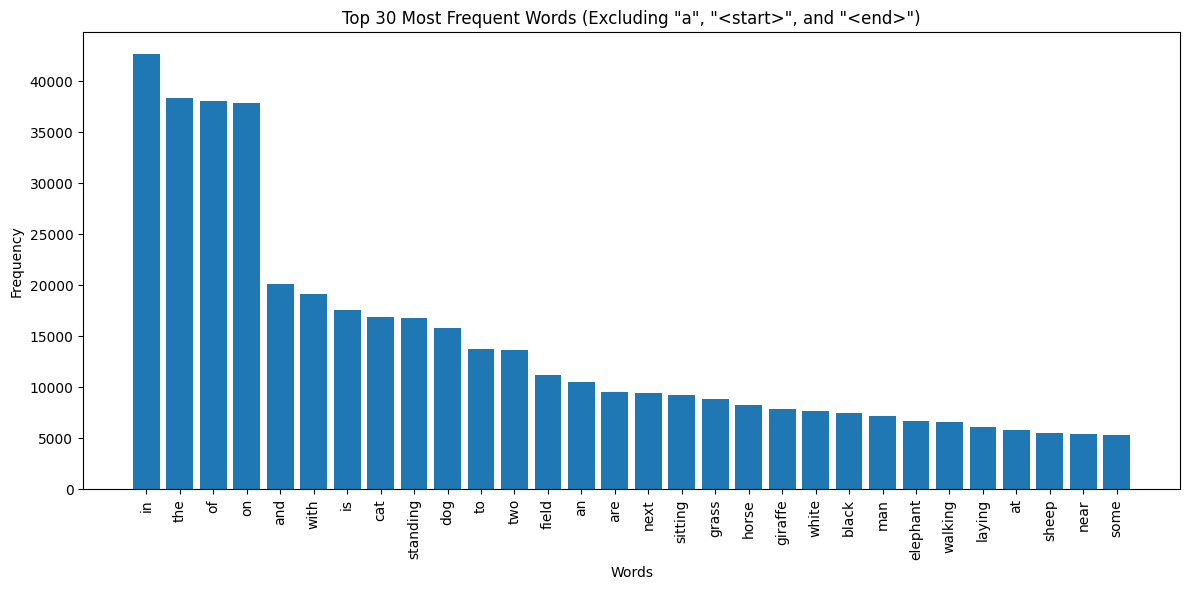

In [ ]:
# plot top 30 words in the corpus

from collections import Counter

# Split the flattened list into words and remove 'a', '<start>', and '<end>'
flatten_list = list(chain.from_iterable(url_caps.values()))
words = [word for word in (' '.join(flatten_list)).split() if word not in ['a', '<start>', '<end>']]

# Count the frequency of each word
word_counts = Counter(words)

# Get the top 30 most frequent words
top_30_words = word_counts.most_common(30)

# Extract the words and their counts for plotting
words, counts = zip(*top_30_words)

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(words, counts)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 30 Most Frequent Words (Excluding "a", "<start>", and "<end>")')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
def data_generator(descriptions, features, tokenizer, max_length, total_words):
    while 1:
      for key, description_list in descriptions.items():
        feature = features[key][0]
        input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature, total_words)
        yield ([input_image, input_sequence], output_word)


def create_sequences(tokenizer, max_length, desc_list, feature, total_words):
    X1, X2, y = list(), list(), list()

    # walk through each description for the image
    for desc in desc_list:

        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]

        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):

            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]

            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]

            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=total_words)[0]

            # store
            X1.append(feature) # image features
            X2.append(in_seq)  # Caption input
            y.append(out_seq)  # Caption output

    return np.array(X1), np.array(X2), np.array(y)

In [ ]:
# testing shapes
[X1, X2], y = next (data_generator(url_caps, xception_features, tokenizer, max_length, total_words))
X1.shape, X2.shape, y.shape

((60, 2048), (60, 51), (60, 10497))

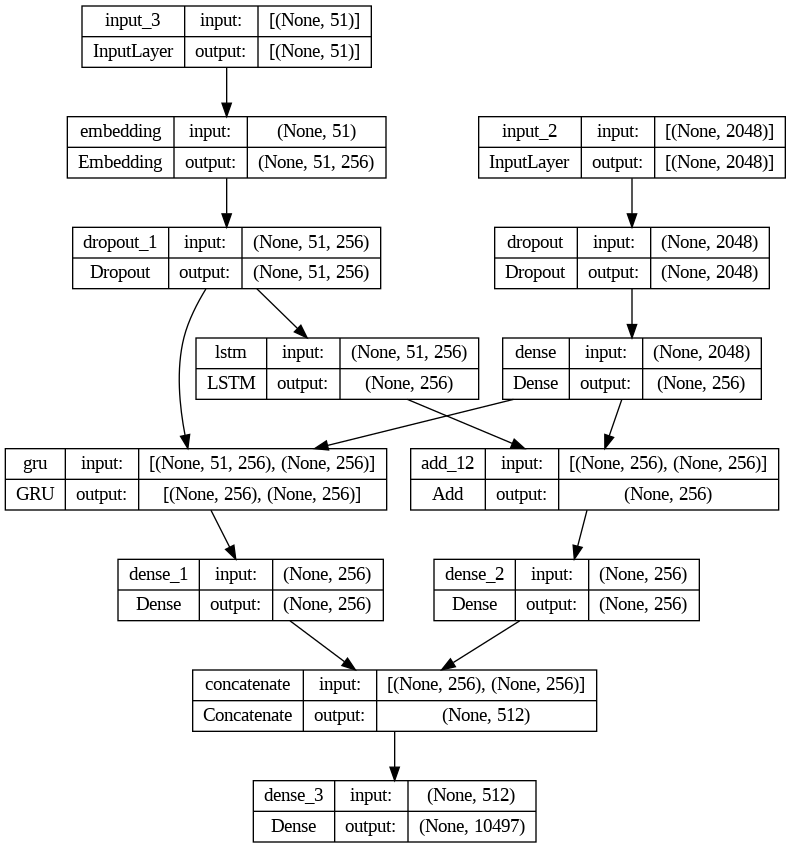

In [ ]:
def hybrid_model(total_words, max_length):

    inputs1 = Input(shape=(2048,))
    img1 = Dropout(0.5)(inputs1)
    img2 = Dense(256, activation='relu')(img1)

    inputs2 = Input(shape=(max_length,))
    seq1 = Embedding(total_words, 256, mask_zero=True)(inputs2)
    seq2 = Dropout(0.5)(seq1)

    #image is set as state
    seq3,state = GRU(256,return_state = True)(seq2,initial_state = img2)

    dec1 = Dense(256, activation='relu')(seq3)

    # Merging image and input
    seq4 = LSTM(256)(seq2)
    dec2 = add([img2, seq4])
    dec3 = Dense(256, activation='relu')(dec2)
    dec4 = concatenate([dec1, dec3])

    outputs = Dense(total_words, activation='softmax')(dec4)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    #set embedding layer's weight matrix
    #model.layers[2].set_weights([embedding_matrix])
    #model.layers[2].trainable = True

    return model
hybrid = hybrid_model(total_words, max_length)
plot_model(hybrid, show_shapes=True)

In [ ]:
# train the model  model
print('Dataset: ', len(url_caps))
print('Train length=', len(url_caps))
print('Vocabulary Size:', total_words)
print('Description Length: ', max_length)

epochs = 3
steps = len(url_caps)
#steps = len(url_caps_train
#batch_size = 32

model = hybrid_model(total_words, max_length)
#steps_per_epoch = len(url_caps_train) // batch_size
#validatation_steps = len(url_caps_val)

for i in range (epochs):
  train_generator = data_generator(url_caps, xception_features, tokenizer, max_length, total_words)
  #validation_generator = data_generator(url_caps_val, xception_features_val, tokenizer, max_length, total_words)
  model.fit(train_generator, epochs=3, steps_per_epoch= steps, verbose=1)
  model.save(data_path+'/model_exp3' + str(i) + '.h5')


#for i in range(9,11):
#
#    train_generator = data_generator(url_caps_train, xception_features_train, tokenizer, max_length, total_words, batch_size=batch_size)
#    validation_generator = data_generator(url_caps_val, xception_features_val, tokenizer, max_length, total_words, batch_size=batch_size)
#    model.fit(train_generator, epochs=i, steps_per_epoch= steps_per_epoch, validation_data = validation_generator, validation_steps =validatation_steps)
#    model.save(data_path+'/model_test_' + str(i) + '.h5')

Dataset:  21330
Train length= 21330
Vocabulary Size: 10497
Description Length:  51
Epoch 1/3
21330/21330 [==============================] - 3262s 153ms/step - loss: 3.0300
Epoch 2/3
21330/21330 [==============================] - 3243s 152ms/step - loss: 2.6626
Epoch 3/3
21330/21330 [==============================] - 3241s 152ms/step - loss: 2.5978


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/3
21330/21330 [==============================] - 3237s 152ms/step - loss: 2.5786
Epoch 2/3
21330/21330 [==============================] - 3238s 152ms/step - loss: 2.5749
Epoch 3/3
21330/21330 [==============================] - 3236s 152ms/step - loss: 2.5756
Epoch 1/3
19102/21330 [=========================>....] - ETA: 5:38 - loss: 2.5772

In [ ]:
### val data

val_coco = COCO(data_path + "/annotations/instances_val2017.json")
val_coco_caps = COCO(data_path + "/annotations/captions_val2017.json")

val_cat = get_cat(val_coco)

val_cat_catId = get_catCatId(val_coco, val_cat)

val_cat_imgId = get_cat_imgId(val_coco, val_cat_catId)

val_cats = val_cat_imgId['giraffe'] + val_cat_imgId['elephant'] + val_cat_imgId['cat'] + val_cat_imgId['dog'] + val_cat_imgId['horse'] + val_cat_imgId['sheep'] + val_cat_imgId['cow']  + val_cat_imgId['bear'] + val_cat_imgId['zebra']  #+ val_cat_imgId['bird']

imgIds = coco.getImgIds(imgIds = val_cats)

val_url_caps = generate_url_caps(imgIds, val_coco, val_coco_caps)

loading annotations into memory...
Done (t=1.28s)
creating index...
index created!
loading annotations into memory...
Done (t=0.54s)
creating index...
index created!


In [ ]:
val_xception_features = extract_xception_features(model_xception, val_url_caps)

  0%|          | 0/913 [00:00<?, ?it/s]

1/1 [==============================] - 1s 843ms/step


  0%|          | 1/913 [00:01<18:38,  1.23s/it]

1/1 [==============================] - 0s 104ms/step


  0%|          | 2/913 [00:01<10:59,  1.38it/s]

1/1 [==============================] - 0s 100ms/step


  0%|          | 3/913 [00:02<08:57,  1.69it/s]

1/1 [==============================] - 0s 97ms/step


  0%|          | 4/913 [00:02<07:39,  1.98it/s]

1/1 [==============================] - 0s 100ms/step


  1%|          | 5/913 [00:02<07:00,  2.16it/s]

1/1 [==============================] - 0s 103ms/step


  1%|          | 6/913 [00:03<06:38,  2.28it/s]

1/1 [==============================] - 0s 100ms/step


  1%|          | 7/913 [00:03<06:36,  2.28it/s]

1/1 [==============================] - 0s 100ms/step


  1%|          | 8/913 [00:03<06:18,  2.39it/s]

1/1 [==============================] - 0s 101ms/step


  1%|          | 9/913 [00:04<06:21,  2.37it/s]

1/1 [==============================] - 0s 96ms/step


  1%|          | 10/913 [00:04<06:14,  2.41it/s]

1/1 [==============================] - 0s 102ms/step


  1%|          | 11/913 [00:05<06:22,  2.36it/s]

1/1 [==============================] - 0s 99ms/step


  1%|▏         | 12/913 [00:05<06:44,  2.23it/s]

1/1 [==============================] - 0s 98ms/step


  1%|▏         | 13/913 [00:06<06:15,  2.40it/s]

1/1 [==============================] - 0s 100ms/step


  2%|▏         | 14/913 [00:06<06:01,  2.49it/s]

1/1 [==============================] - 0s 98ms/step


  2%|▏         | 15/913 [00:06<06:02,  2.48it/s]

1/1 [==============================] - 0s 93ms/step


  2%|▏         | 16/913 [00:07<06:13,  2.40it/s]

1/1 [==============================] - 0s 98ms/step


  2%|▏         | 17/913 [00:07<05:41,  2.63it/s]

1/1 [==============================] - 0s 97ms/step


  2%|▏         | 18/913 [00:08<05:46,  2.58it/s]

1/1 [==============================] - 0s 95ms/step


  2%|▏         | 19/913 [00:08<05:44,  2.60it/s]

1/1 [==============================] - 0s 97ms/step


  2%|▏         | 20/913 [00:08<05:43,  2.60it/s]

1/1 [==============================] - 0s 99ms/step


  2%|▏         | 21/913 [00:09<05:38,  2.64it/s]

1/1 [==============================] - 0s 95ms/step


  2%|▏         | 22/913 [00:09<05:39,  2.63it/s]

1/1 [==============================] - 0s 94ms/step


  3%|▎         | 23/913 [00:09<05:41,  2.61it/s]

1/1 [==============================] - 0s 94ms/step


  3%|▎         | 24/913 [00:10<05:58,  2.48it/s]

1/1 [==============================] - 0s 92ms/step


  3%|▎         | 25/913 [00:10<06:09,  2.40it/s]

1/1 [==============================] - 0s 95ms/step


  3%|▎         | 26/913 [00:11<06:00,  2.46it/s]

1/1 [==============================] - 0s 88ms/step


  3%|▎         | 27/913 [00:11<05:51,  2.52it/s]

1/1 [==============================] - 0s 95ms/step


  3%|▎         | 28/913 [00:11<05:48,  2.54it/s]

1/1 [==============================] - 0s 93ms/step


  3%|▎         | 29/913 [00:12<05:54,  2.49it/s]

1/1 [==============================] - 0s 90ms/step


  3%|▎         | 30/913 [00:12<06:03,  2.43it/s]

1/1 [==============================] - 0s 88ms/step


  3%|▎         | 31/913 [00:13<05:53,  2.50it/s]

1/1 [==============================] - 0s 93ms/step


  4%|▎         | 32/913 [00:13<06:05,  2.41it/s]

1/1 [==============================] - 0s 93ms/step


  4%|▎         | 33/913 [00:14<06:03,  2.42it/s]

1/1 [==============================] - 0s 93ms/step


  4%|▎         | 34/913 [00:14<05:59,  2.45it/s]

1/1 [==============================] - 0s 93ms/step


  4%|▍         | 35/913 [00:14<06:15,  2.34it/s]

1/1 [==============================] - 0s 91ms/step


  4%|▍         | 36/913 [00:15<06:13,  2.35it/s]

1/1 [==============================] - 0s 89ms/step


  4%|▍         | 37/913 [00:15<06:03,  2.41it/s]

1/1 [==============================] - 0s 96ms/step


  4%|▍         | 38/913 [00:16<05:51,  2.49it/s]

1/1 [==============================] - 0s 93ms/step


  4%|▍         | 39/913 [00:16<05:56,  2.45it/s]

1/1 [==============================] - 0s 96ms/step


  4%|▍         | 40/913 [00:16<05:48,  2.51it/s]

1/1 [==============================] - 0s 90ms/step


  4%|▍         | 41/913 [00:17<05:47,  2.51it/s]

1/1 [==============================] - 0s 92ms/step


  5%|▍         | 42/913 [00:17<05:37,  2.58it/s]

1/1 [==============================] - 0s 94ms/step


  5%|▍         | 43/913 [00:18<05:34,  2.60it/s]

1/1 [==============================] - 0s 92ms/step


  5%|▍         | 44/913 [00:18<05:40,  2.55it/s]

1/1 [==============================] - 0s 94ms/step


  5%|▍         | 45/913 [00:18<06:03,  2.39it/s]

1/1 [==============================] - 0s 93ms/step


  5%|▌         | 46/913 [00:19<05:53,  2.46it/s]

1/1 [==============================] - 0s 90ms/step


  5%|▌         | 47/913 [00:19<05:47,  2.49it/s]

1/1 [==============================] - 0s 89ms/step


  5%|▌         | 48/913 [00:20<05:44,  2.51it/s]

1/1 [==============================] - 0s 92ms/step


  5%|▌         | 49/913 [00:20<05:38,  2.55it/s]

1/1 [==============================] - 0s 91ms/step


  5%|▌         | 50/913 [00:20<05:33,  2.59it/s]

1/1 [==============================] - 0s 88ms/step


  6%|▌         | 51/913 [00:21<05:25,  2.65it/s]

1/1 [==============================] - 0s 87ms/step


  6%|▌         | 52/913 [00:21<05:41,  2.52it/s]

1/1 [==============================] - 0s 91ms/step


  6%|▌         | 53/913 [00:22<05:40,  2.53it/s]

1/1 [==============================] - 0s 88ms/step


  6%|▌         | 54/913 [00:22<05:41,  2.52it/s]

1/1 [==============================] - 0s 90ms/step


  6%|▌         | 55/913 [00:22<05:28,  2.61it/s]

1/1 [==============================] - 0s 92ms/step


  6%|▌         | 56/913 [00:23<05:18,  2.69it/s]

1/1 [==============================] - 0s 91ms/step


  6%|▌         | 57/913 [00:23<06:16,  2.28it/s]

1/1 [==============================] - 0s 91ms/step


  6%|▋         | 58/913 [00:24<06:01,  2.36it/s]

1/1 [==============================] - 0s 93ms/step


  6%|▋         | 59/913 [00:24<05:53,  2.41it/s]

1/1 [==============================] - 0s 93ms/step


  7%|▋         | 60/913 [00:24<05:54,  2.40it/s]

1/1 [==============================] - 0s 90ms/step


  7%|▋         | 61/913 [00:25<05:54,  2.40it/s]

1/1 [==============================] - 0s 90ms/step


  7%|▋         | 62/913 [00:25<05:29,  2.58it/s]

1/1 [==============================] - 0s 91ms/step


  7%|▋         | 63/913 [00:26<05:24,  2.62it/s]

1/1 [==============================] - 0s 94ms/step


  7%|▋         | 64/913 [00:26<05:20,  2.65it/s]

1/1 [==============================] - 0s 93ms/step


  7%|▋         | 65/913 [00:26<05:23,  2.62it/s]

1/1 [==============================] - 0s 93ms/step


  7%|▋         | 66/913 [00:27<05:16,  2.68it/s]

1/1 [==============================] - 0s 95ms/step


  7%|▋         | 67/913 [00:27<05:22,  2.63it/s]

1/1 [==============================] - 0s 91ms/step


  7%|▋         | 68/913 [00:27<05:15,  2.68it/s]

1/1 [==============================] - 0s 91ms/step


  8%|▊         | 69/913 [00:28<05:13,  2.69it/s]

1/1 [==============================] - 0s 91ms/step


  8%|▊         | 70/913 [00:28<05:13,  2.69it/s]

1/1 [==============================] - 0s 89ms/step


  8%|▊         | 71/913 [00:29<05:27,  2.57it/s]

1/1 [==============================] - 0s 91ms/step


  8%|▊         | 72/913 [00:29<05:25,  2.58it/s]

1/1 [==============================] - 0s 94ms/step


  8%|▊         | 73/913 [00:29<05:16,  2.65it/s]

1/1 [==============================] - 0s 89ms/step


  8%|▊         | 74/913 [00:30<05:18,  2.63it/s]

1/1 [==============================] - 0s 94ms/step


  8%|▊         | 75/913 [00:30<05:37,  2.49it/s]

1/1 [==============================] - 0s 93ms/step


  8%|▊         | 76/913 [00:31<05:36,  2.49it/s]

1/1 [==============================] - 0s 97ms/step


  8%|▊         | 77/913 [00:31<06:13,  2.24it/s]

1/1 [==============================] - 0s 93ms/step


  9%|▊         | 78/913 [00:32<06:09,  2.26it/s]

1/1 [==============================] - 0s 90ms/step


  9%|▊         | 79/913 [00:32<06:05,  2.28it/s]

1/1 [==============================] - 0s 93ms/step


  9%|▉         | 80/913 [00:32<05:46,  2.40it/s]

1/1 [==============================] - 0s 94ms/step


  9%|▉         | 81/913 [00:33<05:36,  2.47it/s]

1/1 [==============================] - 0s 93ms/step


  9%|▉         | 82/913 [00:33<05:25,  2.55it/s]

1/1 [==============================] - 0s 95ms/step


  9%|▉         | 83/913 [00:33<05:20,  2.59it/s]

1/1 [==============================] - 0s 98ms/step


  9%|▉         | 84/913 [00:34<05:28,  2.52it/s]

1/1 [==============================] - 0s 92ms/step


  9%|▉         | 85/913 [00:34<05:26,  2.54it/s]

1/1 [==============================] - 0s 89ms/step


  9%|▉         | 86/913 [00:35<05:20,  2.58it/s]

1/1 [==============================] - 0s 90ms/step


 10%|▉         | 87/913 [00:35<05:30,  2.50it/s]

1/1 [==============================] - 0s 89ms/step


 10%|▉         | 88/913 [00:35<05:05,  2.70it/s]

1/1 [==============================] - 0s 96ms/step


 10%|▉         | 89/913 [00:36<05:10,  2.65it/s]

1/1 [==============================] - 0s 98ms/step


 10%|▉         | 90/913 [00:36<05:22,  2.56it/s]

1/1 [==============================] - 0s 93ms/step


 10%|▉         | 91/913 [00:37<05:17,  2.59it/s]

1/1 [==============================] - 0s 91ms/step


 10%|█         | 92/913 [00:37<05:11,  2.64it/s]

1/1 [==============================] - 0s 90ms/step


 10%|█         | 93/913 [00:37<05:18,  2.58it/s]

1/1 [==============================] - 0s 92ms/step


 10%|█         | 94/913 [00:38<05:35,  2.44it/s]

1/1 [==============================] - 0s 91ms/step


 10%|█         | 95/913 [00:38<05:27,  2.50it/s]

1/1 [==============================] - 0s 92ms/step


 11%|█         | 96/913 [00:39<05:22,  2.53it/s]

1/1 [==============================] - 0s 90ms/step


 11%|█         | 97/913 [00:39<05:27,  2.49it/s]

1/1 [==============================] - 0s 94ms/step


 11%|█         | 98/913 [00:39<05:35,  2.43it/s]

1/1 [==============================] - 0s 91ms/step


 11%|█         | 99/913 [00:40<05:41,  2.39it/s]

1/1 [==============================] - 0s 90ms/step


 11%|█         | 100/913 [00:40<05:32,  2.44it/s]

1/1 [==============================] - 0s 89ms/step


 11%|█         | 101/913 [00:41<05:24,  2.50it/s]

1/1 [==============================] - 0s 88ms/step


 11%|█         | 102/913 [00:41<05:26,  2.48it/s]

1/1 [==============================] - 0s 87ms/step


 11%|█▏        | 103/913 [00:41<05:14,  2.57it/s]

1/1 [==============================] - 0s 90ms/step


 11%|█▏        | 104/913 [00:42<05:24,  2.49it/s]

1/1 [==============================] - 0s 96ms/step


 12%|█▏        | 105/913 [00:42<05:21,  2.52it/s]

1/1 [==============================] - 0s 90ms/step


 12%|█▏        | 106/913 [00:43<05:31,  2.44it/s]

1/1 [==============================] - 0s 95ms/step


 12%|█▏        | 107/913 [00:43<05:30,  2.44it/s]

1/1 [==============================] - 0s 90ms/step


 12%|█▏        | 108/913 [00:43<05:29,  2.44it/s]

1/1 [==============================] - 0s 88ms/step


 12%|█▏        | 109/913 [00:44<05:22,  2.49it/s]

1/1 [==============================] - 0s 92ms/step


 12%|█▏        | 110/913 [00:44<05:11,  2.58it/s]

1/1 [==============================] - 0s 88ms/step


 12%|█▏        | 111/913 [00:45<05:22,  2.48it/s]

1/1 [==============================] - 0s 88ms/step


 12%|█▏        | 112/913 [00:45<05:11,  2.57it/s]

1/1 [==============================] - 0s 90ms/step


 12%|█▏        | 113/913 [00:45<04:54,  2.72it/s]

1/1 [==============================] - 0s 92ms/step


 12%|█▏        | 114/913 [00:46<04:52,  2.73it/s]

1/1 [==============================] - 0s 90ms/step


 13%|█▎        | 115/913 [00:46<04:58,  2.67it/s]

1/1 [==============================] - 0s 90ms/step


 13%|█▎        | 116/913 [00:46<04:52,  2.73it/s]

1/1 [==============================] - 0s 89ms/step


 13%|█▎        | 117/913 [00:47<05:01,  2.64it/s]

1/1 [==============================] - 0s 91ms/step


 13%|█▎        | 118/913 [00:47<05:02,  2.63it/s]

1/1 [==============================] - 0s 90ms/step


 13%|█▎        | 119/913 [00:48<05:05,  2.60it/s]

1/1 [==============================] - 0s 88ms/step


 13%|█▎        | 120/913 [00:48<05:09,  2.56it/s]

1/1 [==============================] - 0s 87ms/step


 13%|█▎        | 121/913 [00:48<05:15,  2.51it/s]

1/1 [==============================] - 0s 86ms/step


 13%|█▎        | 122/913 [00:49<05:12,  2.53it/s]

1/1 [==============================] - 0s 87ms/step


 13%|█▎        | 123/913 [00:49<05:20,  2.46it/s]

1/1 [==============================] - 0s 86ms/step


 14%|█▎        | 124/913 [00:50<05:19,  2.47it/s]

1/1 [==============================] - 0s 91ms/step


 14%|█▎        | 125/913 [00:50<05:19,  2.47it/s]

1/1 [==============================] - 0s 90ms/step


 14%|█▍        | 126/913 [00:50<05:19,  2.47it/s]

1/1 [==============================] - 0s 89ms/step


 14%|█▍        | 127/913 [00:51<04:59,  2.63it/s]

1/1 [==============================] - 0s 90ms/step


 14%|█▍        | 128/913 [00:51<04:55,  2.66it/s]

1/1 [==============================] - 0s 90ms/step


 14%|█▍        | 129/913 [00:52<05:09,  2.53it/s]

1/1 [==============================] - 0s 90ms/step


 14%|█▍        | 130/913 [00:52<05:00,  2.61it/s]

1/1 [==============================] - 0s 89ms/step


 14%|█▍        | 131/913 [00:52<05:05,  2.56it/s]

1/1 [==============================] - 0s 89ms/step


 14%|█▍        | 132/913 [00:53<05:07,  2.54it/s]

1/1 [==============================] - 0s 91ms/step


 15%|█▍        | 133/913 [00:53<05:17,  2.46it/s]

1/1 [==============================] - 0s 88ms/step


 15%|█▍        | 134/913 [00:54<05:15,  2.47it/s]

1/1 [==============================] - 0s 92ms/step


 15%|█▍        | 135/913 [00:54<05:15,  2.46it/s]

1/1 [==============================] - 0s 88ms/step


 15%|█▍        | 136/913 [00:54<05:03,  2.56it/s]

1/1 [==============================] - 0s 88ms/step


 15%|█▌        | 137/913 [00:55<05:00,  2.58it/s]

1/1 [==============================] - 0s 86ms/step


 15%|█▌        | 138/913 [00:55<04:58,  2.60it/s]

1/1 [==============================] - 0s 87ms/step


 15%|█▌        | 139/913 [00:55<04:49,  2.67it/s]

1/1 [==============================] - 0s 89ms/step


 15%|█▌        | 140/913 [00:56<04:41,  2.74it/s]

1/1 [==============================] - 0s 88ms/step


 15%|█▌        | 141/913 [00:56<04:36,  2.79it/s]

1/1 [==============================] - 0s 90ms/step


 16%|█▌        | 142/913 [00:57<04:40,  2.75it/s]

1/1 [==============================] - 0s 89ms/step


 16%|█▌        | 143/913 [00:57<04:42,  2.73it/s]

1/1 [==============================] - 0s 88ms/step


 16%|█▌        | 144/913 [00:57<04:50,  2.65it/s]

1/1 [==============================] - 0s 92ms/step


 16%|█▌        | 145/913 [00:58<04:54,  2.61it/s]

1/1 [==============================] - 0s 96ms/step


 16%|█▌        | 146/913 [00:58<05:23,  2.37it/s]

1/1 [==============================] - 0s 88ms/step


 16%|█▌        | 147/913 [00:59<05:33,  2.30it/s]

1/1 [==============================] - 0s 88ms/step


 16%|█▌        | 148/913 [00:59<05:41,  2.24it/s]

1/1 [==============================] - 0s 93ms/step


 16%|█▋        | 149/913 [00:59<05:23,  2.36it/s]

1/1 [==============================] - 0s 93ms/step


 16%|█▋        | 150/913 [01:00<05:05,  2.50it/s]

1/1 [==============================] - 0s 94ms/step


 17%|█▋        | 151/913 [01:00<05:18,  2.39it/s]

1/1 [==============================] - 0s 91ms/step


 17%|█▋        | 152/913 [01:01<05:18,  2.39it/s]

1/1 [==============================] - 0s 87ms/step


 17%|█▋        | 153/913 [01:01<05:17,  2.39it/s]

1/1 [==============================] - 0s 92ms/step


 17%|█▋        | 154/913 [01:02<05:11,  2.44it/s]

1/1 [==============================] - 0s 90ms/step


 17%|█▋        | 155/913 [01:02<05:53,  2.15it/s]

1/1 [==============================] - 0s 91ms/step


 17%|█▋        | 156/913 [01:03<05:32,  2.28it/s]

1/1 [==============================] - 0s 89ms/step


 17%|█▋        | 157/913 [01:03<05:43,  2.20it/s]

1/1 [==============================] - 0s 91ms/step


 17%|█▋        | 158/913 [01:03<05:29,  2.29it/s]

1/1 [==============================] - 0s 88ms/step


 17%|█▋        | 159/913 [01:04<05:13,  2.40it/s]

1/1 [==============================] - 0s 93ms/step


 18%|█▊        | 160/913 [01:04<04:58,  2.52it/s]

1/1 [==============================] - 0s 89ms/step


 18%|█▊        | 161/913 [01:05<05:02,  2.49it/s]

1/1 [==============================] - 0s 93ms/step


 18%|█▊        | 162/913 [01:05<04:57,  2.52it/s]

1/1 [==============================] - 0s 93ms/step


 18%|█▊        | 163/913 [01:05<05:08,  2.43it/s]

1/1 [==============================] - 0s 88ms/step


 18%|█▊        | 164/913 [01:06<04:54,  2.54it/s]

1/1 [==============================] - 0s 89ms/step


 18%|█▊        | 165/913 [01:06<04:48,  2.59it/s]

1/1 [==============================] - 0s 90ms/step


 18%|█▊        | 166/913 [01:06<04:50,  2.57it/s]

1/1 [==============================] - 0s 91ms/step


 18%|█▊        | 167/913 [01:07<04:46,  2.61it/s]

1/1 [==============================] - 0s 90ms/step


 18%|█▊        | 168/913 [01:07<04:44,  2.62it/s]

1/1 [==============================] - 0s 91ms/step


 19%|█▊        | 169/913 [01:08<04:50,  2.56it/s]

1/1 [==============================] - 0s 88ms/step


 19%|█▊        | 170/913 [01:08<05:06,  2.42it/s]

1/1 [==============================] - 0s 90ms/step


 19%|█▊        | 171/913 [01:08<04:59,  2.47it/s]

1/1 [==============================] - 0s 94ms/step


 19%|█▉        | 172/913 [01:09<04:53,  2.52it/s]

1/1 [==============================] - 0s 95ms/step


 19%|█▉        | 173/913 [01:09<04:46,  2.58it/s]

1/1 [==============================] - 0s 93ms/step


 19%|█▉        | 174/913 [01:10<04:45,  2.59it/s]

1/1 [==============================] - 0s 90ms/step


 19%|█▉        | 175/913 [01:10<04:49,  2.55it/s]

1/1 [==============================] - 0s 90ms/step


 19%|█▉        | 176/913 [01:10<04:42,  2.61it/s]

1/1 [==============================] - 0s 91ms/step


 19%|█▉        | 177/913 [01:11<04:42,  2.60it/s]

1/1 [==============================] - 0s 92ms/step


 19%|█▉        | 178/913 [01:11<04:46,  2.57it/s]

1/1 [==============================] - 0s 91ms/step


 20%|█▉        | 179/913 [01:12<04:50,  2.53it/s]

1/1 [==============================] - 0s 95ms/step


 20%|█▉        | 180/913 [01:12<04:46,  2.56it/s]

1/1 [==============================] - 0s 95ms/step


 20%|█▉        | 181/913 [01:12<04:43,  2.58it/s]

1/1 [==============================] - 0s 96ms/step


 20%|█▉        | 182/913 [01:13<04:36,  2.64it/s]

1/1 [==============================] - 0s 93ms/step


 20%|██        | 183/913 [01:13<04:54,  2.48it/s]

1/1 [==============================] - 0s 95ms/step


 20%|██        | 184/913 [01:14<04:49,  2.52it/s]

1/1 [==============================] - 0s 96ms/step


 20%|██        | 185/913 [01:14<05:03,  2.39it/s]

1/1 [==============================] - 0s 93ms/step


 20%|██        | 186/913 [01:14<05:03,  2.40it/s]

1/1 [==============================] - 0s 91ms/step


 20%|██        | 187/913 [01:15<04:54,  2.47it/s]

1/1 [==============================] - 0s 95ms/step


 21%|██        | 188/913 [01:15<04:57,  2.43it/s]

1/1 [==============================] - 0s 94ms/step


 21%|██        | 189/913 [01:16<04:58,  2.43it/s]

1/1 [==============================] - 0s 94ms/step


 21%|██        | 190/913 [01:16<04:59,  2.42it/s]

1/1 [==============================] - 0s 97ms/step


 21%|██        | 191/913 [01:16<05:02,  2.39it/s]

1/1 [==============================] - 0s 94ms/step


 21%|██        | 192/913 [01:17<05:00,  2.40it/s]

1/1 [==============================] - 0s 94ms/step


 21%|██        | 193/913 [01:17<04:48,  2.50it/s]

1/1 [==============================] - 0s 91ms/step


 21%|██        | 194/913 [01:18<04:49,  2.48it/s]

1/1 [==============================] - 0s 88ms/step


 21%|██▏       | 195/913 [01:18<04:52,  2.45it/s]

1/1 [==============================] - 0s 90ms/step


 21%|██▏       | 196/913 [01:19<04:57,  2.41it/s]

1/1 [==============================] - 0s 92ms/step


 22%|██▏       | 197/913 [01:19<04:55,  2.42it/s]

1/1 [==============================] - 0s 93ms/step


 22%|██▏       | 198/913 [01:19<04:47,  2.49it/s]

1/1 [==============================] - 0s 92ms/step


 22%|██▏       | 199/913 [01:20<04:36,  2.58it/s]

1/1 [==============================] - 0s 93ms/step


 22%|██▏       | 200/913 [01:20<04:29,  2.65it/s]

1/1 [==============================] - 0s 93ms/step


 22%|██▏       | 201/913 [01:20<04:45,  2.50it/s]

1/1 [==============================] - 0s 88ms/step


 22%|██▏       | 202/913 [01:21<04:48,  2.46it/s]

1/1 [==============================] - 0s 90ms/step


 22%|██▏       | 203/913 [01:21<04:54,  2.41it/s]

1/1 [==============================] - 0s 91ms/step


 22%|██▏       | 204/913 [01:22<04:54,  2.41it/s]

1/1 [==============================] - 0s 93ms/step


 22%|██▏       | 205/913 [01:22<04:49,  2.44it/s]

1/1 [==============================] - 0s 91ms/step


 23%|██▎       | 206/913 [01:23<04:42,  2.51it/s]

1/1 [==============================] - 0s 91ms/step


 23%|██▎       | 207/913 [01:23<04:37,  2.54it/s]

1/1 [==============================] - 0s 91ms/step


 23%|██▎       | 208/913 [01:23<04:33,  2.58it/s]

1/1 [==============================] - 0s 92ms/step


 23%|██▎       | 209/913 [01:24<04:30,  2.60it/s]

1/1 [==============================] - 0s 90ms/step


 23%|██▎       | 210/913 [01:24<04:29,  2.60it/s]

1/1 [==============================] - 0s 91ms/step


 23%|██▎       | 211/913 [01:24<04:30,  2.60it/s]

1/1 [==============================] - 0s 89ms/step


 23%|██▎       | 212/913 [01:25<04:25,  2.64it/s]

1/1 [==============================] - 0s 89ms/step


 23%|██▎       | 213/913 [01:25<04:19,  2.69it/s]

1/1 [==============================] - 0s 88ms/step


 23%|██▎       | 214/913 [01:25<04:16,  2.72it/s]

1/1 [==============================] - 0s 87ms/step


 24%|██▎       | 215/913 [01:26<04:13,  2.75it/s]

1/1 [==============================] - 0s 87ms/step


 24%|██▎       | 216/913 [01:26<03:58,  2.93it/s]

1/1 [==============================] - 0s 89ms/step


 24%|██▍       | 217/913 [01:27<04:12,  2.76it/s]

1/1 [==============================] - 0s 87ms/step


 24%|██▍       | 218/913 [01:27<04:08,  2.79it/s]

1/1 [==============================] - 0s 87ms/step


 24%|██▍       | 219/913 [01:27<04:14,  2.72it/s]

1/1 [==============================] - 0s 91ms/step


 24%|██▍       | 220/913 [01:28<04:24,  2.62it/s]

1/1 [==============================] - 0s 90ms/step


 24%|██▍       | 221/913 [01:28<04:32,  2.54it/s]

1/1 [==============================] - 0s 91ms/step


 24%|██▍       | 222/913 [01:28<04:26,  2.59it/s]

1/1 [==============================] - 0s 94ms/step


 24%|██▍       | 223/913 [01:29<04:29,  2.57it/s]

1/1 [==============================] - 0s 92ms/step


 25%|██▍       | 224/913 [01:29<04:29,  2.56it/s]

1/1 [==============================] - 0s 93ms/step


 25%|██▍       | 225/913 [01:30<04:32,  2.52it/s]

1/1 [==============================] - 0s 93ms/step


 25%|██▍       | 226/913 [01:30<04:06,  2.78it/s]

1/1 [==============================] - 0s 89ms/step


 25%|██▍       | 227/913 [01:30<04:11,  2.72it/s]

1/1 [==============================] - 0s 88ms/step


 25%|██▍       | 228/913 [01:31<04:29,  2.54it/s]

1/1 [==============================] - 0s 90ms/step


 25%|██▌       | 229/913 [01:31<05:13,  2.18it/s]

1/1 [==============================] - 0s 87ms/step


 25%|██▌       | 230/913 [01:32<04:51,  2.34it/s]

1/1 [==============================] - 0s 93ms/step


 25%|██▌       | 231/913 [01:32<04:44,  2.40it/s]

1/1 [==============================] - 0s 93ms/step


 25%|██▌       | 232/913 [01:33<04:38,  2.44it/s]

1/1 [==============================] - 0s 95ms/step


 26%|██▌       | 233/913 [01:33<05:08,  2.21it/s]

1/1 [==============================] - 0s 95ms/step


 26%|██▌       | 234/913 [01:34<05:44,  1.97it/s]

1/1 [==============================] - 0s 94ms/step


 26%|██▌       | 235/913 [01:34<05:17,  2.13it/s]

1/1 [==============================] - 0s 98ms/step


 26%|██▌       | 236/913 [01:34<05:00,  2.25it/s]

1/1 [==============================] - 0s 94ms/step


 26%|██▌       | 237/913 [01:35<05:07,  2.20it/s]

1/1 [==============================] - 0s 90ms/step


 26%|██▌       | 238/913 [01:35<05:07,  2.20it/s]

1/1 [==============================] - 0s 87ms/step


 26%|██▌       | 239/913 [01:36<04:57,  2.27it/s]

1/1 [==============================] - 0s 93ms/step


 26%|██▋       | 240/913 [01:36<04:47,  2.34it/s]

1/1 [==============================] - 0s 92ms/step


 26%|██▋       | 241/913 [01:37<04:45,  2.36it/s]

1/1 [==============================] - 0s 96ms/step


 27%|██▋       | 242/913 [01:37<04:54,  2.28it/s]

1/1 [==============================] - 0s 92ms/step


 27%|██▋       | 243/913 [01:38<04:42,  2.37it/s]

1/1 [==============================] - 0s 91ms/step


 27%|██▋       | 244/913 [01:38<04:49,  2.31it/s]

1/1 [==============================] - 0s 92ms/step


 27%|██▋       | 245/913 [01:38<04:35,  2.43it/s]

1/1 [==============================] - 0s 92ms/step


 27%|██▋       | 246/913 [01:39<04:32,  2.45it/s]

1/1 [==============================] - 0s 89ms/step


 27%|██▋       | 247/913 [01:39<04:28,  2.48it/s]

1/1 [==============================] - 0s 88ms/step


 27%|██▋       | 248/913 [01:40<04:33,  2.43it/s]

1/1 [==============================] - 0s 91ms/step


 27%|██▋       | 249/913 [01:40<04:36,  2.40it/s]

1/1 [==============================] - 0s 91ms/step


 27%|██▋       | 250/913 [01:40<04:23,  2.51it/s]

1/1 [==============================] - 0s 92ms/step


 27%|██▋       | 251/913 [01:41<04:32,  2.43it/s]

1/1 [==============================] - 0s 89ms/step


 28%|██▊       | 252/913 [01:41<04:28,  2.46it/s]

1/1 [==============================] - 0s 88ms/step


 28%|██▊       | 253/913 [01:42<04:19,  2.54it/s]

1/1 [==============================] - 0s 92ms/step


 28%|██▊       | 254/913 [01:42<04:12,  2.61it/s]

1/1 [==============================] - 0s 88ms/step


 28%|██▊       | 255/913 [01:42<04:25,  2.48it/s]

1/1 [==============================] - 0s 88ms/step


 28%|██▊       | 256/913 [01:43<04:14,  2.58it/s]

1/1 [==============================] - 0s 87ms/step


 28%|██▊       | 257/913 [01:43<04:09,  2.63it/s]

1/1 [==============================] - 0s 87ms/step


 28%|██▊       | 258/913 [01:43<03:59,  2.73it/s]

1/1 [==============================] - 0s 89ms/step


 28%|██▊       | 259/913 [01:44<03:58,  2.74it/s]

1/1 [==============================] - 0s 88ms/step


 28%|██▊       | 260/913 [01:44<03:58,  2.74it/s]

1/1 [==============================] - 0s 87ms/step


 29%|██▊       | 261/913 [01:44<03:59,  2.72it/s]

1/1 [==============================] - 0s 88ms/step


 29%|██▊       | 262/913 [01:45<04:03,  2.68it/s]

1/1 [==============================] - 0s 90ms/step


 29%|██▉       | 263/913 [01:45<04:08,  2.62it/s]

1/1 [==============================] - 0s 92ms/step


 29%|██▉       | 264/913 [01:46<04:00,  2.70it/s]

1/1 [==============================] - 0s 92ms/step


 29%|██▉       | 265/913 [01:46<04:07,  2.62it/s]

1/1 [==============================] - 0s 88ms/step


 29%|██▉       | 266/913 [01:46<03:57,  2.73it/s]

1/1 [==============================] - 0s 92ms/step


 29%|██▉       | 267/913 [01:47<04:14,  2.54it/s]

1/1 [==============================] - 0s 94ms/step


 29%|██▉       | 268/913 [01:47<04:12,  2.55it/s]

1/1 [==============================] - 0s 92ms/step


 29%|██▉       | 269/913 [01:48<04:14,  2.53it/s]

1/1 [==============================] - 0s 93ms/step


 30%|██▉       | 270/913 [01:48<04:19,  2.48it/s]

1/1 [==============================] - 0s 89ms/step


 30%|██▉       | 271/913 [01:48<04:13,  2.53it/s]

1/1 [==============================] - 0s 92ms/step


 30%|██▉       | 272/913 [01:49<04:07,  2.59it/s]

1/1 [==============================] - 0s 88ms/step


 30%|██▉       | 273/913 [01:49<04:05,  2.60it/s]

1/1 [==============================] - 0s 90ms/step


 30%|███       | 274/913 [01:50<04:08,  2.57it/s]

1/1 [==============================] - 0s 88ms/step


 30%|███       | 275/913 [01:50<04:07,  2.58it/s]

1/1 [==============================] - 0s 88ms/step


 30%|███       | 276/913 [01:50<04:11,  2.53it/s]

1/1 [==============================] - 0s 96ms/step


 30%|███       | 277/913 [01:51<04:09,  2.55it/s]

1/1 [==============================] - 0s 94ms/step


 30%|███       | 278/913 [01:51<04:04,  2.60it/s]

1/1 [==============================] - 0s 92ms/step


 31%|███       | 279/913 [01:51<03:57,  2.67it/s]

1/1 [==============================] - 0s 91ms/step


 31%|███       | 280/913 [01:52<04:21,  2.42it/s]

1/1 [==============================] - 0s 92ms/step


 31%|███       | 281/913 [01:52<03:52,  2.72it/s]

1/1 [==============================] - 0s 94ms/step


 31%|███       | 282/913 [01:53<03:52,  2.71it/s]

1/1 [==============================] - 0s 95ms/step


 31%|███       | 283/913 [01:53<03:59,  2.63it/s]

1/1 [==============================] - 0s 91ms/step


 31%|███       | 284/913 [01:53<03:56,  2.66it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███       | 285/913 [01:54<04:19,  2.42it/s]

1/1 [==============================] - 0s 91ms/step


 31%|███▏      | 286/913 [01:54<04:29,  2.32it/s]

1/1 [==============================] - 0s 90ms/step


 31%|███▏      | 287/913 [01:55<04:20,  2.40it/s]

1/1 [==============================] - 0s 90ms/step


 32%|███▏      | 288/913 [01:55<04:18,  2.42it/s]

1/1 [==============================] - 0s 92ms/step


 32%|███▏      | 289/913 [01:56<04:10,  2.49it/s]

1/1 [==============================] - 0s 91ms/step


 32%|███▏      | 290/913 [01:56<03:59,  2.60it/s]

1/1 [==============================] - 0s 87ms/step


 32%|███▏      | 291/913 [01:56<03:53,  2.66it/s]

1/1 [==============================] - 0s 91ms/step


 32%|███▏      | 292/913 [01:57<03:55,  2.63it/s]

1/1 [==============================] - 0s 87ms/step


 32%|███▏      | 293/913 [01:57<03:56,  2.62it/s]

1/1 [==============================] - 0s 91ms/step


 32%|███▏      | 294/913 [01:57<03:54,  2.63it/s]

1/1 [==============================] - 0s 92ms/step


 32%|███▏      | 295/913 [01:58<03:56,  2.61it/s]

1/1 [==============================] - 0s 91ms/step


 32%|███▏      | 296/913 [01:58<03:53,  2.64it/s]

1/1 [==============================] - 0s 93ms/step


 33%|███▎      | 297/913 [01:58<03:52,  2.64it/s]

1/1 [==============================] - 0s 93ms/step


 33%|███▎      | 298/913 [01:59<03:54,  2.62it/s]

1/1 [==============================] - 0s 90ms/step


 33%|███▎      | 299/913 [01:59<04:17,  2.39it/s]

1/1 [==============================] - 0s 88ms/step


 33%|███▎      | 300/913 [02:00<04:20,  2.35it/s]

1/1 [==============================] - 0s 90ms/step


 33%|███▎      | 301/913 [02:00<04:15,  2.39it/s]

1/1 [==============================] - 0s 89ms/step


 33%|███▎      | 302/913 [02:01<04:10,  2.44it/s]

1/1 [==============================] - 0s 86ms/step


 33%|███▎      | 303/913 [02:01<04:16,  2.37it/s]

1/1 [==============================] - 0s 88ms/step


 33%|███▎      | 304/913 [02:01<04:07,  2.46it/s]

1/1 [==============================] - 0s 92ms/step


 33%|███▎      | 305/913 [02:02<04:00,  2.53it/s]

1/1 [==============================] - 0s 92ms/step


 34%|███▎      | 306/913 [02:02<03:56,  2.57it/s]

1/1 [==============================] - 0s 88ms/step


 34%|███▎      | 307/913 [02:03<03:54,  2.58it/s]

1/1 [==============================] - 0s 87ms/step


 34%|███▎      | 308/913 [02:03<03:57,  2.55it/s]

1/1 [==============================] - 0s 92ms/step


 34%|███▍      | 309/913 [02:03<03:48,  2.65it/s]

1/1 [==============================] - 0s 91ms/step


 34%|███▍      | 310/913 [02:04<03:51,  2.60it/s]

1/1 [==============================] - 0s 87ms/step


 34%|███▍      | 311/913 [02:04<03:59,  2.52it/s]

1/1 [==============================] - 0s 91ms/step


 34%|███▍      | 312/913 [02:05<04:21,  2.30it/s]

1/1 [==============================] - 0s 89ms/step


 34%|███▍      | 313/913 [02:05<04:06,  2.43it/s]

1/1 [==============================] - 0s 88ms/step


 34%|███▍      | 314/913 [02:05<04:06,  2.43it/s]

1/1 [==============================] - 0s 89ms/step


 35%|███▍      | 315/913 [02:06<04:04,  2.44it/s]

1/1 [==============================] - 0s 89ms/step


 35%|███▍      | 316/913 [02:06<04:03,  2.45it/s]

1/1 [==============================] - 0s 87ms/step


 35%|███▍      | 317/913 [02:07<03:56,  2.52it/s]

1/1 [==============================] - 0s 93ms/step


 35%|███▍      | 318/913 [02:07<03:54,  2.54it/s]

1/1 [==============================] - 0s 93ms/step


 35%|███▍      | 319/913 [02:07<03:48,  2.61it/s]

1/1 [==============================] - 0s 91ms/step


 35%|███▌      | 320/913 [02:08<03:43,  2.65it/s]

1/1 [==============================] - 0s 93ms/step


 35%|███▌      | 321/913 [02:08<03:52,  2.55it/s]

1/1 [==============================] - 0s 94ms/step


 35%|███▌      | 322/913 [02:09<03:59,  2.47it/s]

1/1 [==============================] - 0s 95ms/step


 35%|███▌      | 323/913 [02:09<04:11,  2.34it/s]

1/1 [==============================] - 0s 92ms/step


 35%|███▌      | 324/913 [02:09<04:05,  2.40it/s]

1/1 [==============================] - 0s 95ms/step


 36%|███▌      | 325/913 [02:10<03:58,  2.46it/s]

1/1 [==============================] - 0s 92ms/step


 36%|███▌      | 326/913 [02:10<03:47,  2.58it/s]

1/1 [==============================] - 0s 94ms/step


 36%|███▌      | 327/913 [02:10<03:32,  2.76it/s]

1/1 [==============================] - 0s 92ms/step


 36%|███▌      | 328/913 [02:11<03:39,  2.67it/s]

1/1 [==============================] - 0s 92ms/step


 36%|███▌      | 329/913 [02:12<04:50,  2.01it/s]

1/1 [==============================] - 0s 92ms/step


 36%|███▌      | 330/913 [02:12<04:31,  2.15it/s]

1/1 [==============================] - 0s 92ms/step


 36%|███▋      | 331/913 [02:12<04:19,  2.24it/s]

1/1 [==============================] - 0s 90ms/step


 36%|███▋      | 332/913 [02:13<04:09,  2.32it/s]

1/1 [==============================] - 0s 89ms/step


 36%|███▋      | 333/913 [02:13<03:57,  2.44it/s]

1/1 [==============================] - 0s 87ms/step


 37%|███▋      | 334/913 [02:14<03:48,  2.54it/s]

1/1 [==============================] - 0s 87ms/step


 37%|███▋      | 335/913 [02:14<03:58,  2.42it/s]

1/1 [==============================] - 0s 88ms/step


 37%|███▋      | 336/913 [02:14<04:01,  2.39it/s]

1/1 [==============================] - 0s 90ms/step


 37%|███▋      | 337/913 [02:15<03:57,  2.42it/s]

1/1 [==============================] - 0s 89ms/step


 37%|███▋      | 338/913 [02:15<03:53,  2.46it/s]

1/1 [==============================] - 0s 88ms/step


 37%|███▋      | 339/913 [02:16<03:52,  2.47it/s]

1/1 [==============================] - 0s 88ms/step


 37%|███▋      | 340/913 [02:16<03:54,  2.45it/s]

1/1 [==============================] - 0s 87ms/step


 37%|███▋      | 341/913 [02:16<03:52,  2.46it/s]

1/1 [==============================] - 0s 91ms/step


 37%|███▋      | 342/913 [02:17<03:50,  2.48it/s]

1/1 [==============================] - 0s 88ms/step


 38%|███▊      | 343/913 [02:17<03:49,  2.49it/s]

1/1 [==============================] - 0s 88ms/step


 38%|███▊      | 344/913 [02:18<03:50,  2.47it/s]

1/1 [==============================] - 0s 92ms/step


 38%|███▊      | 345/913 [02:18<03:39,  2.59it/s]

1/1 [==============================] - 0s 90ms/step


 38%|███▊      | 346/913 [02:18<03:43,  2.54it/s]

1/1 [==============================] - 0s 88ms/step


 38%|███▊      | 347/913 [02:19<03:50,  2.45it/s]

1/1 [==============================] - 0s 87ms/step


 38%|███▊      | 348/913 [02:19<03:44,  2.52it/s]

1/1 [==============================] - 0s 91ms/step


 38%|███▊      | 349/913 [02:20<03:42,  2.54it/s]

1/1 [==============================] - 0s 89ms/step


 38%|███▊      | 350/913 [02:20<03:37,  2.59it/s]

1/1 [==============================] - 0s 93ms/step


 38%|███▊      | 351/913 [02:20<03:38,  2.58it/s]

1/1 [==============================] - 0s 88ms/step


 39%|███▊      | 352/913 [02:21<03:39,  2.56it/s]

1/1 [==============================] - 0s 89ms/step


 39%|███▊      | 353/913 [02:21<03:46,  2.48it/s]

1/1 [==============================] - 0s 89ms/step


 39%|███▉      | 354/913 [02:22<03:41,  2.52it/s]

1/1 [==============================] - 0s 90ms/step


 39%|███▉      | 355/913 [02:22<03:37,  2.57it/s]

1/1 [==============================] - 0s 91ms/step


 39%|███▉      | 356/913 [02:22<03:33,  2.60it/s]

1/1 [==============================] - 0s 89ms/step


 39%|███▉      | 357/913 [02:23<03:35,  2.58it/s]

1/1 [==============================] - 0s 91ms/step


 39%|███▉      | 358/913 [02:23<03:39,  2.53it/s]

1/1 [==============================] - 0s 87ms/step


 39%|███▉      | 359/913 [02:24<03:33,  2.59it/s]

1/1 [==============================] - 0s 90ms/step


 39%|███▉      | 360/913 [02:24<03:45,  2.45it/s]

1/1 [==============================] - 0s 89ms/step


 40%|███▉      | 361/913 [02:24<03:51,  2.38it/s]

1/1 [==============================] - 0s 89ms/step


 40%|███▉      | 362/913 [02:25<03:45,  2.45it/s]

1/1 [==============================] - 0s 89ms/step


 40%|███▉      | 363/913 [02:25<03:35,  2.55it/s]

1/1 [==============================] - 0s 91ms/step


 40%|███▉      | 364/913 [02:26<03:38,  2.51it/s]

1/1 [==============================] - 0s 92ms/step


 40%|███▉      | 365/913 [02:26<03:36,  2.53it/s]

1/1 [==============================] - 0s 89ms/step


 40%|████      | 366/913 [02:26<03:32,  2.57it/s]

1/1 [==============================] - 0s 89ms/step


 40%|████      | 367/913 [02:27<03:35,  2.54it/s]

1/1 [==============================] - 0s 93ms/step


 40%|████      | 368/913 [02:27<03:36,  2.52it/s]

1/1 [==============================] - 0s 89ms/step


 40%|████      | 369/913 [02:28<03:32,  2.56it/s]

1/1 [==============================] - 0s 93ms/step


 41%|████      | 370/913 [02:28<03:42,  2.44it/s]

1/1 [==============================] - 0s 92ms/step


 41%|████      | 371/913 [02:28<03:40,  2.46it/s]

1/1 [==============================] - 0s 88ms/step


 41%|████      | 372/913 [02:29<03:43,  2.42it/s]

1/1 [==============================] - 0s 87ms/step


 41%|████      | 373/913 [02:29<03:39,  2.46it/s]

1/1 [==============================] - 0s 90ms/step


 41%|████      | 374/913 [02:30<03:42,  2.42it/s]

1/1 [==============================] - 0s 88ms/step


 41%|████      | 375/913 [02:30<03:45,  2.39it/s]

1/1 [==============================] - 0s 89ms/step


 41%|████      | 376/913 [02:30<03:37,  2.46it/s]

1/1 [==============================] - 0s 89ms/step


 41%|████▏     | 377/913 [02:31<03:40,  2.43it/s]

1/1 [==============================] - 0s 91ms/step


 41%|████▏     | 378/913 [02:31<03:31,  2.53it/s]

1/1 [==============================] - 0s 89ms/step


 42%|████▏     | 379/913 [02:32<03:22,  2.63it/s]

1/1 [==============================] - 0s 89ms/step


 42%|████▏     | 380/913 [02:32<03:16,  2.71it/s]

1/1 [==============================] - 0s 90ms/step


 42%|████▏     | 381/913 [02:32<03:20,  2.65it/s]

1/1 [==============================] - 0s 91ms/step


 42%|████▏     | 382/913 [02:33<03:17,  2.69it/s]

1/1 [==============================] - 0s 123ms/step


 42%|████▏     | 383/913 [02:33<03:28,  2.55it/s]

1/1 [==============================] - 0s 88ms/step


 42%|████▏     | 384/913 [02:33<03:23,  2.60it/s]

1/1 [==============================] - 0s 90ms/step


 42%|████▏     | 385/913 [02:34<03:25,  2.57it/s]

1/1 [==============================] - 0s 93ms/step


 42%|████▏     | 386/913 [02:34<03:25,  2.57it/s]

1/1 [==============================] - 0s 93ms/step


 42%|████▏     | 387/913 [02:35<03:23,  2.58it/s]

1/1 [==============================] - 0s 94ms/step


 42%|████▏     | 388/913 [02:35<03:23,  2.58it/s]

1/1 [==============================] - 0s 93ms/step


 43%|████▎     | 389/913 [02:35<03:21,  2.60it/s]

1/1 [==============================] - 0s 87ms/step


 43%|████▎     | 390/913 [02:36<03:22,  2.58it/s]

1/1 [==============================] - 0s 87ms/step


 43%|████▎     | 391/913 [02:36<03:26,  2.53it/s]

1/1 [==============================] - 0s 89ms/step


 43%|████▎     | 392/913 [02:37<03:28,  2.50it/s]

1/1 [==============================] - 0s 91ms/step


 43%|████▎     | 393/913 [02:37<03:21,  2.58it/s]

1/1 [==============================] - 0s 93ms/step


 43%|████▎     | 394/913 [02:37<03:24,  2.53it/s]

1/1 [==============================] - 0s 91ms/step


 43%|████▎     | 395/913 [02:38<03:31,  2.45it/s]

1/1 [==============================] - 0s 89ms/step


 43%|████▎     | 396/913 [02:38<03:31,  2.44it/s]

1/1 [==============================] - 0s 90ms/step


 43%|████▎     | 397/913 [02:39<03:16,  2.63it/s]

1/1 [==============================] - 0s 88ms/step


 44%|████▎     | 398/913 [02:39<03:20,  2.57it/s]

1/1 [==============================] - 0s 87ms/step


 44%|████▎     | 399/913 [02:39<03:16,  2.62it/s]

1/1 [==============================] - 0s 89ms/step


 44%|████▍     | 400/913 [02:40<03:11,  2.68it/s]

1/1 [==============================] - 0s 89ms/step


 44%|████▍     | 401/913 [02:40<03:02,  2.81it/s]

1/1 [==============================] - 0s 89ms/step


 44%|████▍     | 402/913 [02:40<03:09,  2.70it/s]

1/1 [==============================] - 0s 92ms/step


 44%|████▍     | 403/913 [02:41<03:14,  2.63it/s]

1/1 [==============================] - 0s 89ms/step


 44%|████▍     | 404/913 [02:41<03:09,  2.68it/s]

1/1 [==============================] - 0s 92ms/step


 44%|████▍     | 405/913 [02:42<03:04,  2.75it/s]

1/1 [==============================] - 0s 90ms/step


 44%|████▍     | 406/913 [02:42<03:03,  2.76it/s]

1/1 [==============================] - 0s 89ms/step


 45%|████▍     | 407/913 [02:42<03:27,  2.44it/s]

1/1 [==============================] - 0s 87ms/step


 45%|████▍     | 408/913 [02:43<03:24,  2.47it/s]

1/1 [==============================] - 0s 88ms/step


 45%|████▍     | 409/913 [02:43<03:17,  2.56it/s]

1/1 [==============================] - 0s 88ms/step


 45%|████▍     | 410/913 [02:44<03:22,  2.49it/s]

1/1 [==============================] - 0s 88ms/step


 45%|████▌     | 411/913 [02:44<03:26,  2.43it/s]

1/1 [==============================] - 0s 90ms/step


 45%|████▌     | 412/913 [02:44<03:18,  2.52it/s]

1/1 [==============================] - 0s 91ms/step


 45%|████▌     | 413/913 [02:45<03:19,  2.50it/s]

1/1 [==============================] - 0s 89ms/step


 45%|████▌     | 414/913 [02:45<03:13,  2.57it/s]

1/1 [==============================] - 0s 87ms/step


 45%|████▌     | 415/913 [02:46<03:16,  2.53it/s]

1/1 [==============================] - 0s 87ms/step


 46%|████▌     | 416/913 [02:46<03:16,  2.53it/s]

1/1 [==============================] - 0s 88ms/step


 46%|████▌     | 417/913 [02:46<03:10,  2.60it/s]

1/1 [==============================] - 0s 90ms/step


 46%|████▌     | 418/913 [02:47<03:09,  2.61it/s]

1/1 [==============================] - 0s 90ms/step


 46%|████▌     | 419/913 [02:47<03:12,  2.56it/s]

1/1 [==============================] - 0s 88ms/step


 46%|████▌     | 420/913 [02:47<03:07,  2.62it/s]

1/1 [==============================] - 0s 88ms/step


 46%|████▌     | 421/913 [02:48<03:06,  2.64it/s]

1/1 [==============================] - 0s 90ms/step


 46%|████▌     | 422/913 [02:48<03:06,  2.63it/s]

1/1 [==============================] - 0s 87ms/step


 46%|████▋     | 423/913 [02:49<03:06,  2.62it/s]

1/1 [==============================] - 0s 88ms/step


 46%|████▋     | 424/913 [02:49<03:21,  2.43it/s]

1/1 [==============================] - 0s 87ms/step


 47%|████▋     | 425/913 [02:49<03:11,  2.54it/s]

1/1 [==============================] - 0s 88ms/step


 47%|████▋     | 426/913 [02:50<03:06,  2.61it/s]

1/1 [==============================] - 0s 88ms/step


 47%|████▋     | 427/913 [02:50<02:56,  2.76it/s]

1/1 [==============================] - 0s 92ms/step


 47%|████▋     | 428/913 [02:50<03:00,  2.68it/s]

1/1 [==============================] - 0s 90ms/step


 47%|████▋     | 429/913 [02:51<02:52,  2.80it/s]

1/1 [==============================] - 0s 91ms/step


 47%|████▋     | 430/913 [02:51<03:05,  2.61it/s]

1/1 [==============================] - 0s 92ms/step


 47%|████▋     | 431/913 [02:52<03:08,  2.56it/s]

1/1 [==============================] - 0s 88ms/step


 47%|████▋     | 432/913 [02:52<03:07,  2.56it/s]

1/1 [==============================] - 0s 93ms/step


 47%|████▋     | 433/913 [02:52<03:07,  2.56it/s]

1/1 [==============================] - 0s 88ms/step


 48%|████▊     | 434/913 [02:53<03:12,  2.49it/s]

1/1 [==============================] - 0s 91ms/step


 48%|████▊     | 435/913 [02:53<03:19,  2.39it/s]

1/1 [==============================] - 0s 92ms/step


 48%|████▊     | 436/913 [02:54<03:14,  2.45it/s]

1/1 [==============================] - 0s 93ms/step


 48%|████▊     | 437/913 [02:54<03:28,  2.29it/s]

1/1 [==============================] - 0s 90ms/step


 48%|████▊     | 438/913 [02:55<03:21,  2.36it/s]

1/1 [==============================] - 0s 89ms/step


 48%|████▊     | 439/913 [02:55<03:24,  2.32it/s]

1/1 [==============================] - 0s 90ms/step


 48%|████▊     | 440/913 [02:55<03:15,  2.42it/s]

1/1 [==============================] - 0s 88ms/step


 48%|████▊     | 441/913 [02:56<03:09,  2.50it/s]

1/1 [==============================] - 0s 88ms/step


 48%|████▊     | 442/913 [02:56<03:11,  2.46it/s]

1/1 [==============================] - 0s 87ms/step


 49%|████▊     | 443/913 [02:57<03:01,  2.59it/s]

1/1 [==============================] - 0s 92ms/step


 49%|████▊     | 444/913 [02:57<02:54,  2.69it/s]

1/1 [==============================] - 0s 95ms/step


 49%|████▊     | 445/913 [02:57<03:00,  2.59it/s]

1/1 [==============================] - 0s 92ms/step


 49%|████▉     | 446/913 [02:58<03:10,  2.46it/s]

1/1 [==============================] - 0s 92ms/step


 49%|████▉     | 447/913 [02:58<03:06,  2.49it/s]

1/1 [==============================] - 0s 87ms/step


 49%|████▉     | 448/913 [02:59<03:01,  2.56it/s]

1/1 [==============================] - 0s 90ms/step


 49%|████▉     | 449/913 [02:59<03:15,  2.37it/s]

1/1 [==============================] - 0s 91ms/step


 49%|████▉     | 450/913 [02:59<03:14,  2.38it/s]

1/1 [==============================] - 0s 91ms/step


 49%|████▉     | 451/913 [03:00<03:12,  2.40it/s]

1/1 [==============================] - 0s 89ms/step


 50%|████▉     | 452/913 [03:00<03:06,  2.47it/s]

1/1 [==============================] - 0s 93ms/step


 50%|████▉     | 453/913 [03:01<03:04,  2.50it/s]

1/1 [==============================] - 0s 89ms/step


 50%|████▉     | 454/913 [03:01<03:08,  2.43it/s]

1/1 [==============================] - 0s 92ms/step


 50%|████▉     | 455/913 [03:02<03:16,  2.33it/s]

1/1 [==============================] - 0s 92ms/step


 50%|████▉     | 456/913 [03:02<03:09,  2.41it/s]

1/1 [==============================] - 0s 93ms/step


 50%|█████     | 457/913 [03:02<03:16,  2.33it/s]

1/1 [==============================] - 0s 97ms/step


 50%|█████     | 458/913 [03:03<03:10,  2.39it/s]

1/1 [==============================] - 0s 93ms/step


 50%|█████     | 459/913 [03:03<03:05,  2.45it/s]

1/1 [==============================] - 0s 98ms/step


 50%|█████     | 460/913 [03:04<03:25,  2.20it/s]

1/1 [==============================] - 0s 94ms/step


 50%|█████     | 461/913 [03:04<03:19,  2.26it/s]

1/1 [==============================] - 0s 89ms/step


 51%|█████     | 462/913 [03:05<03:18,  2.27it/s]

1/1 [==============================] - 0s 95ms/step


 51%|█████     | 463/913 [03:05<03:16,  2.29it/s]

1/1 [==============================] - 0s 95ms/step


 51%|█████     | 464/913 [03:05<03:15,  2.30it/s]

1/1 [==============================] - 0s 89ms/step


 51%|█████     | 465/913 [03:06<03:03,  2.45it/s]

1/1 [==============================] - 0s 92ms/step


 51%|█████     | 466/913 [03:06<02:56,  2.54it/s]

1/1 [==============================] - 0s 89ms/step


 51%|█████     | 467/913 [03:06<02:50,  2.62it/s]

1/1 [==============================] - 0s 88ms/step


 51%|█████▏    | 468/913 [03:07<03:04,  2.41it/s]

1/1 [==============================] - 0s 89ms/step


 51%|█████▏    | 469/913 [03:07<03:00,  2.46it/s]

1/1 [==============================] - 0s 93ms/step


 51%|█████▏    | 470/913 [03:08<02:55,  2.52it/s]

1/1 [==============================] - 0s 94ms/step


 52%|█████▏    | 471/913 [03:08<02:48,  2.63it/s]

1/1 [==============================] - 0s 94ms/step


 52%|█████▏    | 472/913 [03:08<02:46,  2.66it/s]

1/1 [==============================] - 0s 95ms/step


 52%|█████▏    | 473/913 [03:09<02:49,  2.60it/s]

1/1 [==============================] - 0s 89ms/step


 52%|█████▏    | 474/913 [03:09<02:49,  2.59it/s]

1/1 [==============================] - 0s 89ms/step


 52%|█████▏    | 475/913 [03:10<02:48,  2.59it/s]

1/1 [==============================] - 0s 87ms/step


 52%|█████▏    | 476/913 [03:10<02:48,  2.59it/s]

1/1 [==============================] - 0s 88ms/step


 52%|█████▏    | 477/913 [03:10<02:45,  2.63it/s]

1/1 [==============================] - 0s 91ms/step


 52%|█████▏    | 478/913 [03:11<02:47,  2.60it/s]

1/1 [==============================] - 0s 90ms/step


 52%|█████▏    | 479/913 [03:11<02:45,  2.62it/s]

1/1 [==============================] - 0s 89ms/step


 53%|█████▎    | 480/913 [03:12<02:45,  2.62it/s]

1/1 [==============================] - 0s 90ms/step


 53%|█████▎    | 481/913 [03:12<02:45,  2.62it/s]

1/1 [==============================] - 0s 89ms/step


 53%|█████▎    | 482/913 [03:12<02:46,  2.59it/s]

1/1 [==============================] - 0s 95ms/step


 53%|█████▎    | 483/913 [03:13<02:48,  2.55it/s]

1/1 [==============================] - 0s 93ms/step


 53%|█████▎    | 484/913 [03:13<02:49,  2.52it/s]

1/1 [==============================] - 0s 94ms/step


 53%|█████▎    | 485/913 [03:13<02:37,  2.72it/s]

1/1 [==============================] - 0s 92ms/step


 53%|█████▎    | 486/913 [03:14<02:41,  2.65it/s]

1/1 [==============================] - 0s 94ms/step


 53%|█████▎    | 487/913 [03:14<02:45,  2.58it/s]

1/1 [==============================] - 0s 90ms/step


 53%|█████▎    | 488/913 [03:15<02:44,  2.59it/s]

1/1 [==============================] - 0s 91ms/step


 54%|█████▎    | 489/913 [03:15<02:47,  2.53it/s]

1/1 [==============================] - 0s 91ms/step


 54%|█████▎    | 490/913 [03:15<02:35,  2.72it/s]

1/1 [==============================] - 0s 92ms/step


 54%|█████▍    | 491/913 [03:16<02:32,  2.76it/s]

1/1 [==============================] - 0s 94ms/step


 54%|█████▍    | 492/913 [03:16<02:42,  2.58it/s]

1/1 [==============================] - 0s 89ms/step


 54%|█████▍    | 493/913 [03:16<02:38,  2.66it/s]

1/1 [==============================] - 0s 91ms/step


 54%|█████▍    | 494/913 [03:17<02:40,  2.61it/s]

1/1 [==============================] - 0s 87ms/step


 54%|█████▍    | 495/913 [03:17<02:39,  2.63it/s]

1/1 [==============================] - 0s 88ms/step


 54%|█████▍    | 496/913 [03:18<02:43,  2.55it/s]

1/1 [==============================] - 0s 90ms/step


 54%|█████▍    | 497/913 [03:18<02:42,  2.56it/s]

1/1 [==============================] - 0s 87ms/step


 55%|█████▍    | 498/913 [03:18<02:34,  2.68it/s]

1/1 [==============================] - 0s 86ms/step


 55%|█████▍    | 499/913 [03:19<02:31,  2.74it/s]

1/1 [==============================] - 0s 86ms/step


 55%|█████▍    | 500/913 [03:19<02:30,  2.75it/s]

1/1 [==============================] - 0s 96ms/step


 55%|█████▍    | 501/913 [03:19<02:33,  2.68it/s]

1/1 [==============================] - 0s 93ms/step


 55%|█████▍    | 502/913 [03:20<02:43,  2.51it/s]

1/1 [==============================] - 0s 91ms/step


 55%|█████▌    | 503/913 [03:20<02:45,  2.48it/s]

1/1 [==============================] - 0s 91ms/step


 55%|█████▌    | 504/913 [03:21<02:43,  2.50it/s]

1/1 [==============================] - 0s 90ms/step


 55%|█████▌    | 505/913 [03:21<02:43,  2.50it/s]

1/1 [==============================] - 0s 92ms/step


 55%|█████▌    | 506/913 [03:22<02:41,  2.51it/s]

1/1 [==============================] - 0s 89ms/step


 56%|█████▌    | 507/913 [03:22<02:36,  2.60it/s]

1/1 [==============================] - 0s 87ms/step


 56%|█████▌    | 508/913 [03:22<02:34,  2.62it/s]

1/1 [==============================] - 0s 94ms/step


 56%|█████▌    | 509/913 [03:23<02:34,  2.61it/s]

1/1 [==============================] - 0s 87ms/step


 56%|█████▌    | 510/913 [03:23<02:38,  2.53it/s]

1/1 [==============================] - 0s 91ms/step


 56%|█████▌    | 511/913 [03:23<02:35,  2.58it/s]

1/1 [==============================] - 0s 89ms/step


 56%|█████▌    | 512/913 [03:24<02:43,  2.46it/s]

1/1 [==============================] - 0s 88ms/step


 56%|█████▌    | 513/913 [03:24<02:29,  2.68it/s]

1/1 [==============================] - 0s 91ms/step


 56%|█████▋    | 514/913 [03:25<02:28,  2.69it/s]

1/1 [==============================] - 0s 88ms/step


 56%|█████▋    | 515/913 [03:25<02:25,  2.74it/s]

1/1 [==============================] - 0s 87ms/step


 57%|█████▋    | 516/913 [03:25<02:24,  2.75it/s]

1/1 [==============================] - 0s 88ms/step


 57%|█████▋    | 517/913 [03:26<02:30,  2.64it/s]

1/1 [==============================] - 0s 89ms/step


 57%|█████▋    | 518/913 [03:26<02:27,  2.67it/s]

1/1 [==============================] - 0s 94ms/step


 57%|█████▋    | 519/913 [03:26<02:33,  2.56it/s]

1/1 [==============================] - 0s 85ms/step


 57%|█████▋    | 520/913 [03:27<02:30,  2.61it/s]

1/1 [==============================] - 0s 87ms/step


 57%|█████▋    | 521/913 [03:27<02:32,  2.56it/s]

1/1 [==============================] - 0s 95ms/step


 57%|█████▋    | 522/913 [03:28<02:32,  2.56it/s]

1/1 [==============================] - 0s 92ms/step


 57%|█████▋    | 523/913 [03:28<02:31,  2.57it/s]

1/1 [==============================] - 0s 94ms/step


 57%|█████▋    | 524/913 [03:28<02:31,  2.57it/s]

1/1 [==============================] - 0s 90ms/step


 58%|█████▊    | 525/913 [03:29<02:35,  2.50it/s]

1/1 [==============================] - 0s 87ms/step


 58%|█████▊    | 526/913 [03:29<02:21,  2.74it/s]

1/1 [==============================] - 0s 91ms/step


 58%|█████▊    | 527/913 [03:30<02:28,  2.60it/s]

1/1 [==============================] - 0s 92ms/step


 58%|█████▊    | 528/913 [03:30<02:35,  2.47it/s]

1/1 [==============================] - 0s 88ms/step


 58%|█████▊    | 529/913 [03:30<02:34,  2.49it/s]

1/1 [==============================] - 0s 87ms/step


 58%|█████▊    | 530/913 [03:31<02:33,  2.50it/s]

1/1 [==============================] - 0s 89ms/step


 58%|█████▊    | 531/913 [03:31<02:31,  2.53it/s]

1/1 [==============================] - 0s 88ms/step


 58%|█████▊    | 532/913 [03:32<02:30,  2.54it/s]

1/1 [==============================] - 0s 92ms/step


 58%|█████▊    | 533/913 [03:32<02:27,  2.57it/s]

1/1 [==============================] - 0s 90ms/step


 58%|█████▊    | 534/913 [03:32<02:29,  2.54it/s]

1/1 [==============================] - 0s 89ms/step


 59%|█████▊    | 535/913 [03:33<02:25,  2.59it/s]

1/1 [==============================] - 0s 93ms/step


 59%|█████▊    | 536/913 [03:33<02:28,  2.54it/s]

1/1 [==============================] - 0s 90ms/step


 59%|█████▉    | 537/913 [03:34<02:29,  2.51it/s]

1/1 [==============================] - 0s 86ms/step


 59%|█████▉    | 538/913 [03:34<02:32,  2.46it/s]

1/1 [==============================] - 0s 92ms/step


 59%|█████▉    | 539/913 [03:34<02:29,  2.51it/s]

1/1 [==============================] - 0s 91ms/step


 59%|█████▉    | 540/913 [03:35<02:24,  2.58it/s]

1/1 [==============================] - 0s 91ms/step


 59%|█████▉    | 541/913 [03:35<02:22,  2.61it/s]

1/1 [==============================] - 0s 91ms/step


 59%|█████▉    | 542/913 [03:35<02:19,  2.67it/s]

1/1 [==============================] - 0s 88ms/step


 59%|█████▉    | 543/913 [03:36<02:19,  2.65it/s]

1/1 [==============================] - 0s 88ms/step


 60%|█████▉    | 544/913 [03:36<02:17,  2.69it/s]

1/1 [==============================] - 0s 88ms/step


 60%|█████▉    | 545/913 [03:37<02:15,  2.72it/s]

1/1 [==============================] - 0s 92ms/step


 60%|█████▉    | 546/913 [03:37<02:11,  2.79it/s]

1/1 [==============================] - 0s 90ms/step


 60%|█████▉    | 547/913 [03:37<02:18,  2.64it/s]

1/1 [==============================] - 0s 89ms/step


 60%|██████    | 548/913 [03:38<02:18,  2.64it/s]

1/1 [==============================] - 0s 88ms/step


 60%|██████    | 549/913 [03:38<02:23,  2.54it/s]

1/1 [==============================] - 0s 92ms/step


 60%|██████    | 550/913 [03:39<02:23,  2.53it/s]

1/1 [==============================] - 0s 94ms/step


 60%|██████    | 551/913 [03:39<02:34,  2.34it/s]

1/1 [==============================] - 0s 87ms/step


 60%|██████    | 552/913 [03:39<02:30,  2.39it/s]

1/1 [==============================] - 0s 88ms/step


 61%|██████    | 553/913 [03:40<02:25,  2.47it/s]

1/1 [==============================] - 0s 88ms/step


 61%|██████    | 554/913 [03:40<02:20,  2.56it/s]

1/1 [==============================] - 0s 87ms/step


 61%|██████    | 555/913 [03:41<02:17,  2.60it/s]

1/1 [==============================] - 0s 86ms/step


 61%|██████    | 556/913 [03:41<02:17,  2.59it/s]

1/1 [==============================] - 0s 90ms/step


 61%|██████    | 557/913 [03:41<02:21,  2.52it/s]

1/1 [==============================] - 0s 88ms/step


 61%|██████    | 558/913 [03:42<02:21,  2.51it/s]

1/1 [==============================] - 0s 88ms/step


 61%|██████    | 559/913 [03:42<02:11,  2.69it/s]

1/1 [==============================] - 0s 90ms/step


 61%|██████▏   | 560/913 [03:42<02:11,  2.68it/s]

1/1 [==============================] - 0s 89ms/step


 61%|██████▏   | 561/913 [03:43<02:04,  2.84it/s]

1/1 [==============================] - 0s 87ms/step


 62%|██████▏   | 562/913 [03:43<02:06,  2.77it/s]

1/1 [==============================] - 0s 88ms/step


 62%|██████▏   | 563/913 [03:43<02:04,  2.82it/s]

1/1 [==============================] - 0s 93ms/step


 62%|██████▏   | 564/913 [03:44<02:10,  2.67it/s]

1/1 [==============================] - 0s 91ms/step


 62%|██████▏   | 565/913 [03:44<02:19,  2.50it/s]

1/1 [==============================] - 0s 88ms/step


 62%|██████▏   | 566/913 [03:45<02:16,  2.54it/s]

1/1 [==============================] - 0s 90ms/step


 62%|██████▏   | 567/913 [03:45<02:12,  2.60it/s]

1/1 [==============================] - 0s 90ms/step


 62%|██████▏   | 568/913 [03:45<02:13,  2.58it/s]

1/1 [==============================] - 0s 91ms/step


 62%|██████▏   | 569/913 [03:46<02:14,  2.56it/s]

1/1 [==============================] - 0s 91ms/step


 62%|██████▏   | 570/913 [03:46<02:10,  2.63it/s]

1/1 [==============================] - 0s 89ms/step


 63%|██████▎   | 571/913 [03:47<02:05,  2.73it/s]

1/1 [==============================] - 0s 89ms/step


 63%|██████▎   | 572/913 [03:47<02:03,  2.76it/s]

1/1 [==============================] - 0s 90ms/step


 63%|██████▎   | 573/913 [03:47<02:07,  2.66it/s]

1/1 [==============================] - 0s 93ms/step


 63%|██████▎   | 574/913 [03:48<02:08,  2.64it/s]

1/1 [==============================] - 0s 88ms/step


 63%|██████▎   | 575/913 [03:48<02:06,  2.67it/s]

1/1 [==============================] - 0s 90ms/step


 63%|██████▎   | 576/913 [03:48<02:06,  2.65it/s]

1/1 [==============================] - 0s 87ms/step


 63%|██████▎   | 577/913 [03:49<02:08,  2.62it/s]

1/1 [==============================] - 0s 90ms/step


 63%|██████▎   | 578/913 [03:49<02:05,  2.66it/s]

1/1 [==============================] - 0s 90ms/step


 63%|██████▎   | 579/913 [03:50<02:07,  2.62it/s]

1/1 [==============================] - 0s 90ms/step


 64%|██████▎   | 580/913 [03:50<02:05,  2.65it/s]

1/1 [==============================] - 0s 86ms/step


 64%|██████▎   | 581/913 [03:50<02:08,  2.59it/s]

1/1 [==============================] - 0s 87ms/step


 64%|██████▎   | 582/913 [03:51<02:10,  2.53it/s]

1/1 [==============================] - 0s 87ms/step


 64%|██████▍   | 583/913 [03:51<02:04,  2.65it/s]

1/1 [==============================] - 0s 89ms/step


 64%|██████▍   | 584/913 [03:52<02:08,  2.57it/s]

1/1 [==============================] - 0s 89ms/step


 64%|██████▍   | 585/913 [03:52<02:06,  2.59it/s]

1/1 [==============================] - 0s 92ms/step


 64%|██████▍   | 586/913 [03:52<02:05,  2.61it/s]

1/1 [==============================] - 0s 89ms/step


 64%|██████▍   | 587/913 [03:53<02:04,  2.62it/s]

1/1 [==============================] - 0s 90ms/step


 64%|██████▍   | 588/913 [03:53<02:07,  2.55it/s]

1/1 [==============================] - 0s 92ms/step


 65%|██████▍   | 589/913 [03:53<02:01,  2.66it/s]

1/1 [==============================] - 0s 87ms/step


 65%|██████▍   | 590/913 [03:54<02:14,  2.41it/s]

1/1 [==============================] - 0s 111ms/step


 65%|██████▍   | 591/913 [03:54<02:11,  2.44it/s]

1/1 [==============================] - 0s 90ms/step


 65%|██████▍   | 592/913 [03:55<02:07,  2.51it/s]

1/1 [==============================] - 0s 89ms/step


 65%|██████▍   | 593/913 [03:55<02:07,  2.51it/s]

1/1 [==============================] - 0s 94ms/step


 65%|██████▌   | 594/913 [03:55<02:06,  2.51it/s]

1/1 [==============================] - 0s 94ms/step


 65%|██████▌   | 595/913 [03:56<02:06,  2.51it/s]

1/1 [==============================] - 0s 90ms/step


 65%|██████▌   | 596/913 [03:56<02:05,  2.52it/s]

1/1 [==============================] - 0s 91ms/step


 65%|██████▌   | 597/913 [03:57<02:04,  2.53it/s]

1/1 [==============================] - 0s 87ms/step


 65%|██████▌   | 598/913 [03:57<01:53,  2.78it/s]

1/1 [==============================] - 0s 90ms/step


 66%|██████▌   | 599/913 [03:57<01:53,  2.76it/s]

1/1 [==============================] - 0s 92ms/step


 66%|██████▌   | 600/913 [03:58<01:54,  2.74it/s]

1/1 [==============================] - 0s 91ms/step


 66%|██████▌   | 601/913 [03:58<01:55,  2.71it/s]

1/1 [==============================] - 0s 90ms/step


 66%|██████▌   | 602/913 [03:58<01:51,  2.78it/s]

1/1 [==============================] - 0s 90ms/step


 66%|██████▌   | 603/913 [03:59<01:55,  2.68it/s]

1/1 [==============================] - 0s 91ms/step


 66%|██████▌   | 604/913 [03:59<01:53,  2.71it/s]

1/1 [==============================] - 0s 93ms/step


 66%|██████▋   | 605/913 [04:00<01:52,  2.73it/s]

1/1 [==============================] - 0s 87ms/step


 66%|██████▋   | 606/913 [04:00<01:54,  2.67it/s]

1/1 [==============================] - 0s 88ms/step


 66%|██████▋   | 607/913 [04:00<01:53,  2.69it/s]

1/1 [==============================] - 0s 90ms/step


 67%|██████▋   | 608/913 [04:01<02:02,  2.50it/s]

1/1 [==============================] - 0s 91ms/step


 67%|██████▋   | 609/913 [04:01<02:07,  2.39it/s]

1/1 [==============================] - 0s 90ms/step


 67%|██████▋   | 610/913 [04:02<02:05,  2.42it/s]

1/1 [==============================] - 0s 92ms/step


 67%|██████▋   | 611/913 [04:02<02:02,  2.46it/s]

1/1 [==============================] - 0s 97ms/step


 67%|██████▋   | 612/913 [04:02<02:05,  2.40it/s]

1/1 [==============================] - 0s 96ms/step


 67%|██████▋   | 613/913 [04:03<02:00,  2.50it/s]

1/1 [==============================] - 0s 91ms/step


 67%|██████▋   | 614/913 [04:03<01:56,  2.57it/s]

1/1 [==============================] - 0s 92ms/step


 67%|██████▋   | 615/913 [04:04<01:54,  2.60it/s]

1/1 [==============================] - 0s 91ms/step


 67%|██████▋   | 616/913 [04:04<01:56,  2.55it/s]

1/1 [==============================] - 0s 92ms/step


 68%|██████▊   | 617/913 [04:04<01:55,  2.56it/s]

1/1 [==============================] - 0s 89ms/step


 68%|██████▊   | 618/913 [04:05<01:49,  2.70it/s]

1/1 [==============================] - 0s 91ms/step


 68%|██████▊   | 619/913 [04:05<01:53,  2.58it/s]

1/1 [==============================] - 0s 92ms/step


 68%|██████▊   | 620/913 [04:06<02:02,  2.40it/s]

1/1 [==============================] - 0s 94ms/step


 68%|██████▊   | 621/913 [04:06<01:57,  2.49it/s]

1/1 [==============================] - 0s 95ms/step


 68%|██████▊   | 622/913 [04:06<01:54,  2.54it/s]

1/1 [==============================] - 0s 91ms/step


 68%|██████▊   | 623/913 [04:07<01:51,  2.61it/s]

1/1 [==============================] - 0s 90ms/step


 68%|██████▊   | 624/913 [04:07<01:49,  2.65it/s]

1/1 [==============================] - 0s 91ms/step


 68%|██████▊   | 625/913 [04:07<01:52,  2.56it/s]

1/1 [==============================] - 0s 91ms/step


 69%|██████▊   | 626/913 [04:08<01:49,  2.62it/s]

1/1 [==============================] - 0s 92ms/step


 69%|██████▊   | 627/913 [04:08<01:50,  2.58it/s]

1/1 [==============================] - 0s 91ms/step


 69%|██████▉   | 628/913 [04:09<01:52,  2.53it/s]

1/1 [==============================] - 0s 93ms/step


 69%|██████▉   | 629/913 [04:09<01:50,  2.56it/s]

1/1 [==============================] - 0s 92ms/step


 69%|██████▉   | 630/913 [04:09<01:46,  2.66it/s]

1/1 [==============================] - 0s 92ms/step


 69%|██████▉   | 631/913 [04:10<01:47,  2.62it/s]

1/1 [==============================] - 0s 94ms/step


 69%|██████▉   | 632/913 [04:10<01:47,  2.62it/s]

1/1 [==============================] - 0s 95ms/step


 69%|██████▉   | 633/913 [04:10<01:43,  2.70it/s]

1/1 [==============================] - 0s 90ms/step


 69%|██████▉   | 634/913 [04:11<01:45,  2.64it/s]

1/1 [==============================] - 0s 87ms/step


 70%|██████▉   | 635/913 [04:11<01:48,  2.57it/s]

1/1 [==============================] - 0s 90ms/step


 70%|██████▉   | 636/913 [04:12<01:48,  2.56it/s]

1/1 [==============================] - 0s 90ms/step


 70%|██████▉   | 637/913 [04:12<01:41,  2.72it/s]

1/1 [==============================] - 0s 92ms/step


 70%|██████▉   | 638/913 [04:12<01:42,  2.67it/s]

1/1 [==============================] - 0s 89ms/step


 70%|██████▉   | 639/913 [04:13<01:39,  2.75it/s]

1/1 [==============================] - 0s 91ms/step


 70%|███████   | 640/913 [04:13<01:37,  2.80it/s]

1/1 [==============================] - 0s 91ms/step


 70%|███████   | 641/913 [04:13<01:40,  2.72it/s]

1/1 [==============================] - 0s 89ms/step


 70%|███████   | 642/913 [04:14<01:42,  2.64it/s]

1/1 [==============================] - 0s 91ms/step


 70%|███████   | 643/913 [04:14<01:38,  2.75it/s]

1/1 [==============================] - 0s 92ms/step


 71%|███████   | 644/913 [04:15<01:39,  2.72it/s]

1/1 [==============================] - 0s 87ms/step


 71%|███████   | 645/913 [04:15<01:42,  2.62it/s]

1/1 [==============================] - 0s 91ms/step


 71%|███████   | 646/913 [04:15<01:43,  2.58it/s]

1/1 [==============================] - 0s 87ms/step


 71%|███████   | 647/913 [04:16<01:40,  2.64it/s]

1/1 [==============================] - 0s 91ms/step


 71%|███████   | 648/913 [04:16<01:40,  2.64it/s]

1/1 [==============================] - 0s 94ms/step


 71%|███████   | 649/913 [04:16<01:38,  2.67it/s]

1/1 [==============================] - 0s 90ms/step


 71%|███████   | 650/913 [04:17<01:37,  2.70it/s]

1/1 [==============================] - 0s 91ms/step


 71%|███████▏  | 651/913 [04:17<01:37,  2.68it/s]

1/1 [==============================] - 0s 91ms/step


 71%|███████▏  | 652/913 [04:18<01:39,  2.63it/s]

1/1 [==============================] - 0s 90ms/step


 72%|███████▏  | 653/913 [04:18<01:37,  2.66it/s]

1/1 [==============================] - 0s 88ms/step


 72%|███████▏  | 654/913 [04:18<01:41,  2.56it/s]

1/1 [==============================] - 0s 88ms/step


 72%|███████▏  | 655/913 [04:19<01:37,  2.65it/s]

1/1 [==============================] - 0s 88ms/step


 72%|███████▏  | 656/913 [04:19<01:39,  2.57it/s]

1/1 [==============================] - 0s 89ms/step


 72%|███████▏  | 657/913 [04:20<01:39,  2.58it/s]

1/1 [==============================] - 0s 90ms/step


 72%|███████▏  | 658/913 [04:20<01:40,  2.53it/s]

1/1 [==============================] - 0s 93ms/step


 72%|███████▏  | 659/913 [04:20<01:39,  2.56it/s]

1/1 [==============================] - 0s 93ms/step


 72%|███████▏  | 660/913 [04:21<01:36,  2.62it/s]

1/1 [==============================] - 0s 92ms/step


 72%|███████▏  | 661/913 [04:21<01:36,  2.60it/s]

1/1 [==============================] - 0s 86ms/step


 73%|███████▎  | 662/913 [04:21<01:36,  2.59it/s]

1/1 [==============================] - 0s 91ms/step


 73%|███████▎  | 663/913 [04:22<01:36,  2.58it/s]

1/1 [==============================] - 0s 89ms/step


 73%|███████▎  | 664/913 [04:22<01:38,  2.54it/s]

1/1 [==============================] - 0s 90ms/step


 73%|███████▎  | 665/913 [04:23<01:34,  2.62it/s]

1/1 [==============================] - 0s 89ms/step


 73%|███████▎  | 666/913 [04:23<01:37,  2.54it/s]

1/1 [==============================] - 0s 93ms/step


 73%|███████▎  | 667/913 [04:23<01:34,  2.62it/s]

1/1 [==============================] - 0s 92ms/step


 73%|███████▎  | 668/913 [04:24<01:33,  2.62it/s]

1/1 [==============================] - 0s 91ms/step


 73%|███████▎  | 669/913 [04:24<01:36,  2.53it/s]

1/1 [==============================] - 0s 92ms/step


 73%|███████▎  | 670/913 [04:25<01:38,  2.46it/s]

1/1 [==============================] - 0s 91ms/step


 73%|███████▎  | 671/913 [04:25<01:39,  2.44it/s]

1/1 [==============================] - 0s 90ms/step


 74%|███████▎  | 672/913 [04:26<01:40,  2.40it/s]

1/1 [==============================] - 0s 92ms/step


 74%|███████▎  | 673/913 [04:26<01:38,  2.43it/s]

1/1 [==============================] - 0s 92ms/step


 74%|███████▍  | 674/913 [04:26<01:43,  2.31it/s]

1/1 [==============================] - 0s 88ms/step


 74%|███████▍  | 675/913 [04:27<01:38,  2.42it/s]

1/1 [==============================] - 0s 88ms/step


 74%|███████▍  | 676/913 [04:27<01:35,  2.49it/s]

1/1 [==============================] - 0s 88ms/step


 74%|███████▍  | 677/913 [04:28<01:34,  2.51it/s]

1/1 [==============================] - 0s 92ms/step


 74%|███████▍  | 678/913 [04:28<01:36,  2.45it/s]

1/1 [==============================] - 0s 90ms/step


 74%|███████▍  | 679/913 [04:28<01:34,  2.49it/s]

1/1 [==============================] - 0s 88ms/step


 74%|███████▍  | 680/913 [04:29<01:35,  2.44it/s]

1/1 [==============================] - 0s 90ms/step


 75%|███████▍  | 681/913 [04:29<01:33,  2.48it/s]

1/1 [==============================] - 0s 93ms/step


 75%|███████▍  | 682/913 [04:30<01:30,  2.55it/s]

1/1 [==============================] - 0s 92ms/step


 75%|███████▍  | 683/913 [04:30<01:30,  2.53it/s]

1/1 [==============================] - 0s 90ms/step


 75%|███████▍  | 684/913 [04:30<01:29,  2.55it/s]

1/1 [==============================] - 0s 90ms/step


 75%|███████▌  | 685/913 [04:31<01:26,  2.65it/s]

1/1 [==============================] - 0s 88ms/step


 75%|███████▌  | 686/913 [04:31<01:27,  2.60it/s]

1/1 [==============================] - 0s 92ms/step


 75%|███████▌  | 687/913 [04:31<01:26,  2.60it/s]

1/1 [==============================] - 0s 90ms/step


 75%|███████▌  | 688/913 [04:32<01:38,  2.28it/s]

1/1 [==============================] - 0s 95ms/step


 75%|███████▌  | 689/913 [04:32<01:34,  2.37it/s]

1/1 [==============================] - 0s 90ms/step


 76%|███████▌  | 690/913 [04:33<01:36,  2.30it/s]

1/1 [==============================] - 0s 94ms/step


 76%|███████▌  | 691/913 [04:33<01:32,  2.40it/s]

1/1 [==============================] - 0s 95ms/step


 76%|███████▌  | 692/913 [04:34<01:31,  2.43it/s]

1/1 [==============================] - 0s 96ms/step


 76%|███████▌  | 693/913 [04:34<01:27,  2.52it/s]

1/1 [==============================] - 0s 96ms/step


 76%|███████▌  | 694/913 [04:34<01:27,  2.50it/s]

1/1 [==============================] - 0s 94ms/step


 76%|███████▌  | 695/913 [04:35<01:27,  2.50it/s]

1/1 [==============================] - 0s 91ms/step


 76%|███████▌  | 696/913 [04:35<01:26,  2.51it/s]

1/1 [==============================] - 0s 91ms/step


 76%|███████▋  | 697/913 [04:36<01:24,  2.55it/s]

1/1 [==============================] - 0s 94ms/step


 76%|███████▋  | 698/913 [04:36<01:25,  2.52it/s]

1/1 [==============================] - 0s 92ms/step


 77%|███████▋  | 699/913 [04:36<01:24,  2.53it/s]

1/1 [==============================] - 0s 92ms/step


 77%|███████▋  | 700/913 [04:37<01:25,  2.48it/s]

1/1 [==============================] - 0s 92ms/step


 77%|███████▋  | 701/913 [04:37<01:24,  2.49it/s]

1/1 [==============================] - 0s 93ms/step


 77%|███████▋  | 702/913 [04:38<01:25,  2.46it/s]

1/1 [==============================] - 0s 92ms/step


 77%|███████▋  | 703/913 [04:38<01:25,  2.46it/s]

1/1 [==============================] - 0s 92ms/step


 77%|███████▋  | 704/913 [04:38<01:25,  2.44it/s]

1/1 [==============================] - 0s 91ms/step


 77%|███████▋  | 705/913 [04:39<01:22,  2.52it/s]

1/1 [==============================] - 0s 90ms/step


 77%|███████▋  | 706/913 [04:39<01:21,  2.53it/s]

1/1 [==============================] - 0s 92ms/step


 77%|███████▋  | 707/913 [04:40<01:22,  2.50it/s]

1/1 [==============================] - 0s 91ms/step


 78%|███████▊  | 708/913 [04:40<01:21,  2.51it/s]

1/1 [==============================] - 0s 91ms/step


 78%|███████▊  | 709/913 [04:40<01:20,  2.54it/s]

1/1 [==============================] - 0s 94ms/step


 78%|███████▊  | 710/913 [04:41<01:21,  2.48it/s]

1/1 [==============================] - 0s 90ms/step


 78%|███████▊  | 711/913 [04:41<01:23,  2.42it/s]

1/1 [==============================] - 0s 90ms/step


 78%|███████▊  | 712/913 [04:42<01:20,  2.49it/s]

1/1 [==============================] - 0s 90ms/step


 78%|███████▊  | 713/913 [04:42<01:17,  2.59it/s]

1/1 [==============================] - 0s 89ms/step


 78%|███████▊  | 714/913 [04:42<01:15,  2.62it/s]

1/1 [==============================] - 0s 86ms/step


 78%|███████▊  | 715/913 [04:43<01:14,  2.66it/s]

1/1 [==============================] - 0s 92ms/step


 78%|███████▊  | 716/913 [04:43<01:15,  2.60it/s]

1/1 [==============================] - 0s 93ms/step


 79%|███████▊  | 717/913 [04:43<01:14,  2.62it/s]

1/1 [==============================] - 0s 91ms/step


 79%|███████▊  | 718/913 [04:44<01:16,  2.56it/s]

1/1 [==============================] - 0s 93ms/step


 79%|███████▉  | 719/913 [04:44<01:15,  2.56it/s]

1/1 [==============================] - 0s 93ms/step


 79%|███████▉  | 720/913 [04:45<01:14,  2.60it/s]

1/1 [==============================] - 0s 93ms/step


 79%|███████▉  | 721/913 [04:45<01:16,  2.50it/s]

1/1 [==============================] - 0s 96ms/step


 79%|███████▉  | 722/913 [04:45<01:15,  2.54it/s]

1/1 [==============================] - 0s 91ms/step


 79%|███████▉  | 723/913 [04:46<01:19,  2.38it/s]

1/1 [==============================] - 0s 92ms/step


 79%|███████▉  | 724/913 [04:46<01:19,  2.38it/s]

1/1 [==============================] - 0s 92ms/step


 79%|███████▉  | 725/913 [04:47<01:17,  2.44it/s]

1/1 [==============================] - 0s 88ms/step


 80%|███████▉  | 726/913 [04:47<01:14,  2.50it/s]

1/1 [==============================] - 0s 89ms/step


 80%|███████▉  | 727/913 [04:48<01:12,  2.56it/s]

1/1 [==============================] - 0s 89ms/step


 80%|███████▉  | 728/913 [04:48<01:14,  2.47it/s]

1/1 [==============================] - 0s 90ms/step


 80%|███████▉  | 729/913 [04:48<01:13,  2.51it/s]

1/1 [==============================] - 0s 91ms/step


 80%|███████▉  | 730/913 [04:49<01:13,  2.49it/s]

1/1 [==============================] - 0s 91ms/step


 80%|████████  | 731/913 [04:49<01:13,  2.46it/s]

1/1 [==============================] - 0s 86ms/step


 80%|████████  | 732/913 [04:50<01:12,  2.49it/s]

1/1 [==============================] - 0s 87ms/step


 80%|████████  | 733/913 [04:50<01:10,  2.55it/s]

1/1 [==============================] - 0s 89ms/step


 80%|████████  | 734/913 [04:50<01:09,  2.56it/s]

1/1 [==============================] - 0s 91ms/step


 81%|████████  | 735/913 [04:51<01:08,  2.61it/s]

1/1 [==============================] - 0s 89ms/step


 81%|████████  | 736/913 [04:51<01:06,  2.66it/s]

1/1 [==============================] - 0s 88ms/step


 81%|████████  | 737/913 [04:51<01:06,  2.66it/s]

1/1 [==============================] - 0s 87ms/step


 81%|████████  | 738/913 [04:52<01:06,  2.62it/s]

1/1 [==============================] - 0s 89ms/step


 81%|████████  | 739/913 [04:52<01:03,  2.72it/s]

1/1 [==============================] - 0s 89ms/step


 81%|████████  | 740/913 [04:53<01:05,  2.63it/s]

1/1 [==============================] - 0s 91ms/step


 81%|████████  | 741/913 [04:53<01:05,  2.62it/s]

1/1 [==============================] - 0s 91ms/step


 81%|████████▏ | 742/913 [04:53<01:04,  2.65it/s]

1/1 [==============================] - 0s 92ms/step


 81%|████████▏ | 743/913 [04:54<01:04,  2.63it/s]

1/1 [==============================] - 0s 91ms/step


 81%|████████▏ | 744/913 [04:54<01:04,  2.63it/s]

1/1 [==============================] - 0s 92ms/step


 82%|████████▏ | 745/913 [04:54<01:03,  2.63it/s]

1/1 [==============================] - 0s 91ms/step


 82%|████████▏ | 746/913 [04:55<01:03,  2.62it/s]

1/1 [==============================] - 0s 89ms/step


 82%|████████▏ | 747/913 [04:55<01:01,  2.68it/s]

1/1 [==============================] - 0s 90ms/step


 82%|████████▏ | 748/913 [04:56<01:01,  2.69it/s]

1/1 [==============================] - 0s 90ms/step


 82%|████████▏ | 749/913 [04:56<01:01,  2.67it/s]

1/1 [==============================] - 0s 90ms/step


 82%|████████▏ | 750/913 [04:56<00:59,  2.75it/s]

1/1 [==============================] - 0s 91ms/step


 82%|████████▏ | 751/913 [04:57<01:02,  2.61it/s]

1/1 [==============================] - 0s 92ms/step


 82%|████████▏ | 752/913 [04:57<01:01,  2.63it/s]

1/1 [==============================] - 0s 93ms/step


 82%|████████▏ | 753/913 [04:57<00:58,  2.73it/s]

1/1 [==============================] - 0s 92ms/step


 83%|████████▎ | 754/913 [04:58<01:03,  2.52it/s]

1/1 [==============================] - 0s 91ms/step


 83%|████████▎ | 755/913 [04:58<01:01,  2.57it/s]

1/1 [==============================] - 0s 92ms/step


 83%|████████▎ | 756/913 [04:59<00:59,  2.62it/s]

1/1 [==============================] - 0s 90ms/step


 83%|████████▎ | 757/913 [04:59<00:59,  2.61it/s]

1/1 [==============================] - 0s 90ms/step


 83%|████████▎ | 758/913 [04:59<00:58,  2.63it/s]

1/1 [==============================] - 0s 96ms/step


 83%|████████▎ | 759/913 [05:00<00:58,  2.63it/s]

1/1 [==============================] - 0s 94ms/step


 83%|████████▎ | 760/913 [05:00<00:59,  2.59it/s]

1/1 [==============================] - 0s 93ms/step


 83%|████████▎ | 761/913 [05:01<01:00,  2.53it/s]

1/1 [==============================] - 0s 90ms/step


 83%|████████▎ | 762/913 [05:01<00:58,  2.60it/s]

1/1 [==============================] - 0s 92ms/step


 84%|████████▎ | 763/913 [05:01<00:57,  2.62it/s]

1/1 [==============================] - 0s 89ms/step


 84%|████████▎ | 764/913 [05:02<00:56,  2.64it/s]

1/1 [==============================] - 0s 92ms/step


 84%|████████▍ | 765/913 [05:02<00:58,  2.52it/s]

1/1 [==============================] - 0s 93ms/step


 84%|████████▍ | 766/913 [05:02<00:57,  2.56it/s]

1/1 [==============================] - 0s 90ms/step


 84%|████████▍ | 767/913 [05:03<01:00,  2.39it/s]

1/1 [==============================] - 0s 91ms/step


 84%|████████▍ | 768/913 [05:03<00:59,  2.44it/s]

1/1 [==============================] - 0s 94ms/step


 84%|████████▍ | 769/913 [05:04<01:00,  2.39it/s]

1/1 [==============================] - 0s 102ms/step


 84%|████████▍ | 770/913 [05:04<00:58,  2.45it/s]

1/1 [==============================] - 0s 94ms/step


 84%|████████▍ | 771/913 [05:05<00:57,  2.46it/s]

1/1 [==============================] - 0s 88ms/step


 85%|████████▍ | 772/913 [05:05<00:55,  2.53it/s]

1/1 [==============================] - 0s 88ms/step


 85%|████████▍ | 773/913 [05:05<00:54,  2.59it/s]

1/1 [==============================] - 0s 97ms/step


 85%|████████▍ | 774/913 [05:06<00:55,  2.51it/s]

1/1 [==============================] - 0s 93ms/step


 85%|████████▍ | 775/913 [05:06<00:54,  2.55it/s]

1/1 [==============================] - 0s 93ms/step


 85%|████████▍ | 776/913 [05:06<00:49,  2.79it/s]

1/1 [==============================] - 0s 92ms/step


 85%|████████▌ | 777/913 [05:07<00:47,  2.84it/s]

1/1 [==============================] - 0s 92ms/step


 85%|████████▌ | 778/913 [05:07<00:48,  2.76it/s]

1/1 [==============================] - 0s 88ms/step


 85%|████████▌ | 779/913 [05:08<00:50,  2.66it/s]

1/1 [==============================] - 0s 95ms/step


 85%|████████▌ | 780/913 [05:08<00:52,  2.56it/s]

1/1 [==============================] - 0s 92ms/step


 86%|████████▌ | 781/913 [05:08<00:51,  2.55it/s]

1/1 [==============================] - 0s 94ms/step


 86%|████████▌ | 782/913 [05:09<00:52,  2.52it/s]

1/1 [==============================] - 0s 91ms/step


 86%|████████▌ | 783/913 [05:09<00:53,  2.42it/s]

1/1 [==============================] - 0s 95ms/step


 86%|████████▌ | 784/913 [05:10<00:52,  2.45it/s]

1/1 [==============================] - 0s 94ms/step


 86%|████████▌ | 785/913 [05:10<00:51,  2.48it/s]

1/1 [==============================] - 0s 93ms/step


 86%|████████▌ | 786/913 [05:10<00:51,  2.46it/s]

1/1 [==============================] - 0s 93ms/step


 86%|████████▌ | 787/913 [05:11<00:47,  2.64it/s]

1/1 [==============================] - 0s 96ms/step


 86%|████████▋ | 788/913 [05:11<00:46,  2.68it/s]

1/1 [==============================] - 0s 94ms/step


 86%|████████▋ | 789/913 [05:11<00:44,  2.77it/s]

1/1 [==============================] - 0s 95ms/step


 87%|████████▋ | 790/913 [05:12<00:45,  2.69it/s]

1/1 [==============================] - 0s 98ms/step


 87%|████████▋ | 791/913 [05:12<00:45,  2.69it/s]

1/1 [==============================] - 0s 95ms/step


 87%|████████▋ | 792/913 [05:13<00:45,  2.65it/s]

1/1 [==============================] - 0s 95ms/step


 87%|████████▋ | 793/913 [05:13<00:48,  2.48it/s]

1/1 [==============================] - 0s 94ms/step


 87%|████████▋ | 794/913 [05:13<00:48,  2.48it/s]

1/1 [==============================] - 0s 91ms/step


 87%|████████▋ | 795/913 [05:14<00:45,  2.57it/s]

1/1 [==============================] - 0s 90ms/step


 87%|████████▋ | 796/913 [05:14<00:44,  2.65it/s]

1/1 [==============================] - 0s 94ms/step


 87%|████████▋ | 797/913 [05:15<00:42,  2.70it/s]

1/1 [==============================] - 0s 93ms/step


 87%|████████▋ | 798/913 [05:15<00:43,  2.65it/s]

1/1 [==============================] - 0s 92ms/step


 88%|████████▊ | 799/913 [05:15<00:43,  2.63it/s]

1/1 [==============================] - 0s 91ms/step


 88%|████████▊ | 800/913 [05:16<00:44,  2.56it/s]

1/1 [==============================] - 0s 91ms/step


 88%|████████▊ | 801/913 [05:16<00:43,  2.58it/s]

1/1 [==============================] - 0s 91ms/step


 88%|████████▊ | 802/913 [05:16<00:43,  2.55it/s]

1/1 [==============================] - 0s 91ms/step


 88%|████████▊ | 803/913 [05:17<00:41,  2.66it/s]

1/1 [==============================] - 0s 87ms/step


 88%|████████▊ | 804/913 [05:17<00:42,  2.59it/s]

1/1 [==============================] - 0s 87ms/step


 88%|████████▊ | 805/913 [05:18<00:41,  2.58it/s]

1/1 [==============================] - 0s 89ms/step


 88%|████████▊ | 806/913 [05:18<00:41,  2.56it/s]

1/1 [==============================] - 0s 90ms/step


 88%|████████▊ | 807/913 [05:18<00:40,  2.62it/s]

1/1 [==============================] - 0s 90ms/step


 88%|████████▊ | 808/913 [05:19<00:39,  2.68it/s]

1/1 [==============================] - 0s 91ms/step


 89%|████████▊ | 809/913 [05:19<00:39,  2.64it/s]

1/1 [==============================] - 0s 89ms/step


 89%|████████▊ | 810/913 [05:19<00:35,  2.94it/s]

1/1 [==============================] - 0s 90ms/step


 89%|████████▉ | 811/913 [05:20<00:36,  2.77it/s]

1/1 [==============================] - 0s 89ms/step


 89%|████████▉ | 812/913 [05:20<00:37,  2.67it/s]

1/1 [==============================] - 0s 91ms/step


 89%|████████▉ | 813/913 [05:21<00:38,  2.63it/s]

1/1 [==============================] - 0s 88ms/step


 89%|████████▉ | 814/913 [05:21<00:37,  2.63it/s]

1/1 [==============================] - 0s 87ms/step


 89%|████████▉ | 815/913 [05:21<00:36,  2.70it/s]

1/1 [==============================] - 0s 87ms/step


 89%|████████▉ | 816/913 [05:22<00:35,  2.72it/s]

1/1 [==============================] - 0s 86ms/step


 89%|████████▉ | 817/913 [05:22<00:34,  2.80it/s]

1/1 [==============================] - 0s 90ms/step


 90%|████████▉ | 818/913 [05:22<00:34,  2.72it/s]

1/1 [==============================] - 0s 89ms/step


 90%|████████▉ | 819/913 [05:23<00:37,  2.54it/s]

1/1 [==============================] - 0s 86ms/step


 90%|████████▉ | 820/913 [05:23<00:35,  2.65it/s]

1/1 [==============================] - 0s 90ms/step


 90%|████████▉ | 821/913 [05:24<00:34,  2.64it/s]

1/1 [==============================] - 0s 91ms/step


 90%|█████████ | 822/913 [05:24<00:34,  2.61it/s]

1/1 [==============================] - 0s 87ms/step


 90%|█████████ | 823/913 [05:24<00:34,  2.59it/s]

1/1 [==============================] - 0s 92ms/step


 90%|█████████ | 824/913 [05:25<00:33,  2.68it/s]

1/1 [==============================] - 0s 93ms/step


 90%|█████████ | 825/913 [05:25<00:31,  2.79it/s]

1/1 [==============================] - 0s 92ms/step


 90%|█████████ | 826/913 [05:25<00:31,  2.73it/s]

1/1 [==============================] - 0s 93ms/step


 91%|█████████ | 827/913 [05:26<00:34,  2.48it/s]

1/1 [==============================] - 0s 91ms/step


 91%|█████████ | 828/913 [05:26<00:33,  2.55it/s]

1/1 [==============================] - 0s 87ms/step


 91%|█████████ | 829/913 [05:27<00:31,  2.63it/s]

1/1 [==============================] - 0s 90ms/step


 91%|█████████ | 830/913 [05:27<00:31,  2.61it/s]

1/1 [==============================] - 0s 87ms/step


 91%|█████████ | 831/913 [05:27<00:30,  2.73it/s]

1/1 [==============================] - 0s 85ms/step


 91%|█████████ | 832/913 [05:28<00:30,  2.64it/s]

1/1 [==============================] - 0s 87ms/step


 91%|█████████ | 833/913 [05:28<00:30,  2.61it/s]

1/1 [==============================] - 0s 87ms/step


 91%|█████████▏| 834/913 [05:29<00:30,  2.62it/s]

1/1 [==============================] - 0s 90ms/step


 91%|█████████▏| 835/913 [05:29<00:29,  2.60it/s]

1/1 [==============================] - 0s 89ms/step


 92%|█████████▏| 836/913 [05:29<00:29,  2.58it/s]

1/1 [==============================] - 0s 86ms/step


 92%|█████████▏| 837/913 [05:30<00:30,  2.53it/s]

1/1 [==============================] - 0s 87ms/step


 92%|█████████▏| 838/913 [05:30<00:32,  2.34it/s]

1/1 [==============================] - 0s 91ms/step


 92%|█████████▏| 839/913 [05:31<00:31,  2.37it/s]

1/1 [==============================] - 0s 92ms/step


 92%|█████████▏| 840/913 [05:31<00:30,  2.43it/s]

1/1 [==============================] - 0s 91ms/step


 92%|█████████▏| 841/913 [05:31<00:29,  2.46it/s]

1/1 [==============================] - 0s 91ms/step


 92%|█████████▏| 842/913 [05:32<00:28,  2.49it/s]

1/1 [==============================] - 0s 91ms/step


 92%|█████████▏| 843/913 [05:32<00:28,  2.42it/s]

1/1 [==============================] - 0s 90ms/step


 92%|█████████▏| 844/913 [05:33<00:27,  2.48it/s]

1/1 [==============================] - 0s 90ms/step


 93%|█████████▎| 845/913 [05:33<00:27,  2.45it/s]

1/1 [==============================] - 0s 89ms/step


 93%|█████████▎| 846/913 [05:33<00:26,  2.49it/s]

1/1 [==============================] - 0s 89ms/step


 93%|█████████▎| 847/913 [05:34<00:26,  2.50it/s]

1/1 [==============================] - 0s 91ms/step


 93%|█████████▎| 848/913 [05:34<00:27,  2.34it/s]

1/1 [==============================] - 0s 89ms/step


 93%|█████████▎| 849/913 [05:35<00:26,  2.44it/s]

1/1 [==============================] - 0s 91ms/step


 93%|█████████▎| 850/913 [05:35<00:24,  2.55it/s]

1/1 [==============================] - 0s 89ms/step


 93%|█████████▎| 851/913 [05:35<00:23,  2.62it/s]

1/1 [==============================] - 0s 89ms/step


 93%|█████████▎| 852/913 [05:36<00:23,  2.60it/s]

1/1 [==============================] - 0s 87ms/step


 93%|█████████▎| 853/913 [05:36<00:24,  2.46it/s]

1/1 [==============================] - 0s 87ms/step


 94%|█████████▎| 854/913 [05:37<00:23,  2.47it/s]

1/1 [==============================] - 0s 93ms/step


 94%|█████████▎| 855/913 [05:37<00:22,  2.52it/s]

1/1 [==============================] - 0s 90ms/step


 94%|█████████▍| 856/913 [05:37<00:23,  2.47it/s]

1/1 [==============================] - 0s 91ms/step


 94%|█████████▍| 857/913 [05:38<00:22,  2.51it/s]

1/1 [==============================] - 0s 93ms/step


 94%|█████████▍| 858/913 [05:38<00:21,  2.57it/s]

1/1 [==============================] - 0s 91ms/step


 94%|█████████▍| 859/913 [05:39<00:20,  2.59it/s]

1/1 [==============================] - 0s 86ms/step


 94%|█████████▍| 860/913 [05:39<00:20,  2.63it/s]

1/1 [==============================] - 0s 91ms/step


 94%|█████████▍| 861/913 [05:39<00:19,  2.65it/s]

1/1 [==============================] - 0s 91ms/step


 94%|█████████▍| 862/913 [05:40<00:19,  2.57it/s]

1/1 [==============================] - 0s 87ms/step


 95%|█████████▍| 863/913 [05:40<00:19,  2.63it/s]

1/1 [==============================] - 0s 87ms/step


 95%|█████████▍| 864/913 [05:40<00:18,  2.58it/s]

1/1 [==============================] - 0s 92ms/step


 95%|█████████▍| 865/913 [05:41<00:19,  2.51it/s]

1/1 [==============================] - 0s 93ms/step


 95%|█████████▍| 866/913 [05:41<00:18,  2.56it/s]

1/1 [==============================] - 0s 91ms/step


 95%|█████████▍| 867/913 [05:42<00:17,  2.64it/s]

1/1 [==============================] - 0s 88ms/step


 95%|█████████▌| 868/913 [05:42<00:17,  2.64it/s]

1/1 [==============================] - 0s 92ms/step


 95%|█████████▌| 869/913 [05:42<00:16,  2.67it/s]

1/1 [==============================] - 0s 91ms/step


 95%|█████████▌| 870/913 [05:43<00:16,  2.66it/s]

1/1 [==============================] - 0s 91ms/step


 95%|█████████▌| 871/913 [05:43<00:15,  2.75it/s]

1/1 [==============================] - 0s 89ms/step


 96%|█████████▌| 872/913 [05:43<00:15,  2.70it/s]

1/1 [==============================] - 0s 86ms/step


 96%|█████████▌| 873/913 [05:44<00:14,  2.72it/s]

1/1 [==============================] - 0s 92ms/step


 96%|█████████▌| 874/913 [05:44<00:14,  2.71it/s]

1/1 [==============================] - 0s 95ms/step


 96%|█████████▌| 875/913 [05:45<00:14,  2.68it/s]

1/1 [==============================] - 0s 91ms/step


 96%|█████████▌| 876/913 [05:45<00:13,  2.66it/s]

1/1 [==============================] - 0s 92ms/step


 96%|█████████▌| 877/913 [05:45<00:13,  2.68it/s]

1/1 [==============================] - 0s 92ms/step


 96%|█████████▌| 878/913 [05:46<00:14,  2.47it/s]

1/1 [==============================] - 0s 91ms/step


 96%|█████████▋| 879/913 [05:46<00:13,  2.52it/s]

1/1 [==============================] - 0s 89ms/step


 96%|█████████▋| 880/913 [05:47<00:12,  2.54it/s]

1/1 [==============================] - 0s 89ms/step


 96%|█████████▋| 881/913 [05:47<00:12,  2.54it/s]

1/1 [==============================] - 0s 87ms/step


 97%|█████████▋| 882/913 [05:47<00:12,  2.50it/s]

1/1 [==============================] - 0s 94ms/step


 97%|█████████▋| 883/913 [05:48<00:12,  2.39it/s]

1/1 [==============================] - 0s 94ms/step


 97%|█████████▋| 884/913 [05:48<00:12,  2.40it/s]

1/1 [==============================] - 0s 93ms/step


 97%|█████████▋| 885/913 [05:49<00:11,  2.43it/s]

1/1 [==============================] - 0s 92ms/step


 97%|█████████▋| 886/913 [05:49<00:10,  2.49it/s]

1/1 [==============================] - 0s 92ms/step


 97%|█████████▋| 887/913 [05:49<00:10,  2.53it/s]

1/1 [==============================] - 0s 94ms/step


 97%|█████████▋| 888/913 [05:50<00:10,  2.46it/s]

1/1 [==============================] - 0s 91ms/step


 97%|█████████▋| 889/913 [05:50<00:09,  2.41it/s]

1/1 [==============================] - 0s 91ms/step


 97%|█████████▋| 890/913 [05:51<00:09,  2.41it/s]

1/1 [==============================] - 0s 94ms/step


 98%|█████████▊| 891/913 [05:51<00:09,  2.30it/s]

1/1 [==============================] - 0s 93ms/step


 98%|█████████▊| 892/913 [05:52<00:08,  2.39it/s]

1/1 [==============================] - 0s 93ms/step


 98%|█████████▊| 893/913 [05:52<00:08,  2.38it/s]

1/1 [==============================] - 0s 92ms/step


 98%|█████████▊| 894/913 [05:52<00:08,  2.35it/s]

1/1 [==============================] - 0s 91ms/step


 98%|█████████▊| 895/913 [05:53<00:07,  2.40it/s]

1/1 [==============================] - 0s 88ms/step


 98%|█████████▊| 896/913 [05:53<00:07,  2.34it/s]

1/1 [==============================] - 0s 87ms/step


 98%|█████████▊| 897/913 [05:54<00:06,  2.43it/s]

1/1 [==============================] - 0s 92ms/step


 98%|█████████▊| 898/913 [05:54<00:06,  2.49it/s]

1/1 [==============================] - 0s 91ms/step


 98%|█████████▊| 899/913 [05:54<00:05,  2.47it/s]

1/1 [==============================] - 0s 94ms/step


 99%|█████████▊| 900/913 [05:55<00:05,  2.31it/s]

1/1 [==============================] - 0s 91ms/step


 99%|█████████▊| 901/913 [05:55<00:05,  2.23it/s]

1/1 [==============================] - 0s 93ms/step


 99%|█████████▉| 902/913 [05:56<00:04,  2.28it/s]

1/1 [==============================] - 0s 93ms/step


 99%|█████████▉| 903/913 [05:56<00:04,  2.32it/s]

1/1 [==============================] - 0s 91ms/step


 99%|█████████▉| 904/913 [05:57<00:03,  2.46it/s]

1/1 [==============================] - 0s 91ms/step


 99%|█████████▉| 905/913 [05:57<00:03,  2.43it/s]

1/1 [==============================] - 0s 93ms/step


 99%|█████████▉| 906/913 [05:57<00:02,  2.52it/s]

1/1 [==============================] - 0s 91ms/step


 99%|█████████▉| 907/913 [05:58<00:02,  2.19it/s]

1/1 [==============================] - 0s 91ms/step


 99%|█████████▉| 908/913 [05:58<00:02,  2.32it/s]

1/1 [==============================] - 0s 91ms/step


100%|█████████▉| 909/913 [05:59<00:01,  2.43it/s]

1/1 [==============================] - 0s 93ms/step


100%|█████████▉| 910/913 [05:59<00:01,  2.50it/s]

1/1 [==============================] - 0s 91ms/step


100%|█████████▉| 911/913 [06:00<00:00,  2.53it/s]

1/1 [==============================] - 0s 90ms/step


100%|█████████▉| 912/913 [06:00<00:00,  2.54it/s]

1/1 [==============================] - 0s 95ms/step


100%|██████████| 913/913 [06:00<00:00,  2.53it/s]


In [ ]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)

        if word is None:
            break
        in_text += ' ' + word

        if word == 'end':
            break
    return in_text

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

bleu_dict = {}
for i in range(3):
  bleu_dict[i] = [0, 0, 0, 0]

for i in range (3):
  print('model'+str(i))
  model = load_model(data_path+'/model_exp3' + str(i) + '.h5')
  for url, feature in val_xception_features.items():
    actual, predicted = list(), list()
    description = generate_desc(model, tokenizer, feature, max_length)
    caps_list = val_url_caps[url]
    references = [c.split() for c in caps_list]
    actual.append(references)
    predicted.append(description.split())
    bleu_dict[i][0] = bleu_dict[i][0] + corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    bleu_dict[i][1] = bleu_dict[i][1] + corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    bleu_dict[i][2] = bleu_dict[i][2] + corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
    bleu_dict[i][3] = bleu_dict[i][3] + corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))

model0


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

model1
model2


In [ ]:
bleu_dict

{0: [469.1362426467282,
  313.5816424846935,
  179.97078183424927,
  73.0516604185759],
 1: [477.5233575151326,
  315.2351904214811,
  183.14483614361293,
  75.41490825842843],
 2: [469.12920809114246,
  313.2612738818346,
  183.27588317045885,
  78.48908810990055]}

In [ ]:
for i in range(3):
  for j in range(4):
    bleu_dict[i][j] = bleu_dict[i][j] / len(list(val_xception_features.keys()))
bleu_dict

{0: [0.5138403533918162,
  0.34346291619353064,
  0.19712024297289077,
  0.08001277154279945],
 1: [0.5230266785488856,
  0.3452740311297712,
  0.20059675371699118,
  0.08260121386465326],
 2: [0.5138326485116566,
  0.3431120195857991,
  0.20074028824803816,
  0.08596833308860959]}

In [ ]:
# save features
pick_insert = open(data_path+'/exp3_bleu.pkl','wb')
pickle.dump(bleu_dict, pick_insert)
pick_insert.close()

In [ ]:
# open features (run this if they have alreadt been saved)
pick_read = open(data_path+'/exp3_bleu.pkl','rb')
test = pickle.load(pick_read)
pick_read.close()

In [ ]:
i = 0
model = load_model('/content/gdrive/MyDrive/w266_proj/model_bl_subset'+str(i)+'.h5')

In [ ]:
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
	actual, predicted = list(), list()
	# step over the whole set
	for url, feature in val_xception_features.items()
 # generate description
    yhat = generate_desc(model, tokenizer, feature, max_length)
		# store actual and predicted
    caps_list = val_url_caps[url]
		references = [c.split() for c in caps_list]
		actual.append(references)
		predicted.append(yhat.split())
  # calculate BLEU score
  print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [1]:
from nltk.translate.bleu_score import corpus_bleu
bleu_list = [0,0,0,0]
for url, feature in val_xception_features.items():

  actual, predicted = list(), list()
  I = io.imread(url)       # coco_url is the key - value is url
  plt.imshow(I)
  plt.show()

  description = generate_desc(model, tokenizer, feature, max_length)
  print(description)

  caps_list = val_url_caps[url]
  references = [c.split() for c in caps_list]
  actual.append(references)
  predicted.append(description.split())
  print("\n")
  bleu_list[0] = bleu_list[0]+ corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
  bleu_list[1] = bleu_list[1]+ corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
  bleu_list[2] = bleu_list[2]+ corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
  bleu_list[3] = bleu_list[3]+ corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
  print("\n")
  print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
  print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
  print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
  print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))
  print("\n")
  print("\n")

NameError: name 'val_xception_features' is not defined

In [ ]:
bleu_list

[99.22012565343753, 68.7910212545315, 42.95830517599202, 18.021032983339737]

In [ ]:
len(list(val_xception_features.keys()))

190

In [ ]:
for i in range(len(bleu_list)):
  bleu_list[i] = bleu_list[i]/len(list(val_xception_features.keys()))

In [ ]:
bleu_list

[0.5222111876496712,
 0.36205800660279736,
 0.22609634303153692,
 0.09484754201757756]